In [10]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import re 
import statsmodels.formula.api as smf
import ast
from IPython.display import display, Markdown


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load and preprocess data 

In [11]:
def symmetric_treatment(x):
    match = re.search(r'\((.*?)\)', x)
    if match:
        result = match.group(1)
    else:
        result = None
        
    return result

In [12]:
df_treatment_params = pd.DataFrame([{"treatmentName":"Human vs. Human", "TREATMENT_llm_role":None, "TREATMENT_warmth_level":None, "TREATMENT_dom_level":None},
                                    {"treatmentName":"LLM Buyer (10% Warmth, 10% Dominance)", "TREATMENT_llm_role":"buyer", "TREATMENT_warmth_level":10, "TREATMENT_dom_level":10},
                                    {"treatmentName":"LLM Buyer (10% Warmth, 90% Dominance)", "TREATMENT_llm_role":"buyer", "TREATMENT_warmth_level":10, "TREATMENT_dom_level":90},
                                    {"treatmentName":"LLM Buyer (90% Warmth, 10% Dominance)", "TREATMENT_llm_role":"buyer", "TREATMENT_warmth_level":90, "TREATMENT_dom_level":10},
                                    {"treatmentName":"LLM Buyer (90% Warmth, 90% Dominance)", "TREATMENT_llm_role":"buyer", "TREATMENT_warmth_level":90, "TREATMENT_dom_level":90},
                                    {"treatmentName":"LLM Buyer (50% Warmth, 50% Dominance)", "TREATMENT_llm_role":"buyer", "TREATMENT_warmth_level":50, "TREATMENT_dom_level":50},
                                    {"treatmentName":"LLM Seller (10% Warmth, 10% Dominance)", "TREATMENT_llm_role":"seller", "TREATMENT_warmth_level":10, "TREATMENT_dom_level":10},
                                    {"treatmentName":"LLM Seller (10% Warmth, 90% Dominance)", "TREATMENT_llm_role":"seller", "TREATMENT_warmth_level":10, "TREATMENT_dom_level":90},
                                    {"treatmentName":"LLM Seller (90% Warmth, 10% Dominance)", "TREATMENT_llm_role":"seller", "TREATMENT_warmth_level":90, "TREATMENT_dom_level":10},
                                    {"treatmentName":"LLM Seller (90% Warmth, 90% Dominance)", "TREATMENT_llm_role":"seller", "TREATMENT_warmth_level":90, "TREATMENT_dom_level":90},
                                    {"treatmentName":"LLM Seller (50% Warmth, 50% Dominance)", "TREATMENT_llm_role":"seller", "TREATMENT_warmth_level":50, "TREATMENT_dom_level":50},
                                    {"treatmentName":"LLM Buyer (Control)", "TREATMENT_llm_role":"buyer", "TREATMENT_warmth_level":None, "TREATMENT_dom_level":None},
                                    {"treatmentName":"LLM Seller (Control)", "TREATMENT_llm_role":"seller", "TREATMENT_warmth_level":None, "TREATMENT_dom_level":None}])

In [13]:
df_players["urlParams"][0]

'{"source":"prolific","workerId":"6558d2e80ed9cae74f0e97b3","STUDY_ID":"656f806617e5bf569202b378","SESSION_ID":"656f87fbf8775d1a3acd11fc"}'

In [13]:
data_folder = "data/combined_data"

df_games = pd.read_csv(f"{data_folder}/games.csv").merge(df_treatment_params, on="treatmentName", how="left").assign(deal_reached = lambda x: (x.result == "deal-reached").astype(int))
df_games["LLM_batna"] = df_games["TREATMENT_llm_role"].map({"buyer":190, "seller":90})
df_games.loc[df_games["TREATMENT_llm_role"] == "buyer", "LLM_captured_value"] = df_games["LLM_batna"] - df_games["price"]
df_games.loc[df_games["TREATMENT_llm_role"] == "seller", "LLM_captured_value"] = df_games["price"] - df_games["LLM_batna"]
df_games["LLM_captured_value_imputed"] = df_games["LLM_captured_value"].fillna(0)
df_games["price_imputed"] = df_games["price"].fillna(df_games["LLM_batna"])
df_player_games = pd.read_csv(f"{data_folder}/playerGames.csv")
df_player_games = pd.read_csv(f"{data_folder}/playerGames.csv")
df_players = pd.read_csv(f"{data_folder}/players.csv")
df_players["prolific_id"] = [ast.literal_eval(x)["workerId"] if "workerId" in ast.literal_eval(x).keys() else None for x in df_players["urlParams"]]
df_players["prolific_study_id"] = [ast.literal_eval(x)["STUDY_ID"] if "STUDY_ID" in ast.literal_eval(x).keys() else None for x in df_players["urlParams"]]
df_exitsurvey = pd.DataFrame([ast.literal_eval(x) for x in df_players.dropna(subset=["demographicsurvey"])["demographicsurvey"]])

df_games["symmetric_treatment_name"] = [symmetric_treatment(x) for x in df_games["treatmentName"]]
df_games["TREATMENT_warmth_level_str"] = df_games["TREATMENT_warmth_level"].fillna("Control").astype(str)
df_games["TREATMENT_dom_level_str"] = df_games["TREATMENT_dom_level"].fillna("Control").astype(str)

df_stages = pd.read_csv(f"{data_folder}/stages.csv").query("name == 'Negotiation'")
df_stages["negotiation_length_mins"] = (pd.to_datetime(df_stages["endedLastChangedAt"]) - pd.to_datetime(df_stages["startedLastChangedAt"])) / pd.Timedelta('60s')

set_llm_gameIDs = set(df_games.query("treatmentName != 'Human vs. Human'")["id"])
df_svi = (pd.DataFrame([ast.literal_eval(x) for x in df_players.dropna(subset=["subjectiveValueSurvey"])["subjectiveValueSurvey"].tolist()])
.assign(gameID = df_players.dropna(subset=["subjectiveValueSurvey"])["gameID"].values)).query("gameID in @set_llm_gameIDs")

df_svi[df_svi.filter(like="sv-q").columns] = df_svi.filter(like="sv-q").astype(float)




df_partner = (pd.DataFrame([ast.literal_eval(x) for x in df_players.dropna(subset=["partnerRatingSurvey"])["partnerRatingSurvey"].tolist()])
.assign(gameID = df_players.dropna(subset=["partnerRatingSurvey"])["gameID"].values)).rename(columns={"pr-q1":"PARTNER_assertive",
                                                                                                      "pr-q2":"PARTNER_empathy",
                                                                                                      "pr-q3":"PARTNER_warm",
                                                                                                      "pr-q4":"PARTNER_dominant"}).query("gameID in @set_llm_gameIDs")

partner_cat_type = pd.CategoricalDtype(categories=["1", "2", "3", "4", "5"], ordered=True)
df_partner[["PARTNER_assertive_cat", "PARTNER_empathy_cat","PARTNER_warm_cat","PARTNER_dominant_cat"]] = df_partner.filter(like="PARTNER").astype(partner_cat_type)

df_svi["SVI_outcome"] = df_svi["sv-q1"] + df_svi["sv-q2"] + (8-df_svi["sv-q3"]) + df_svi["sv-q4"]
df_svi["SVI_oneself"] = (8-df_svi["sv-q5"]) + df_svi["sv-q6"] + df_svi["sv-q7"] + df_svi["sv-q8"]
df_svi["SVI_process"] = df_svi["sv-q9"] + df_svi["sv-q10"] + df_svi["sv-q11"] + df_svi["sv-q12"]
df_svi["SVI_relationship"] = df_svi["sv-q13"] + df_svi["sv-q14"] + df_svi["sv-q15"] + df_svi["sv-q16"]
df_svi["SVI_global"] = (df_svi["SVI_outcome"] + df_svi["SVI_oneself"] + df_svi["SVI_process"] + df_svi["SVI_relationship"]) / 4


# Merge SVI and Partner into it 
df_games = df_games.merge(df_partner, left_on="id", right_on="gameID", how="left").merge(df_svi.filter(regex="ID|SVI"), left_on="id", right_on="gameID", how="left").merge(df_stages[["gameID", "negotiation_length_mins"]], left_on="id", right_on="gameID", how="left")
df_games[["PARTNER_assertive", "PARTNER_empathy","PARTNER_warm","PARTNER_dominant"]] = df_games[["PARTNER_assertive", "PARTNER_empathy","PARTNER_warm","PARTNER_dominant"]].astype(float)

dict_gameid_prolificid = df_player_games[["playerID", "gameID"]].merge(df_players[["id", "prolific_id"]], left_on="playerID", right_on="id", how="left").groupby("gameID")["prolific_id"].agg(set)
df_games["prolific_id"] = df_games["id"].map(dict_gameid_prolificid)

df_games = df_games.dropna(subset=["prolific_id"]).loc[[None not in x for x in df_games.dropna(subset=["prolific_id"])["prolific_id"]]].dropna(subset=["messages"]).reset_index()
df_games["negotiation_length_messages"] = [len(ast.literal_eval(x)) for x in df_games["messages"]]
df_games["n_proposals"] = [len([x for x in ast.literal_eval(y) if x["type"] == "proposal"]) for y in df_games["messages"]]

# Process 1 bonus per condition (and 2 for the human/human) -- ALREADY PAID 

In [15]:
# check that sampling is working as intended 
plt.hist(df_games.sample(weights=df_games.query("treatmentName == @treatment")["price_imputed"], random_state=2023, n=100, replace=True)["price_imputed"])
plt.hist(df_games.sample(weights=1/df_games.query("treatmentName == @treatment")["price_imputed"], random_state=2023, n=100, replace=True)["price_imputed"])

UndefinedVariableError: local variable 'treatment' is not defined

In [1056]:
bonus_winners = []

for treatment in df_games.query("treatmentName != 'Human vs. Human'")["treatmentName"].unique():
    if "Buyer" in treatment:
        # The LLM is buying, so higher price is better for the human 
        weights = df_games.query("treatmentName == @treatment")["price_imputed"]
    else:
        weights = 1/df_games.query("treatmentName == @treatment")["price_imputed"]
        
                   
    bonus_winners.append(df_games.sample(weights=weights, random_state=2023)["prolific_id"].values[0])
    


In [1057]:
# Get the winning human seller (5f276d8f38b9f857f5cebf21)
df_games.query("treatmentName == 'Human vs. Human'").sample(weights=df_games.query("treatmentName == 'Human vs. Human'")["price_imputed"], random_state=2023)["prolific_id"].values[0]

# Get the winning human buyer (5780d9a1900cc80001d2d1c2)
df_games.query("treatmentName == 'Human vs. Human'").sample(weights=1/df_games.query("treatmentName == 'Human vs. Human'")["price_imputed"], random_state=2023)["prolific_id"].values[0]

bonus_winners.append({"5f276d8f38b9f857f5cebf21", "5780d9a1900cc80001d2d1c2"})

In [1058]:
bonus_winners = set().union(*bonus_winners)

In [1062]:
for study_id in df_players.query("prolific_id in @bonus_winners")[["prolific_id", "prolific_study_id", "treatmentName"]]["prolific_study_id"].unique():
    print("Study ", study_id)
    for row in df_players.query("prolific_id in @bonus_winners and prolific_study_id == @study_id").itertuples():
        print(f"{row.prolific_id},10")

Study  6570dfcb90fd767eeb111eea
5c5409f49fcbc40001dc0b4d,10
565096a1d034af00056cee28,10
6012ed349807110d8eb941a6,10
63d13d6a1d2f8799323bada5,10
63614899ad49a91f1ef09067,10
63d83a19b8acced30d2e0d32,10
594ec90eca6e670001b2c184,10
56875435369319000c26947d,10
5780d9a1900cc80001d2d1c2,10
5611f6dd7ffc8a00058117e7,10
63af557b3d4f219c3226b7d6,10
5ce19a7691250a001d8e1096,10
Study  65720d6919b0d83fd5d25eb6
5e29dc4721a5f20481c70274,10
5f276d8f38b9f857f5cebf21,10


# Diagnostics 

In [18]:
pd.read_csv(f"{data_folder}/players.csv").drop_duplicates()["ended"].value_counts()

game ended         235
no more games       59
game terminated      4
Name: ended, dtype: int64

In [19]:
df_games["treatmentName"].value_counts()

Human vs. Human                           28
LLM Seller (10% Warmth, 10% Dominance)    15
LLM Buyer (Control)                       15
LLM Seller (50% Warmth, 50% Dominance)    15
LLM Buyer (10% Warmth, 90% Dominance)     15
LLM Buyer (90% Warmth, 10% Dominance)     15
LLM Seller (90% Warmth, 10% Dominance)    15
LLM Buyer (10% Warmth, 10% Dominance)     15
LLM Buyer (50% Warmth, 50% Dominance)     14
LLM Seller (10% Warmth, 90% Dominance)    14
LLM Seller (Control)                      14
LLM Buyer (90% Warmth, 90% Dominance)     14
LLM Seller (90% Warmth, 90% Dominance)    14
Name: treatmentName, dtype: int64

In [625]:
df_games["symmetric_treatment_name"].value_counts()

10% Warmth, 10% Dominance    30
90% Warmth, 10% Dominance    30
10% Warmth, 90% Dominance    29
50% Warmth, 50% Dominance    29
Control                      29
90% Warmth, 90% Dominance    28
Name: symmetric_treatment_name, dtype: int64

# EDA

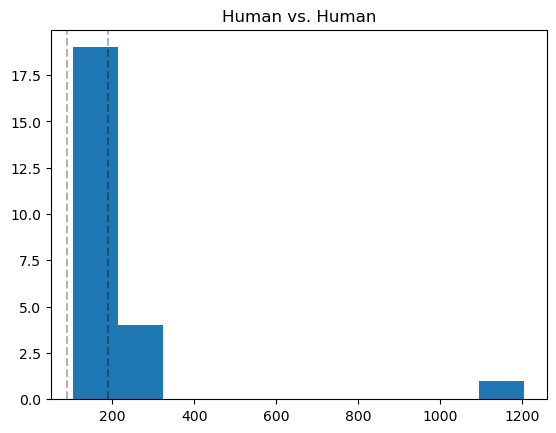

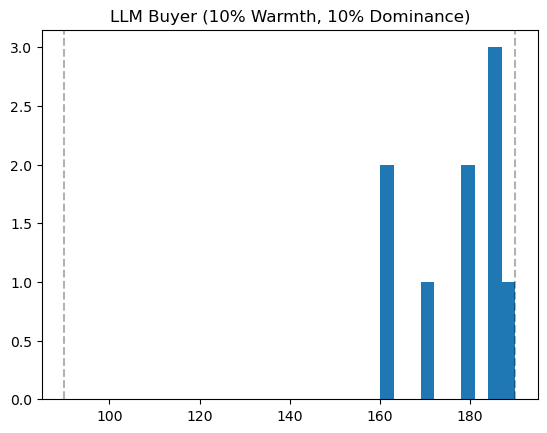

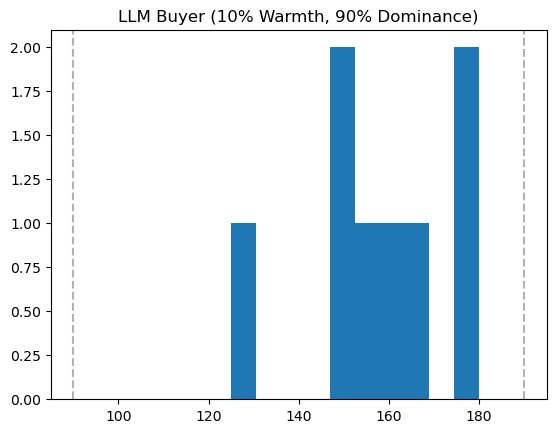

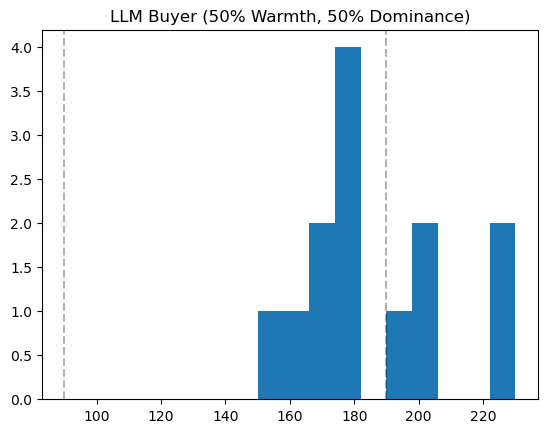

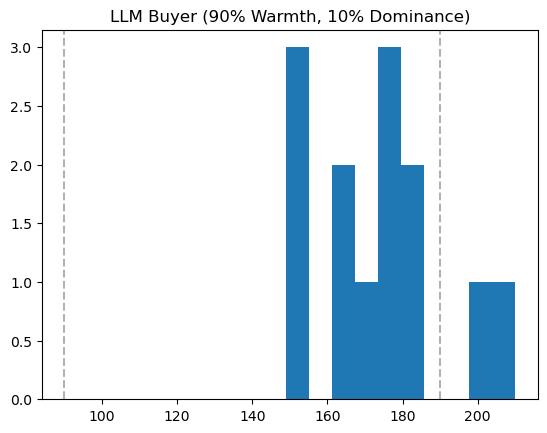

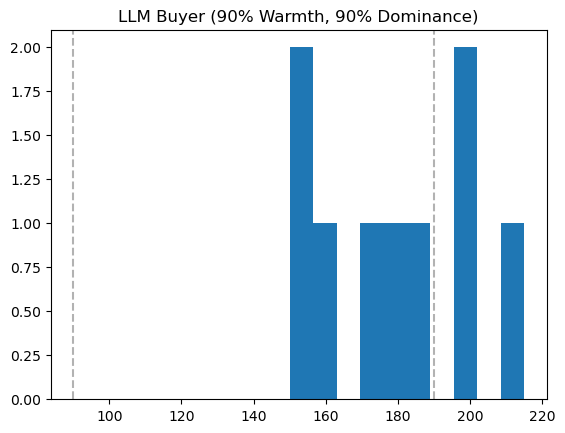

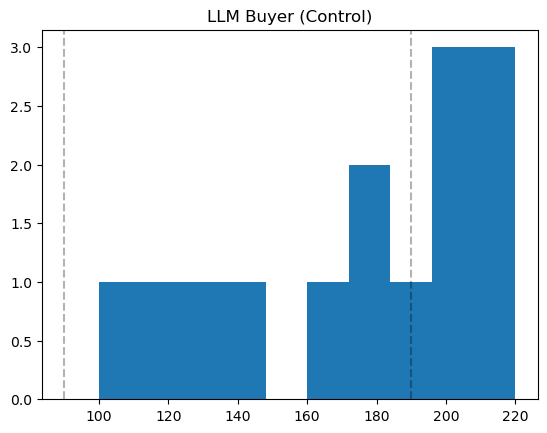

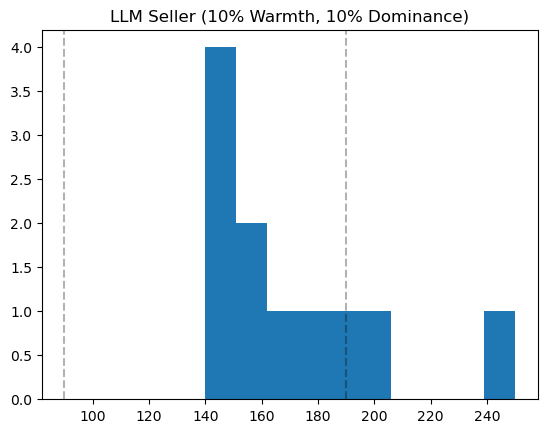

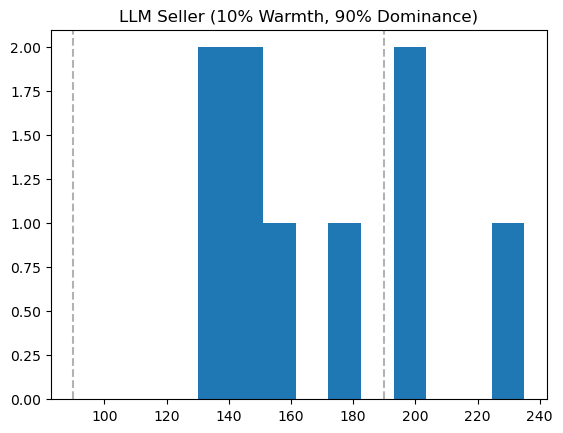

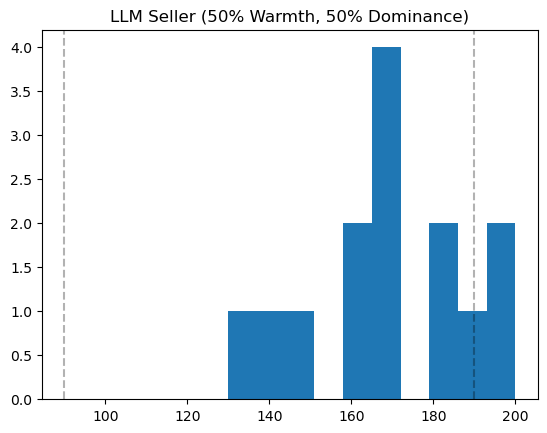

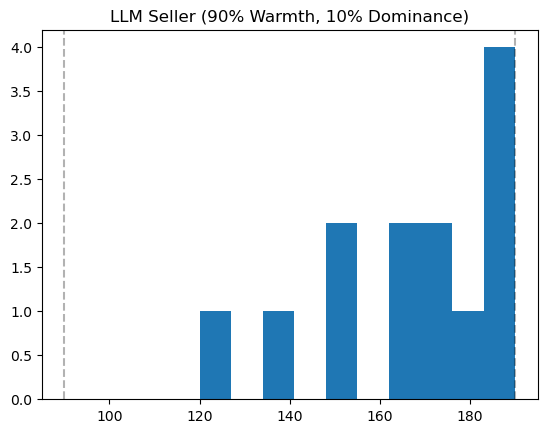

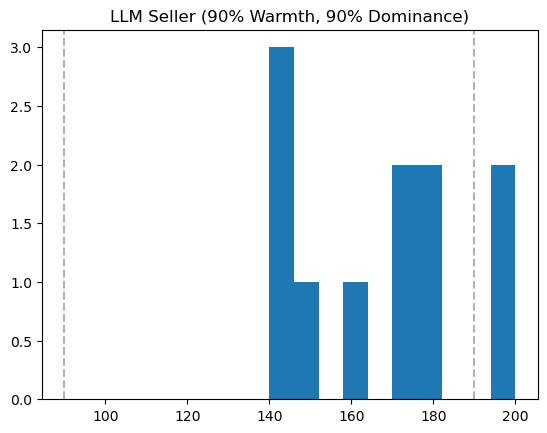

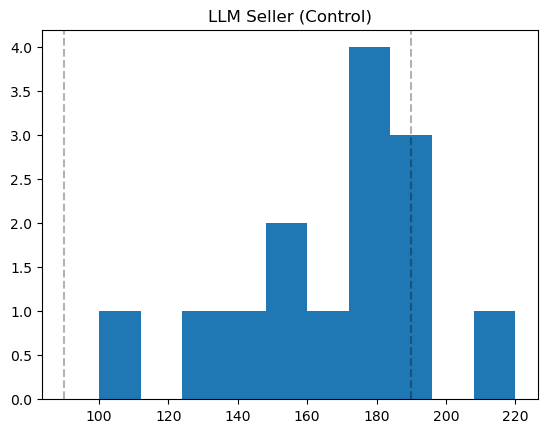

In [626]:
for treatment in df_games.treatmentName.unique():
    plt.hist(df_games.query("treatmentName == @treatment").price)
    plt.axvline(90, alpha=0.3, color="black", linestyle="--")
    plt.axvline(190, alpha=0.3, color="black", linestyle="--")
    plt.title(treatment)
    plt.show()

In [553]:
df_games.groupby("treatmentName")["deal_reached"].mean().sort_values(), df_games.groupby("symmetric_treatment_name")["deal_reached"].mean().sort_values()

(treatmentName
 LLM Buyer (10% Warmth, 90% Dominance)     0.533333
 LLM Buyer (10% Warmth, 10% Dominance)     0.600000
 LLM Seller (10% Warmth, 90% Dominance)    0.600000
 LLM Buyer (90% Warmth, 90% Dominance)     0.642857
 LLM Seller (10% Warmth, 10% Dominance)    0.733333
 LLM Seller (90% Warmth, 90% Dominance)    0.733333
 Human vs. Human                           0.857143
 LLM Buyer (50% Warmth, 50% Dominance)     0.866667
 LLM Buyer (90% Warmth, 10% Dominance)     0.866667
 LLM Seller (90% Warmth, 10% Dominance)    0.866667
 LLM Buyer (Control)                       0.933333
 LLM Seller (50% Warmth, 50% Dominance)    0.933333
 LLM Seller (Control)                      1.000000
 Name: deal_reached, dtype: float64,
 symmetric_treatment_name
 10% Warmth, 90% Dominance    0.566667
 10% Warmth, 10% Dominance    0.666667
 90% Warmth, 90% Dominance    0.689655
 90% Warmth, 10% Dominance    0.866667
 50% Warmth, 50% Dominance    0.900000
 Control                      0.965517
 Name: deal_

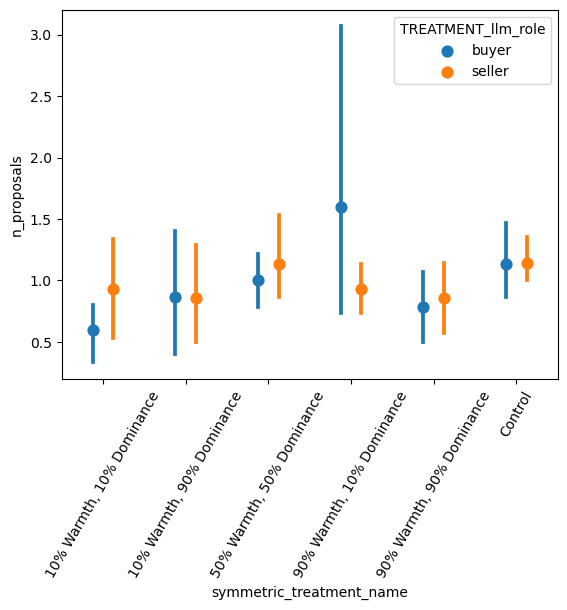

In [627]:
sns.pointplot(x="symmetric_treatment_name", y="n_proposals", hue="TREATMENT_llm_role", data=df_games, dodge=0.25, linestyles="")
plt.xticks(rotation=60)
plt.show()

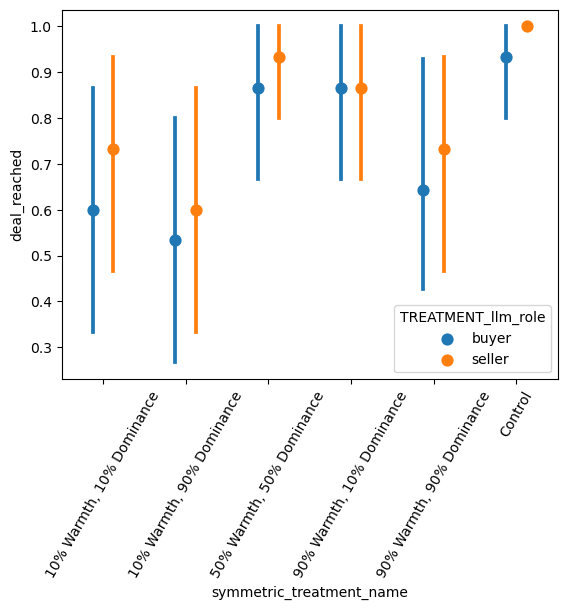

In [559]:
sns.pointplot(x="symmetric_treatment_name", y="deal_reached", hue="TREATMENT_llm_role", data=df_games, dodge=0.25, linestyles="")
plt.xticks(rotation=60)
plt.show()

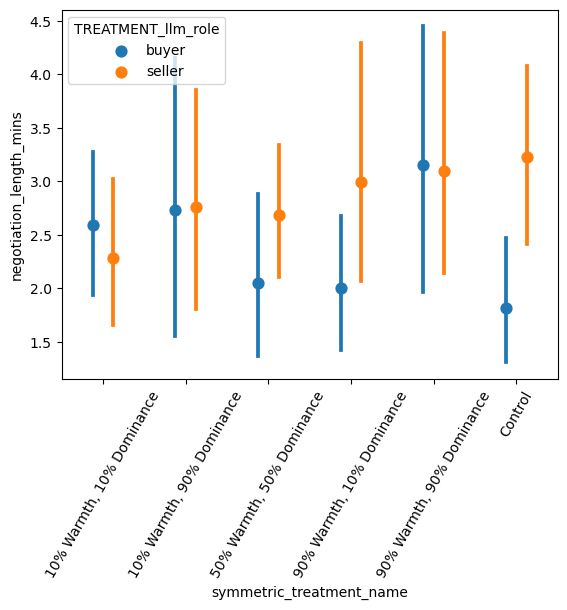

In [562]:
sns.pointplot(x="symmetric_treatment_name", y="negotiation_length_mins", hue="TREATMENT_llm_role", data=df_games, dodge=0.25, linestyles="")
plt.xticks(rotation=60)
plt.show()

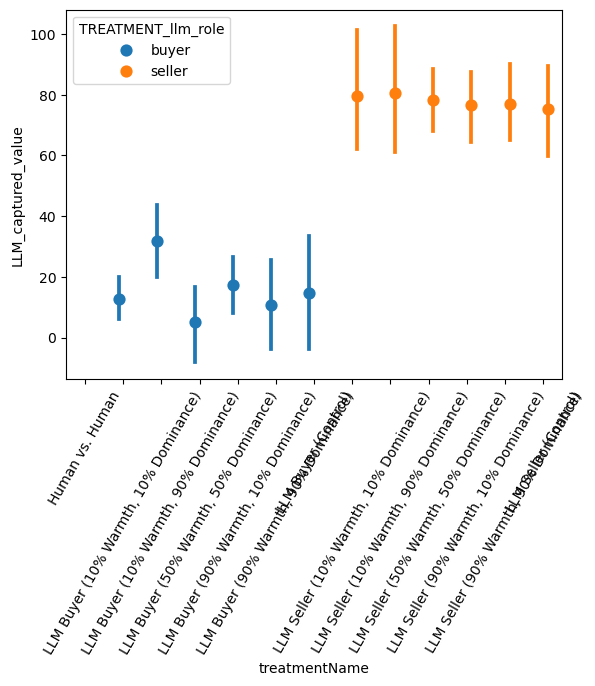

In [634]:
sns.pointplot(x="treatmentName", y="LLM_captured_value", hue="TREATMENT_llm_role", data=df_games, dodge=0.25, linestyles="")
# plt.axhline(90, alpha=0.3, color="black", linestyle="--")
# plt.axhline(190, alpha=0.3, color="black", linestyle="--")
# plt.axhline(df_games.query("treatmentName == 'Human vs. Human'").price.median(), color="green")
plt.xticks(rotation=60)
plt.show()

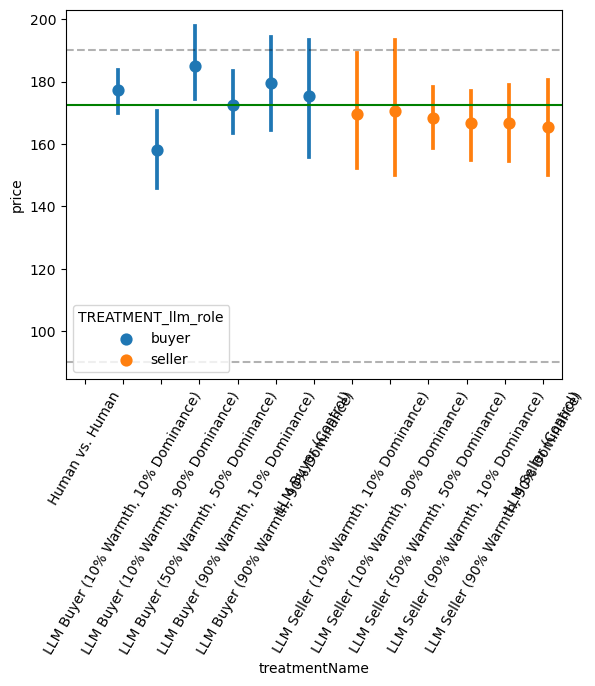

In [633]:
sns.pointplot(x="treatmentName", y="price", hue="TREATMENT_llm_role", data=df_games, dodge=0.25, linestyles="")
plt.axhline(90, alpha=0.3, color="black", linestyle="--")
plt.axhline(190, alpha=0.3, color="black", linestyle="--")
plt.axhline(df_games.query("treatmentName == 'Human vs. Human'").price.median(), color="green")
plt.xticks(rotation=60)
plt.show()

In [581]:
df_games.query("treatmentName == 'Human vs. Human'").price.mean()

214.83333333333334

(array([19.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 105.,  215.,  325.,  435.,  545.,  655.,  765.,  875.,  985.,
        1095., 1205.]),
 <BarContainer object of 10 artists>)

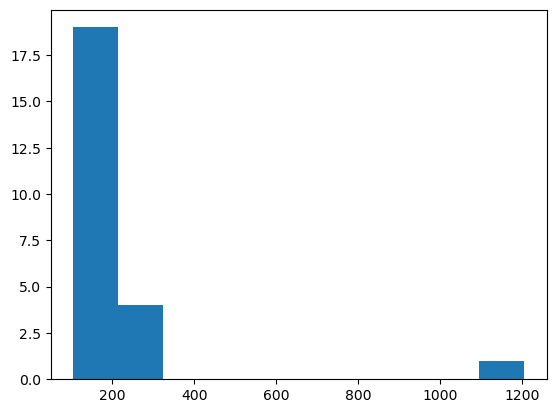

In [582]:
plt.hist(df_games.query("treatmentName == 'Human vs. Human'").price)

# Inspect chats 

In [599]:
for game in df_games.query("TREATMENT_llm_role == 'buyer' and price > LLM_batna").itertuples():
    display(Markdown(f"# {game.id} -- {game.symmetric_treatment_name}"))
    # print(ast.literal_eval(game.messages))
    for message in ast.literal_eval(game.messages):
        if message["type"] == "proposal":
            print(f"{message['agentType']} proposal ({message['proposal']}): {message['proposalStatus']}")
        else:
            print(f"{message['agentType']}: {message['text']}")

# 01HGXTHCNW03HMBM2F7XY69V85 -- Control

assistant: I'm really interested in this table. I've seen similar ones around, and I think a fair price would be $150. What do you think?
user: I dunno, I bought it brand new for 400 and haven't even used it. It's worth more than 150, Can you go higher?
assistant: I understand that you bought it for a higher price, but considering it's a used table, I think $170 would be a reasonable offer.
user: Wasn't even touched. It's in perfect condition. I'm looking for 300
assistant: I understand your point, but $300 is a bit steep for me. I can stretch my budget to $190. If we can't agree on this, I might have to consider other options.
user: Can you do 250?
assistant: I appreciate your counteroffer, but $250 is still a bit high for me. I can go up to $200, but that's the maximum I can offer. If we can't agree on this, I might have to look elsewhere.
user proposal (200): accepted


# 01HH02ST88VS9QTPE5PG3A5EN6 -- 50% Warmth, 50% Dominance

assistant: Hello, I saw your advertisement for the table and I am interested. I understand that this type of table is no longer available new, which adds to its value. However, considering it's a used item, I was thinking of offering $150. What do you think about this price?
user: Hello thanks for taking an interest I just bought it for $300 and I am happy to let it go for $225 as its in the same condition as I bought it but I just need to get rid of it
assistant: I understand your position, but considering it's a used item, I think $200 would be a fair price. This is my final offer. If we can't agree on this, I might have to consider other options.
user: I am happy to do this
assistant proposal (200): accepted


# 01HH02ST89VBRBER3DEFDQ5WW8 -- 90% Warmth, 10% Dominance

assistant: Hello there! I've been looking at your table and I must say, it's in excellent condition. I'm really interested in it. I was wondering if you could consider $150 for it? I think it's a fair price given that it's a used item. What do you think?
user: 250
assistant: I understand where you're coming from, but $250 seems a bit high for a used table. Would you consider $175? I believe it's a reasonable offer.
user: 225
assistant: I appreciate your willingness to negotiate, but $225 is still a bit more than I was hoping to spend. Could we possibly meet in the middle at $200? If not, I may have to consider other options.
user: 200
assistant proposal (200): accepted


# 01HH02ST8B27PY4W0KXDB3YDQQ -- Control

assistant: I'm interested in the table you're selling. Given that it's used, I think a fair starting offer would be $150. What do you think?
user: yes it has been used as such but doesnt look it as it is in excellent condition. Thanks for the offer but its far too low for what i would like to get. I will bring it down to $280 though if you pick it up soon
assistant: I understand that the table is in excellent condition, but considering it's not brand new, I think $280 is a bit steep. How about we meet in the middle at $200?
user: I think i could get much more than your offer. I have only just put it up for sale so i may have to wait for other offers before accepting yours
assistant: I understand your position, but I can't go much higher than my last offer. If we can't reach a deal around that price, I may have to consider other options. Would you reconsider my offer of $200?
user: Lets say $250 and meet in the middle?
assistant: I appreciate your willingness to negotiate, but $250 is s

# 01HH0EK1N237H98X7RMAT4DGMG -- 50% Warmth, 50% Dominance

assistant: Hello, I'm interested in the table you're selling. I've seen it and it's in excellent condition. I was wondering what price you had in mind for it?
user: Somewhere in the ballpark of 250
assistant: I see. That's a bit higher than I was hoping to pay. Would you consider lowering the price to $200?
user: this table is in excellent condition, as you have seen for yourself. 200 is too low given the value of the table
assistant: I understand your point, but I was hoping we could meet somewhere in the middle. How about $225? This seems like a fair compromise.
user: How does 240 sound to you?
assistant: I appreciate your counteroffer, but I was really hoping to stay closer to the $225 mark. Would you reconsider? If not, I may have to explore other options.
user: It's unlikely you will find a table of this calibre elsewhere, I am confident of that. However I am willing to drop the price to 235
assistant: I appreciate your willingness to negotiate, but I must insist on $230. If we ca

# 01HH0EK2V76Q0QADE6ZSPRWGM5 -- 90% Warmth, 90% Dominance

assistant: Hello there! I've taken a look at the table you're selling and I must say, it's in excellent condition. I'm definitely interested in purchasing it. I was thinking of offering you $150 for it. What do you think about that?
user proposal (250): rejected
assistant: I appreciate your counteroffer, but $250 is a bit more than I was hoping to spend. How about we meet in the middle at $200?
user: Hi there.  I'm glad you like it!! It is in good condition. I was thinking more of $250 but as I can tell you really like it I'd be happy to go with $225?
assistant: I understand where you're coming from, but $225 is still a bit steep for me. I can stretch my budget to $210, but that's my final offer. If we can't agree on this price, I'm afraid I'll have to look elsewhere.
user: We're nearly there so no need to walk away.  $215 and it's yours :)
assistant proposal (215): accepted


# 01HH2R0G76GMTN32CP4F9GC0NB -- Control

assistant: Hello, I recently saw your advertisement for the used table and I'm quite interested. I understand that this table is no longer available new, which adds some value. However, considering it's used, I believe a fair starting offer would be $150. What do you think?
user: The table is in excellent condition, as you've already seen. I think I would greatly prefer a price closer to $265. What do you say?
assistant: I appreciate your counteroffer, but $265 seems a bit steep for a used table, even if it's in excellent condition. I can increase my offer to $170. If we can't find a middle ground soon, I may have to consider other options.
user: I certainly have other options for buyers if we can't work a good price together. But I did appreciate the time you took to come down to see it. How does $236 sound to you?
assistant: I understand your position, but $236 is still a bit high for me. I can stretch my budget to $180. If we can't agree on a price soon, I may have to look elsewhere

# 01HH2R0G76GMTN32CP54SFD4CP -- 50% Warmth, 50% Dominance

user: 250
assistant: I appreciate your offer, but I was hoping to pay a bit less for the table. Would you consider $220?
user: 230
assistant: I understand where you're coming from, but I was really hoping to pay a bit less. How about $225?
user proposal (225): accepted


# 01HH2R0JXK08NDWJ4TEJ7CGFMQ -- 50% Warmth, 50% Dominance

assistant: Hello, I'm interested in the table you have for sale. I understand that it's in excellent condition. Could you please tell me your asking price?
user: I'm asking $250
assistant: I appreciate your offer, but I was hoping for a lower price. Would you consider $180 for the table?
user: I can do 225. It's a great price for this table as it's in excellent condition
assistant: I understand your point, but I was hoping to spend a bit less. Would you be able to meet me at $200? If not, I might have to consider other options.
user: Yes I can do $200. You have a deal
assistant proposal (200): accepted


# 01HH2R0JXNJ8CM5RATZHWHN56V -- 90% Warmth, 90% Dominance

assistant: Hello there! I've had a chance to look at the table you're selling and I must say, it's in excellent condition. I'm interested in buying it. What's your asking price?
user: It is in great condition, isn't it? Like new and barely been touched. I'm looking for $240 for it.
assistant: I see where you're coming from, but $240 seems a bit steep for a used table, even one in such good condition. How about we settle on $160? It's a fair price considering the table isn't new.
user: It's not new, but nobody would ever know. It would be $300 to buy a new one from a store so I really think that $240 is a fair price
assistant: I understand your perspective, but I still believe $160 is a more reasonable price. If we can't agree on a price closer to that, I may have to consider other options.
user: I would accept $220 but I wouldn't want to go much lower. $160 is not enough
assistant: I appreciate your willingness to negotiate, but $220 is still more than I'm willing to pay for a used tab

# 01HH2S2BKFV231V7GF3CPDHARD -- Control

assistant: I'm interested in the table you're selling. I've seen it and it's in great condition. However, considering it's a used item, I was thinking of offering $150 for it. What do you think?
user: i want to sell for $250
user proposal (250): rejected
assistant: I understand your position, but $250 is a bit steep for me. Considering it's a used item, would you consider $175?
user: no
assistant: I see. Well, I can stretch my budget a bit. How about we meet in the middle at $200? This is my final offer. If we can't agree on this, I'm afraid I'll have to look elsewhere.
user proposal (230): rejected
assistant: I'm sorry, but $230 is still too high for me. As I mentioned before, my final offer is $200.
user proposal (210): accepted


# 01HH2VKZT3XNZA832VMWGDEFC5 -- Control

assistant: I'm interested in the table you're selling. Given that it's used, I think a fair price would be $150. What do you think?
user: 280
assistant: I understand where you're coming from, but $280 seems a bit high for a used table. How about we meet in the middle at $200?
user: 260
assistant: I appreciate your willingness to negotiate, but $260 is still a bit steep for me. I can go up to $210, but that's my final offer. If we can't agree on this, I'm afraid I'll have to look elsewhere.
user: 220
assistant proposal (220): accepted


# 01HH2VM0T1T31MP10GEEFY7M4M -- 90% Warmth, 90% Dominance

assistant: Hello there! I recently saw your advertisement for the table and I must say, it's in excellent condition. I'm definitely interested in purchasing it. I understand that this kind of table used to sell for $300 new, but since it's used, I was thinking of offering $150. What do you think about this price?
user: I think that is a bit to low of a offer. It is in excellent condition so I would like to sell for $275.
assistant: I appreciate your counteroffer, but $275 is a bit steep for me. Considering the table is used, I believe a fair price would be $175. I hope we can find a middle ground that suits both of us. If not, I may have to consider other options.
user: That is still too low. How about $230?
assistant: I understand where you're coming from, but $230 is still a bit high for me. I can stretch my budget to $200, but that's my final offer. If we can't agree on this, I'm afraid I might have to look elsewhere.
user: Would you be willing to meet me in the middle and do $215?


# 01HH2W7BZP7YY1ADTGGZRQ13CZ -- 90% Warmth, 10% Dominance

assistant: Hello there! I recently saw your advertisement for the table and I must say, it's in excellent condition. I'm really interested in it. How much are you thinking of selling it for?
user: Hi, I am selling it for $250....
assistant: I see. $250 is a bit higher than I was hoping to spend. Would you consider lowering the price to $170? I believe that's a fair price considering it's a used table.
user: That is a fair price indeed... how about $230?
assistant: I appreciate your willingness to negotiate, but $230 is still a bit steep for me. Would you consider meeting me halfway at $200? I think that's a reasonable price for both of us.
user: This table is almost brand new, and is a fantastic deal at $215?
assistant: I understand that the table is in great condition, but $215 is still a bit more than I was hoping to spend. I can stretch my budget to $205. If we can't agree on this, I might have to consider other options.
user: Hmm that is a good offer that you have given me... would

# 01HH2WKP0527WV8XB3XP6KKAG4 -- Control

assistant: I've had a chance to look at the table and it's in great condition. I'm interested in buying it. How much are you asking for it?
user: hello I am asking 250 for the table
assistant: I see. Well, considering that it's a used table, would you consider lowering the price to $150?
user: because of the condition of the table and that fact that it was hardly used I would like to get at least 250 for it
assistant: I understand your point of view, but $250 is a bit steep for me. Would you consider meeting me halfway at $200? If not, I might have to consider other options.
user: how about 225?
assistant: I appreciate your willingness to negotiate, but $225 is still a bit more than I was hoping to spend. I really can't go above $200. If we can't agree on this, I'm afraid I might have to look elsewhere.
user: I feel like you are not meeting me in the middle here. can you go any higher?
assistant: I'm sorry, but $200 is the maximum I can offer for the table. If we can't agree on this pr

In [602]:
for game in df_games.query("TREATMENT_llm_role == 'seller' and price > 190").itertuples():
    display(Markdown(f"# {game.id} -- {game.treatmentName}"))
    # print(ast.literal_eval(game.messages))
    for message in ast.literal_eval(game.messages):
        if message["type"] == "proposal":
            print(f"{message['agentType']} proposal ({message['proposal']}): {message['proposalStatus']}")
        else:
            print(f"{message['agentType']}: {message['text']}")

# 01HGXTHAFDBNGZT089GRCCYTVM -- LLM Seller (50% Warmth, 50% Dominance)

assistant: I'm glad you're interested in the table. It's in excellent condition, as you've seen. I initially bought it for $300. Considering its excellent condition, I think $200 would be a fair price. What do you think?
user: I am willing to pay $150
assistant: I understand your offer, but considering the excellent condition of the table, I believe $200 is a reasonable price. If we can't reach an agreement, I may have to consider other options.
user: I can pay cash right now for $150
assistant: I appreciate your offer, but I must insist on $200. This is my final offer. If we can't agree on this price, I'm afraid we may not be able to reach a deal.
user: Okay I will pay $200
assistant proposal (200): accepted


# 01HGXTHCNZGK4YR4Z3RX7WPJHB -- LLM Seller (90% Warmth, 90% Dominance)

assistant: Hello, thank you for your interest in the table. I'm glad you've had a chance to see it and appreciate its excellent condition. I originally bought it for $300. Considering its condition, I believe a fair price would be $200. What do you think?
user: HI
assistant: Hello, how can I assist you further regarding the table? Are you considering the proposed price of $200?
user: Yes its in a good condition
assistant proposal (200): accepted


# 01HH02SRZSYQDP4GFAHNY553XZ -- LLM Seller (90% Warmth, 90% Dominance)

assistant: Hello, I'm glad you're interested in the table. It's a great piece, isn't it? I originally purchased it for $300. Considering its excellent condition, I think a fair price would be $200. What do you think?
user: I can go to the furniture store, but yes, 200 seems fair as an individual with a good condition table. Would you be willing to do 190 like the store?
assistant: I appreciate your offer, but I believe $200 is a fair price given the table's excellent condition. If we can't agree on this price, I may have to consider other options.
user: 200 is fine. I'd rather count on you than the store.
assistant proposal (200): accepted


# 01HH02ST8C3Q57DFARS00T4CVF -- LLM Seller (10% Warmth, 90% Dominance)

assistant: Hello, I'm glad you're interested in the table. It's a great piece of furniture and it's in excellent condition. I originally bought it for $300. Considering its condition, I think $250 would be a fair price. What do you think?
user: How long have you had the table
assistant: I've had the table for a couple of years, but it's been well taken care of and is still in excellent condition. The quality of the table is still as good as new. I believe $250 is a reasonable price for it.
user: Considering the price you paid and how long you have owned it I think that 250 is a bit high
assistant: I understand where you're coming from. However, the table is in excellent condition and it's a high-quality piece. I can lower the price to $220. If we can't agree on a price, I may have to consider other options.
user: I do know my local furniture store has one the same in stock for 190 and they will also give me free delivery
assistant: I see. However, the table you're referring to is new a

# 01HH2R0G75Z2KR4Z4K0MS8RY8A -- LLM Seller (10% Warmth, 10% Dominance)

assistant: I'm glad you're interested in the table. Considering its excellent condition, I believe a fair price would be $250. What do you think?
user: I would like to pay less than this
assistant: I understand your concern. However, considering the quality and condition of the table, I believe the price is justified. How about we meet halfway at $225?
user: That is a reasonable offer but as I will need to get the table to my house I cannot afford that much. I am happy to give you 185
assistant: I appreciate your offer, but I must say that $185 is a bit lower than I was hoping for. Given the quality and condition of the table, I think $210 would be a more reasonable price. If we can't reach an agreement around this price, I may have to consider other options.
user: Ok. Well ican buy the same table for 190 but it has been used, although it is in perfecr condition. Would you accept 199
assistant: I appreciate your offer, but I must say that $199 is still a bit lower than I was hoping for

# 01HH2R0G77ZBCMP0ZM391Z8DHY -- LLM Seller (Control)

assistant: I'm glad you're interested in the table. As you've seen, it's in excellent condition. I bought it new for $300. Given its condition, I think a fair price would be $200. What do you think?
user: I've seen one at another store for $190.  Can you do that?
assistant: I understand that you've seen a similar table for $190. However, considering the excellent condition of this table, I believe $200 is a reasonable price. If we can't agree on this, I might have to consider other options.
user: What about $195?
assistant proposal (195): accepted


# 01HH2R0JXM9M4H5YDSQDW9JAQZ -- LLM Seller (10% Warmth, 10% Dominance)

assistant: I'm glad you're interested in the table. It's in excellent condition and I bought it for $300. I think a fair price would be $200. What do you think?
user: How about $250?
assistant proposal (250): accepted


# 01HH2VKZSSYXKAWCNCPV5B4V16 -- LLM Seller (10% Warmth, 90% Dominance)

assistant: I'm glad you're interested in the table. It's in excellent condition and I originally bought it for $300. I think a fair price would be $250. What do you think?
user: It's a used table. Thrift shop value is 30% of the original sales price. This is true, correct?
assistant: While I understand your point, the quality and condition of the table are far superior to most used furniture. It's practically like new. I believe $200 would be a more reasonable price. If we can't agree on a price that reflects the table's value, I may have to consider other options.
user: That seems fair enough. I accept.
assistant proposal (200): accepted


# 01HH2W7C0DP0M05KQFT1YSNM2J -- LLM Seller (50% Warmth, 50% Dominance)

assistant: Hello, thank you for your interest in the table. I'm glad you had a chance to see it and appreciate its excellent condition. I originally bought it for $300. Given its condition, I think a fair price would be $200. What do you think?
user: hi, i was hoping to get the table for $190
assistant: I appreciate your offer, but I was hoping to get a bit more for the table. How about we meet in the middle at $195?
user: what about $192
assistant: I think we're very close to an agreement. I can meet you at $193. What do you say?
user: that sounds great
assistant proposal (193): accepted


# 01HH2WDA152BSG1FTHNQNGD4MK -- LLM Seller (10% Warmth, 90% Dominance)

assistant: I'm glad you're interested in the table. Considering its excellent condition, I believe a fair price would be $250. What do you think?
user: Would you take $220?
assistant: I appreciate your offer, but I believe the table is worth a bit more. How about we meet in the middle at $235?
user: Sure that works for me
assistant proposal (235): accepted


# 01HH2WDA1DQ58NR3MV0594054N -- LLM Seller (Control)

user: 190
assistant: I appreciate your offer, but considering the excellent condition of the table, I was hoping for something closer to $250. Would that work for you?
user proposal (90): rejected
assistant: I'm sorry, but that's too low for me. How about we meet in the middle at $220?
user proposal (220): accepted


In [608]:
for game in df_games.query("treatmentName == 'Human vs. Human'").sort_values("price", ascending=False).itertuples():
    display(Markdown(f"# {game.id} -- {game.deal_reached}"))
    # print(ast.literal_eval(game.messages))
    for message in ast.literal_eval(game.messages):
        if message["type"] == "proposal":
            print(f"{message['playerId']} proposal ({message['proposal']}): {message['proposalStatus']}")
        else:
            print(f"{message['playerId']}: {message['text']}")

# 01HH2S2BKDJHJXEH9CY0XMYA5W -- 1

01HH2SVNZ88JCBCQKD9T597JCG proposal (100): rejected
01HH2SVNZ88JCBCQKD9T597JCG proposal (1205): accepted


# 01HH2WKP1N51C05SQFCCTXMKGX -- 1

01HH2WZPW2QQK0KPKHSQX4AAT8: $250
01HH2WZPW2QQK0KPKHSQX4AAT8 proposal (250): accepted


# 01HH2WDA070ZQ7SR361H80E1R6 -- 1

01HH2WHWQC8PMP7HRPF5D8T6V3: Hi I bought this and it’s still great condition I Paid around $300
01HH2WHWQC8PMP7HRPF5D8T6V3: So looking to make decent money back
01HH2WHT5934DQQ9807D742WXP: Hello, would you be willing to do $250 for it?
01HH2WHWQC8PMP7HRPF5D8T6V3: Probably want to sell no less than 200
01HH2WHWQC8PMP7HRPF5D8T6V3 proposal (250): accepted


# 01HH02ST871Q2T770XFX1B990K -- 1

01HH03JEFNCCA0GACBC0S07TFD: hi. im interested in the table. what's the best price you can do?
01HH03Y26C2RNXWASZ4BBDEWPJ: It's in excellent condition, I'm willing to sell it for $330
01HH03Y26C2RNXWASZ4BBDEWPJ: What price are you interested in purchasing it for?
01HH03JEFNCCA0GACBC0S07TFD: is it in brand new condition?
01HH03Y26C2RNXWASZ4BBDEWPJ: Not quite, but very close.
01HH03JEFNCCA0GACBC0S07TFD: the rrp is $300 so wouldn't be willing to go above that
01HH03Y26C2RNXWASZ4BBDEWPJ: Okay fair enough, how about $270?
01HH03JEFNCCA0GACBC0S07TFD: any chance you could do 230?
01HH03Y26C2RNXWASZ4BBDEWPJ: How about $250?
01HH03JEFNCCA0GACBC0S07TFD: lets meet in the middle at 240?
01HH03Y26C2RNXWASZ4BBDEWPJ: Sure, $240 it is, you've got a deal.
01HH03Y26C2RNXWASZ4BBDEWPJ proposal (240): accepted


# 01HH2W7C066JE2XHSM2G0DRSTV -- 1

01HH2WF2E86JJ7PNXGPTQCATNW: Hi there, I understand you're interested in buying the table I have for sale.
01HH2WDZ55B6XPMXQ41F20VM7P: Yes, looking at it for around 100.00
01HH2WDZ55B6XPMXQ41F20VM7P: Table is used, even if in good condition which is why 100 is reasonable.
01HH2WF2E86JJ7PNXGPTQCATNW: I appreciate you've already seen it, so you've seen the excellent quality of it. I'm looking closer to the 250 mark.
01HH2WF2E86JJ7PNXGPTQCATNW: These tables for 300 brand new. It's an iconic piece that would look stunning in any home.
01HH2WDZ55B6XPMXQ41F20VM7P: What do you think about 150? I'll come now and take it from you, won't have to waste time negotiating with anyone else.
01HH2WF2E86JJ7PNXGPTQCATNW: It's a great offer, however, it's made out of solid oak and beautiful craftmanship.
01HH2WF2E86JJ7PNXGPTQCATNW: Would you move closer to the 250 mark? Honestly, this is a great item, i'm gutted I have to part with it.
01HH2WDZ55B6XPMXQ41F20VM7P: I'll do 200, we meet in the middle and bot

# 01HH0EK2V10VEMQ58EWF352JJ9 -- 1

01HH0FRRPNN0FYHRYQ4YAAYMVS: I'd like to propose $280
01HH0FRRPNN0FYHRYQ4YAAYMVS proposal (280): rejected
01HH0FQAMCD2FCDR3EZ4415C9X: 259
01HH0FQAMCD2FCDR3EZ4415C9X: 150
01HH0FRRPNN0FYHRYQ4YAAYMVS proposal (270): rejected
01HH0FQAMCD2FCDR3EZ4415C9X: $159
01HH0FRRPNN0FYHRYQ4YAAYMVS proposal (220): rejected
01HH0FRRPNN0FYHRYQ4YAAYMVS: Table is in excellent condition and you've seen it already
01HH0FQAMCD2FCDR3EZ4415C9X proposal (160): rejected
01HH0FRRPNN0FYHRYQ4YAAYMVS: It's too low
01HH0FRRPNN0FYHRYQ4YAAYMVS proposal (210): accepted


# 01HH2R0G75Z2KR4Z4K06FJESFW -- 1

01HH2RMQS2EP2TTZTABBYP1QYN: hello
01HH2RJJGBC9RRMAR0T7A1C76C: Hey, I'm interest in the table but i'm on such a tight budget, what can you do to help me?
01HH2RMQS2EP2TTZTABBYP1QYN proposal (320): rejected
01HH2RMQS2EP2TTZTABBYP1QYN proposal (320): rejected
01HH2RJJGBC9RRMAR0T7A1C76C: That way out of my budget i'm afraid.. can you help me?
01HH2RMQS2EP2TTZTABBYP1QYN: i can negotitate to 280
01HH2RMQS2EP2TTZTABBYP1QYN proposal (280): rejected
01HH2RMQS2EP2TTZTABBYP1QYN: how about 250 dollars
01HH2RJJGBC9RRMAR0T7A1C76C: At least you're heading the right direction but that's way to steep..
01HH2RMQS2EP2TTZTABBYP1QYN proposal (250): rejected
01HH2RMQS2EP2TTZTABBYP1QYN: how much would you be willing to pay for it
01HH2RMQS2EP2TTZTABBYP1QYN proposal (245): rejected
01HH2RJJGBC9RRMAR0T7A1C76C: I've seen a used version of the table from a local furniture store, with a little TLC it would be as good as the one you're selling..
01HH2RMQS2EP2TTZTABBYP1QYN: it is worth 300 at least
01HH2RMQS2EP2TTZ

# 01HH2S2BKDJHJXEH9CY72EMYTV -- 1

01HH2SM0NW8WAC1R3GKW65MSCB: 25
01HH2T42HB4KV6Z93EHEPYCV2V proposal (275): rejected
01HH2SM0NW8WAC1R3GKW65MSCB: 50
01HH2T42HB4KV6Z93EHEPYCV2V: 250
01HH2SM0NW8WAC1R3GKW65MSCB: 100
01HH2T42HB4KV6Z93EHEPYCV2V: 245
01HH2SM0NW8WAC1R3GKW65MSCB: 125
01HH2T42HB4KV6Z93EHEPYCV2V: 240
01HH2SM0NW8WAC1R3GKW65MSCB: 130
01HH2T42HB4KV6Z93EHEPYCV2V: 235
01HH2SM0NW8WAC1R3GKW65MSCB: 130
01HH2T42HB4KV6Z93EHEPYCV2V: 233
01HH2SM0NW8WAC1R3GKW65MSCB: 135
01HH2T42HB4KV6Z93EHEPYCV2V: 230
01HH2SM0NW8WAC1R3GKW65MSCB: 135
01HH2T42HB4KV6Z93EHEPYCV2V: 227
01HH2SM0NW8WAC1R3GKW65MSCB: 135
01HH2T42HB4KV6Z93EHEPYCV2V: 226
01HH2SM0NW8WAC1R3GKW65MSCB: 140
01HH2T42HB4KV6Z93EHEPYCV2V: 225
01HH2SM0NW8WAC1R3GKW65MSCB: 145
01HH2T42HB4KV6Z93EHEPYCV2V: 223
01HH2SM0NW8WAC1R3GKW65MSCB: 150
01HH2T42HB4KV6Z93EHEPYCV2V: 220
01HH2SM0NW8WAC1R3GKW65MSCB: 150
01HH2T42HB4KV6Z93EHEPYCV2V: 217
01HH2SM0NW8WAC1R3GKW65MSCB: 155
01HH2T42HB4KV6Z93EHEPYCV2V: 216
01HH2SM0NW8WAC1R3GKW65MSCB: 160
01HH2T42HB4KV6Z93EHEPYCV2V: 215
01HH2SM0NW8WAC1R3GKW65

# 01HH2WKP120DME8AMFXYX3HTC8 -- 1

01HH2X5H8KFX8WGFWD86JMM8GH: Hi could I buy the used table for 100 dollars
01HH2X5HF4F6KPBT07ABF7KMKC: I will sell you the table for $200
01HH2X5HF4F6KPBT07ABF7KMKC: Its in great condition and that is $100 off
01HH2X5H8KFX8WGFWD86JMM8GH: No, i see a local store selling it for less than that. i would like to at least pay less because it is used. could i do 150
01HH2X5HF4F6KPBT07ABF7KMKC: ill do 180
01HH2X5H8KFX8WGFWD86JMM8GH proposal (180): accepted


# 01HH2WDA0DS7JH3JF3F1P2PABZ -- 1

01HH2WPFDNN67A82TYJHDCWM0Z: Hello, how are you today?
01HH2WQGNCJW37AX68ZY061XW5: i am great
01HH2WPFDNN67A82TYJHDCWM0Z: I'd like to discuss the table you have for sale.
01HH2WQGNCJW37AX68ZY061XW5 proposal (200): rejected
01HH2WQGNCJW37AX68ZY061XW5 proposal (180): accepted


# 01HH0EK1N1V616SH2FZ0Y692KZ -- 1

01HH0FMTT3421JAP32N15CSQ4X: hi
01HH0FG0J7C0SYER9X80MZSR5M: Hi I am intersted in the table will you take $100 for it
01HH0FG0J7C0SYER9X80MZSR5M proposal (100): rejected
01HH0FMTT3421JAP32N15CSQ4X: It is in excellent condition, almost new, i recently bought it for $300 dollas
01HH0FMTT3421JAP32N15CSQ4X: you wont find anything in this condition for less that $280
01HH0FG0J7C0SYER9X80MZSR5M: OK I am a student so I cannot afford too much how much do you want for it
01HH0FMTT3421JAP32N15CSQ4X proposal (280): rejected
01HH0FMTT3421JAP32N15CSQ4X: you have seen the condition of the table, it is immaculate, barely used, you could buy a new one in the same coniditon for $300
01HH0FG0J7C0SYER9X80MZSR5M: I have already seen the same table for sale at $150 so what do you think
01HH0FMTT3421JAP32N15CSQ4X: was it in excellent condition
01HH0FG0J7C0SYER9X80MZSR5M: yes just the same as yours
01HH0FMTT3421JAP32N15CSQ4X: i will drop to $250 and will deliver it to you immediately
01HH0FMTT3421JAP32N15CSQ4X

# 01HH2VM0T42VAKAX66J6GQ9JB9 -- 1

01HH2W3SJFWVWX00SNRS9ZE9YE: Hello, $200 for the table
01HH2W3P7HYCTH97VFYHC95R0G: Hello! I am interested in the table you are selling. Would you be willing to accept $140 for it?
01HH2W3P7HYCTH97VFYHC95R0G: No, I will not be spending $200.
01HH2W3SJFWVWX00SNRS9ZE9YE: But the table is in excellent condition, and relatively new
01HH2W3SJFWVWX00SNRS9ZE9YE: I'm giving you a great discount
01HH2W3P7HYCTH97VFYHC95R0G: While relatively new, it is still not a brand new product and I can get it for at least $10 less at the local furniture store in the same quality.
01HH2W3SJFWVWX00SNRS9ZE9YE: While I don't think this table will go for that low, I'm willing to reduce it for you for $180
01HH2W3P7HYCTH97VFYHC95R0G: I appreciate the offer. I can come up to $170.
01HH2W3SJFWVWX00SNRS9ZE9YE: How about $175?
01HH2W3P7HYCTH97VFYHC95R0G: I can do that, thank you!
01HH2W3P7HYCTH97VFYHC95R0G proposal (175): accepted


# 01HH2R0JXJZEPPRFW34DVBH8N3 -- 1

01HH2RTD3GM3RCK38E35G8PB36: Hi, this table is brand new and was worth $300. I believe I would be able to sell it elsewhere for at least $250.
01HH2RKXGKRXWXF2YEV0M4A077: i will offer $150
01HH2RTD3GM3RCK38E35G8PB36 proposal (200): rejected
01HH2RTD3GM3RCK38E35G8PB36 proposal (180): rejected
01HH2RKXGKRXWXF2YEV0M4A077 proposal (170): accepted


# 01HH2VM0TBFJG38G92BY3CYJ8Y -- 1

01HH2W6D3037V1HEE1HS6AFMMW: Hello
01HH2W3JJBYW7SRBVEAAJS9TV8: Hi there!@. I like uyour table.  How does $100 sound
01HH2W6D3037V1HEE1HS6AFMMW: Would you like to buy my table for $275
01HH2W3JJBYW7SRBVEAAJS9TV8: That table is 10 yaers old... and has scratches
01HH2W3JJBYW7SRBVEAAJS9TV8: I am going to hae to put some time and effort to make it look good
01HH2W6D3037V1HEE1HS6AFMMW: The table is in excellent condition and has already been seen by the buyer.
01HH2W6D3037V1HEE1HS6AFMMW: try again
01HH2W6D3037V1HEE1HS6AFMMW: 265
01HH2W3JJBYW7SRBVEAAJS9TV8: The table is used and is not holiin value.  The store down the streert ha it ror 190
01HH2W3JJBYW7SRBVEAAJS9TV8: SO I will be fair,.. $140
01HH2W6D3037V1HEE1HS6AFMMW: $200 and you have a deal
01HH2W3JJBYW7SRBVEAAJS9TV8: Youre still charging more than the store down the street,  $155
01HH2W6D3037V1HEE1HS6AFMMW: it's a $300 table $195 final offer
01HH2W3JJBYW7SRBVEAAJS9TV8: It's a USED table.  And youre charging more than the store down the s

# 01HH02ST8614GG822EBQQMC6K9 -- 1

01HH03JPC263JT232A8NSTJW99: Hello, will you take £100?
01HH03Q7WKG5J3K16A1XSACW8Q: Hi, no I'm sorry that's much lower than I was looking at.
01HH03Q7WKG5J3K16A1XSACW8Q: My price is $225
01HH03JPC263JT232A8NSTJW99: I can't go much higher i'm afraid. Would you accept £110?
01HH03JPC263JT232A8NSTJW99: $225 is much too high, i've seen them sold for $150
01HH03Q7WKG5J3K16A1XSACW8Q: Hm, well that's a mile lower than I'm asking, but I'm willing o talk it over. Maybe $180
01HH03JPC263JT232A8NSTJW99: I was thinking more like $150, could that be done?
01HH03Q7WKG5J3K16A1XSACW8Q: Call it $170 and we have a deal
01HH03JPC263JT232A8NSTJW99: I'm being cheeky I know but how about $160, please.
01HH03Q7WKG5J3K16A1XSACW8Q: I'll meet you in the middle out of good will, so $155 and we both are happy OK?
01HH03JPC263JT232A8NSTJW99: $155 is great thank you
01HH03JPC263JT232A8NSTJW99 proposal (155): accepted


# 01HH0EK2V5CNS988AQCAZ1AX4D -- 1

01HH0FQV8BJTXRC2JBXBJ3S7A8: Hi, the table is in excellent condition as you would have seen. I am offereing a price of $200 which is a lot less than I paid for it and it is like nearly new.
01HH0FM4R70BG74BNJ21WNRJSW: Hi - i am interested in buying a table that you are selling. Would you accept $70 for it?
01HH0FM4R70BG74BNJ21WNRJSW: I can see it is in good condition, i will collect it from you as well so there will be no delivery charges?
01HH0FQV8BJTXRC2JBXBJ3S7A8: No, I have had other interested parties and it is in nearly new condition and was expensive to begin with. You will not be able to purchase such a good quality table for less than $200
01HH0FM4R70BG74BNJ21WNRJSW: Ok maybe $70 was a bit cheeky how about $100?
01HH0FQV8BJTXRC2JBXBJ3S7A8: Haha that's okay, we all like to try and get a good deal! I would go down to $180 but that's my lowest possible price I would accept
01HH0FM4R70BG74BNJ21WNRJSW: I'm sorry i can't do $180 that is well beyond my budget the highest i can go is $

# 01HGXTHAEVY04KADBQQWWFP6VK -- 1

01HGXTT89F64Q4MQFJ6JSK14GB: hello
01HGXTXXHERWWD661BCTYAF242: Hello, hope you’re well
01HGXTT89F64Q4MQFJ6JSK14GB: im good thanks lets talk about this table?
01HGXTXXHERWWD661BCTYAF242: Yes, this table is in pristine condition, looking for a good home
01HGXTT89F64Q4MQFJ6JSK14GB: I've got $100 to take it away right now
01HGXTXXHERWWD661BCTYAF242: I’m thinking quite a bit more to be honest
01HGXTXXHERWWD661BCTYAF242: it’s not a junk piece of furniture, it’s quailty workmanship and solid oak
01HGXTXXHERWWD661BCTYAF242: $300 would be a fair price
01HGXTT89F64Q4MQFJ6JSK14GB: i dont know its christmas, nobody is going to have spare money. I can make it $120 and arrange and pay for collection
01HGXTXXHERWWD661BCTYAF242: You’ve seen the quailty in your precious viewing,
01HGXTT89F64Q4MQFJ6JSK14GB: so we have a deal then?
01HGXTXXHERWWD661BCTYAF242: I understand it’s Christmas time, but a chance to get another table like this won’t come around often
01HGXTXXHERWWD661BCTYAF242: Can you manage $20

# 01HH2VKZT5Y5M4A4F2S995M095 -- 1

01HH2VWV7EP2PQQKXF0K39H4M6: Hi I really like this table I would like to buy it for $100
01HH2W04RJ7SCMCWXE5EM36PQG: Hello, I feel $100 is too low provided the condition of the table. I am interested in selling it for $180.
01HH2VWV7EP2PQQKXF0K39H4M6: That is a little high for me. Perhaps I can afford $140.
01HH2W04RJ7SCMCWXE5EM36PQG: I would be willing to settle for $160, how does that sound?
01HH2VWV7EP2PQQKXF0K39H4M6: I appreciate your offer but I think all I can do is $150. That has to be my last offer.
01HH2W04RJ7SCMCWXE5EM36PQG: I am willing to settle for $150, it is a deal.
01HH2W04RJ7SCMCWXE5EM36PQG proposal (150): accepted


# 01HH02SRZEQ8740RRTSVXASQDM -- 1

01HH03FD0YT03MNTHR5SCSM761: 100
01HH03GAH3CP1F9XG8E5NWT7GN: This table is in excellent condition and I paid 300 for it, I was thinking closer to 200
01HH03FD0YT03MNTHR5SCSM761: i can only afford 100. I will take it away asap
01HH03GAH3CP1F9XG8E5NWT7GN: I will not go lower than 150, sorry
01HH03FD0YT03MNTHR5SCSM761: £130 please as thats the highest i can go.
01HH03GAH3CP1F9XG8E5NWT7GN: 140 and we have a deal
01HH03FD0YT03MNTHR5SCSM761: ok
01HH03GAH3CP1F9XG8E5NWT7GN proposal (140): accepted


# 01HH2W7C037AEN3EFQGGC2MV5D -- 1

01HH2WEQ9AJCD06H1Q4C5FR8F2: I will sell the table for 190$
01HH2WDK40VDKRKR6G1K64CPMV: Hi there! Great to work with ya. Will you accept $100 for the table?
01HH2WEQ9AJCD06H1Q4C5FR8F2: I will be willing to sell it for 150$
01HH2WDK40VDKRKR6G1K64CPMV: How bout we meet in the middle and settle on $125?
01HH2WEQ9AJCD06H1Q4C5FR8F2: 130$ and we have a deal
01HH2WDK40VDKRKR6G1K64CPMV: Okie doke!. $130 it is.
01HH2WDK40VDKRKR6G1K64CPMV proposal (139): accepted


# 01HH2R0G76GMTN32CP4V76X74A -- 1

01HH2RMEJGXWDBRFQNSNNFDQQ0: Hi, How are you?
01HH2RMFJ7MS66Y6RVCQNZHM0W: good how are you
01HH2RMFJ7MS66Y6RVCQNZHM0W: Are you still interested in the table?
01HH2RMEJGXWDBRFQNSNNFDQQ0: I'm well...Im just visiting you today because I'm really interested in a particular table. It reminds me of one my grandma used to have?
01HH2RMFJ7MS66Y6RVCQNZHM0W: What are you willing to pay?
01HH2RMEJGXWDBRFQNSNNFDQQ0: I dont have much money...Its been hard during this pandemic....How much of a discount could you give me? Im really going through hard times right now
01HH2RMFJ7MS66Y6RVCQNZHM0W: I could do $230
01HH2RMFJ7MS66Y6RVCQNZHM0W: I bought the table for $300
01HH2RMEJGXWDBRFQNSNNFDQQ0: Well. the used price is $190. You're selling a used table, not the new one
01HH2RMFJ7MS66Y6RVCQNZHM0W: Would you do $200
01HH2RMEJGXWDBRFQNSNNFDQQ0: umm...thats still really high. Like i said, i dont have much money. i just really wanted this because of the sentimental value. could you go a little lower please
01H

# 01HH02SRZF71XB8SE7GW0ZTTHJ -- 1

01HH03GRZRHT8YKNECY8WG6DPB: Hey
01HH03JKHWS51MX4QWH7J03S5H: You want to buy my table?
01HH03GRZRHT8YKNECY8WG6DPB: I would like to buy your table. How much are you selling it for?
01HH03JKHWS51MX4QWH7J03S5H: Make me an offer.
01HH03GRZRHT8YKNECY8WG6DPB: $100
01HH03JKHWS51MX4QWH7J03S5H proposal (120): accepted


# 01HH2S0SHCMVFBX4KY9T928WA8 -- 1

01HH2SG6D61S9MTF32ESCYRR1C: 100
01HH2SG6D61S9MTF32ESCYRR1C: $100 for table ?
01HH2SHM2C4X764BPKFAMZ8FRX: I would like to sell for $120 if possible
01HH2SG6D61S9MTF32ESCYRR1C: i can maybe do $110 if you like
01HH2SHM2C4X764BPKFAMZ8FRX: DEAL!
01HH2SG6D61S9MTF32ESCYRR1C proposal (110): accepted


# 01HGXTHAEVY04KADBQQHJ8J5YD -- 1

01HGXTYCVMM6PE3EA1AACBD5V4: Hey this is an awesome table in new condition
01HGXTWNS6W1P1Y1EC1SNEW9JJ: The ad said it's been used, I can give you $50 for it
01HGXTYCVMM6PE3EA1AACBD5V4: The store I bought it from has already offered me $150 for it. I’d like to help someone else out before giving it to the store that is just going to resell it for more
01HGXTYCVMM6PE3EA1AACBD5V4: I can do $150, exactly what they offered me
01HGXTYCVMM6PE3EA1AACBD5V4: Not trying to get a penny more
01HGXTWNS6W1P1Y1EC1SNEW9JJ: Let's make a deal in the middle, that sound fair? I'll go up $50 to $100, and you come down $50?
01HGXTWNS6W1P1Y1EC1SNEW9JJ proposal (100): rejected
01HGXTYCVMM6PE3EA1AACBD5V4: Can you do $110
01HGXTYCVMM6PE3EA1AACBD5V4 proposal (110): rejected
01HGXTYCVMM6PE3EA1AACBD5V4: 105 I’m losing money on this
01HGXTWNS6W1P1Y1EC1SNEW9JJ: 105 works for me
01HGXTWNS6W1P1Y1EC1SNEW9JJ proposal (105): accepted


# 01HH0EK1MZE6KTTFHSNT5GGJPD -- 0

01HH0FG9Q7T642F646TTHDTN4Y: Hi
01HH0FHX30XF5BCS5EKTAYFZP7: Hi are you interested in the table?
01HH0FHX30XF5BCS5EKTAYFZP7: It is in excellent condition
01HH0FG9Q7T642F646TTHDTN4Y: Yes, could I get it for $90?
01HH0FHX30XF5BCS5EKTAYFZP7: To be honest I'm looking for quite a bit more than that as I've only had it myself for a month and I paid £300
01HH0FG9Q7T642F646TTHDTN4Y: 85
01HH0FHX30XF5BCS5EKTAYFZP7: on top of the 90? so £175?
01HH0FG9Q7T642F646TTHDTN4Y: No will you take $85?
01HH0FHX30XF5BCS5EKTAYFZP7: Yes I will take the 85 if you add another 200 on
01HH0FG9Q7T642F646TTHDTN4Y: No $100 is my final offer
01HH0FHX30XF5BCS5EKTAYFZP7: I am willing to meet you half way and do £200?
01HH0FG9Q7T642F646TTHDTN4Y: No $100 is my final offer. I will end the deal if not.
01HH0FHX30XF5BCS5EKTAYFZP7: I have just had another offer of £175 who I am talking to now.  So unfortunately if you can not beat that offer I will be selling to him
01HH0FG9Q7T642F646TTHDTN4Y: Sorry, but final offer is $100. Th

# 01HH2R0JXG5F5KQPXAQQP8ZQQ6 -- 0

01HH2RT6DEDKJHK2NJ1V1WZG6K: Hi.  I bought the table for 300, so I'm asking 160 for it.
01HH2RQV3Q3BX852D8J9G2BE65: is there any way you can push this down to 120 since its ben used and im taking a gamble
01HH2RT6DEDKJHK2NJ1V1WZG6K: It's in excellent condition so what is the gamble?  I'm pretty firm on the price.  It's a nice table!
01HH2RQV3Q3BX852D8J9G2BE65: yeah but since its second hand there no warranty if there is anything wrong and for 160 I could try find a different table that's brand new
01HH2RT6DEDKJHK2NJ1V1WZG6K: Sorry, I can't do 120.  That's much too low.
01HH2RQV3Q3BX852D8J9G2BE65: how about 140
01HH2RQV3Q3BX852D8J9G2BE65: thats the highest ill go
01HH2RT6DEDKJHK2NJ1V1WZG6K: I could do 155.
01HH2RQV3Q3BX852D8J9G2BE65: thats barely any off from 160
01HH2RT6DEDKJHK2NJ1V1WZG6K: Yeah, sorry, like I said, I'm pretty firm on the price.
01HH2RQV3Q3BX852D8J9G2BE65: so am i 155 is still too much
01HH2RT6DEDKJHK2NJ1V1WZG6K: So I guess we won't be able to come to an agreement.
01HH2

# 01HH2S0SHE64NSABEEWQE1G29X -- 0

01HH2SH1767NXQZN6W53CYWFR6: Hi, I'm interested in buying the table advertised. Could we negotiate a deal?
01HH2SHRF7D4MXG56M21T2ZWTR: Hi.  This is an almost new table.  In excellent condition.  I think $275 is a fair price.
01HH2SH1767NXQZN6W53CYWFR6: Is there anyway we could meet around $200
01HH2SHRF7D4MXG56M21T2ZWTR: I could do 260.
01HH2SH1767NXQZN6W53CYWFR6: Im really not looking to be spending any more than around $200. At a push i could do $220?
01HH2SHRF7D4MXG56M21T2ZWTR: How about 250?
01HH2SH1767NXQZN6W53CYWFR6: $225?
01HH2SHRF7D4MXG56M21T2ZWTR: 245
01HH2SH1767NXQZN6W53CYWFR6: $225 is my maximum im afraid
01HH2SHRF7D4MXG56M21T2ZWTR: I can't go below 240.
01HH2SH1767NXQZN6W53CYWFR6: I'll take it today, for $225 cash
01HH2SHRF7D4MXG56M21T2ZWTR: 240
01HH2SH1767NXQZN6W53CYWFR6: I'll leave it then. Thanks for your time
01HH2SHRF7D4MXG56M21T2ZWTR: ok
01HH2SH1767NXQZN6W53CYWFR6: 


# 01HH2VKZSNCSDNZ8D5TGP4J3CG -- 0

01HH2W0CK90WRXFFYK8C337YFX: how does $100 sound
01HH2W0CK90WRXFFYK8C337YFX proposal (100): pending


In [421]:
ast.literal_eval(df_games["messages"][7]))[["playerId","text"]

,playerId,text
0,01HH2RKAXDMNW3VMZWVC7KYSB6-assistant,"Hello, I'm glad we could meet to discuss the p..."
1,01HH2RKAXDMNW3VMZWVC7KYSB6,"Hi there, I.m glad you.re interested in the ta..."
2,01HH2RKAXDMNW3VMZWVC7KYSB6-assistant,"I appreciate your counteroffer, but I was hopi..."
3,01HH2RKAXDMNW3VMZWVC7KYSB6,Do you think You could go up a little bit more?
4,01HH2RKAXDMNW3VMZWVC7KYSB6-assistant,"I understand your position, but I must insist ..."
5,01HH2RKAXDMNW3VMZWVC7KYSB6,OK i'm willing to accept your offer of $175 bu...
6,01HH2RKAXDMNW3VMZWVC7KYSB6-assistant,"That's great, I can arrange to collect the ta..."


# Landscape viz 

In [628]:
# df_summary = df_games.groupby(["TREATMENT_llm_role", "TREATMENT_warmth_level", "TREATMENT_dom_level"])["price"].mean().reset_index()

# df_summary = df_games.groupby(["TREATMENT_warmth_level", "TREATMENT_dom_level"])[["LLM_captured_value"]].mean().reset_index()

df_summary = df_games.groupby(["TREATMENT_warmth_level", "TREATMENT_dom_level"])[["LLM_captured_value", 
                                                                                  "PARTNER_assertive", "PARTNER_empathy","PARTNER_warm","PARTNER_dominant",
                                                                                  "SVI_outcome","SVI_oneself","SVI_process","SVI_relationship","SVI_global"]].mean().reset_index()

In [629]:
df_summary

,TREATMENT_warmth_level,TREATMENT_dom_level,LLM_captured_value,PARTNER_assertive,PARTNER_empathy,PARTNER_warm,PARTNER_dominant,SVI_outcome,SVI_oneself,SVI_process,SVI_relationship,SVI_global
0,10.0,10.0,49.500000,3.233333,2.533333,2.633333,2.566667,20.566667,20.533333,19.866667,18.466667,19.858333
1,10.0,90.0,57.647059,3.185185,2.185185,2.481481,2.851852,17.178571,18.666667,16.000000,15.037037,16.759615
2,50.0,50.0,42.962963,3.137931,2.655172,2.655172,2.655172,23.000000,22.000000,21.724138,20.758621,21.870690
3,90.0,10.0,47.038462,2.933333,2.866667,2.866667,2.433333,20.466667,20.566667,21.400000,19.866667,20.575000
4,90.0,90.0,47.000000,3.250000,2.321429,2.392857,2.892857,17.857143,18.857143,18.250000,16.571429,17.883929


In [447]:
df_games.groupby(["TREATMENT_warmth_level", "TREATMENT_dom_level"])["LLM_captured_value"].size()

TREATMENT_warmth_level  TREATMENT_dom_level
10.0                    10.0                   30
                        90.0                   30
50.0                    50.0                   30
90.0                    10.0                   30
                        90.0                   29
Name: LLM_captured_value, dtype: int64

In [449]:
df_games.query("treatmentName in ['LLM Buyer (Control)', 'LLM Seller (Control)']", engine="python")["LLM_captured_value"].mean()

45.0

In [450]:
df_summary

,TREATMENT_warmth_level,TREATMENT_dom_level,LLM_captured_value
0,10.0,10.0,49.500000
1,10.0,90.0,57.647059
2,50.0,50.0,42.962963
3,90.0,10.0,47.038462
4,90.0,90.0,47.000000


Text(0.5, 23.52222222222222, 'Warmth level')

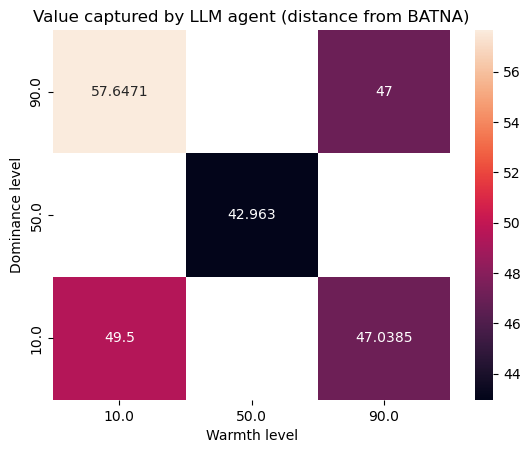

In [492]:
ax = sns.heatmap(df_summary.pivot(columns="TREATMENT_warmth_level", index="TREATMENT_dom_level", values="LLM_captured_value"),
            annot=True, fmt='g')
ax.invert_yaxis()

plt.title("Value captured by LLM agent (distance from BATNA)")
plt.ylabel("Dominance level")
plt.xlabel("Warmth level")

Text(0.5, 23.52222222222222, 'Warmth level')

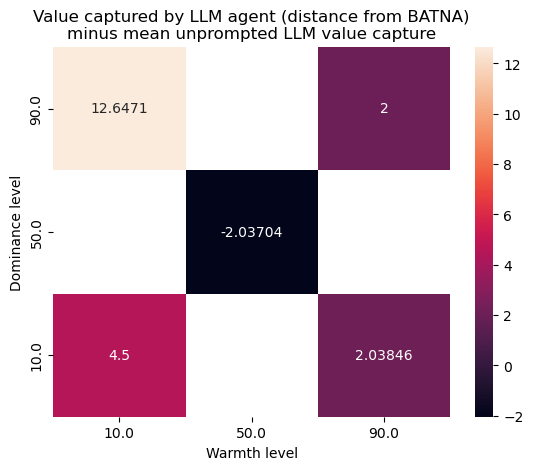

In [493]:
ax = sns.heatmap(df_summary.pivot(columns="TREATMENT_warmth_level", index="TREATMENT_dom_level", values="LLM_captured_value") - df_games.query("treatmentName in ['LLM Buyer (Control)', 'LLM Seller (Control)']", engine="python")["LLM_captured_value"].mean(),
            annot=True, fmt='g')
ax.invert_yaxis()

plt.title("Value captured by LLM agent (distance from BATNA)\nminus mean unprompted LLM value capture")
plt.ylabel("Dominance level")
plt.xlabel("Warmth level")

Text(0.5, 23.52222222222222, 'Warmth level')

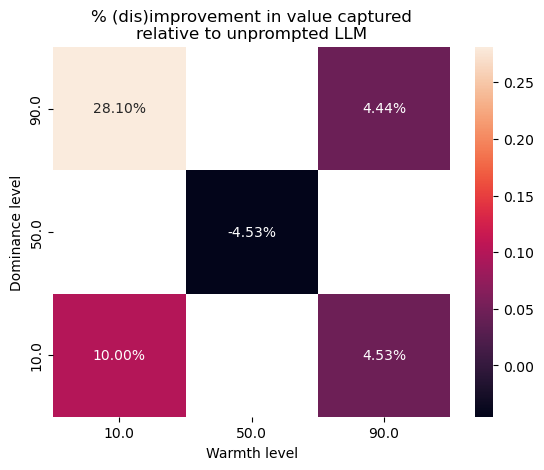

In [494]:
ax = sns.heatmap((df_summary.pivot(columns="TREATMENT_warmth_level", index="TREATMENT_dom_level", values="LLM_captured_value") - df_games.query("treatmentName in ['LLM Buyer (Control)', 'LLM Seller (Control)']", engine="python")["LLM_captured_value"].mean())/df_games.query("treatmentName in ['LLM Buyer (Control)', 'LLM Seller (Control)']", engine="python")["LLM_captured_value"].mean(),
            annot=True, fmt='.2%')
ax.invert_yaxis()

plt.title("% (dis)improvement in value captured\nrelative to unprompted LLM")
plt.ylabel("Dominance level")
plt.xlabel("Warmth level")

## Partner ratings 

In [513]:
for partner_rating in ["PARTNER_assertive", "PARTNER_empathy","PARTNER_warm","PARTNER_dominant"]:
    # display(smf.ols(f"{partner_rating} ~ C(symmetric_treatment_name, Treatment(reference='Control'))", data=df_games).fit().summary())
    display(smf.ols(f"{partner_rating} ~ C(TREATMENT_dom_level_str, Treatment(reference='Control')) + C(TREATMENT_warmth_level_str, Treatment(reference='Control'))",
        data=df_games).fit().summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      PARTNER_assertive   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.3578
Date:                Thu, 07 Dec 2023   Prob (F-statistic):              0.838
Time:                        16:02:31   Log-Likelihood:                -246.45
No. Observations:                 173   AIC:                             502.9
Df Residuals:                     168   BIC:                             518.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 3.0000      0.190     15.831      0.000       2.626       3.374
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.10.0]        0.0077      0.141      0.054      0.957      -0.271       0.286
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.50.0]        0.0690      0.134      0.515      0.607      -0.196       0.334
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.90.0]        0.1437      0.144      0.998      0.320      -0.140       0.428
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.10.0]     0.1384      0.143      0.970      0.334      -0.143       0.420
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.50.0]     0.0690      0.134      0.515      0.607      -0.196       0.334
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.90.0]     0.0129      0.142      0.091      0.928      -0.268       0.294
==============================================================================
Omnibus:                        2.535   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.282   Jarque-Bera (JB):                2.589
Skew:                          -0.282   Prob(JB):                        0.274
Kurtosis:                       2.799   Cond. No.                     1.04e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.46e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        PARTNER_empathy   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.143
Date:                Thu, 07 Dec 2023   Prob (F-statistic):             0.0776
Time:                        16:02:31   Log-Likelihood:                -238.24
No. Observations:                 173   AIC:                             486.5
Df Residuals:                     168   BIC:                             502.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 2.4483      0.181     13.547      0.000       2.092       2.805
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.10.0]        0.2378      0.135      1.766      0.079      -0.028       0.504
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.50.0]        0.1034      0.128      0.810      0.419      -0.149       0.356
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.90.0]       -0.2099      0.137     -1.529      0.128      -0.481       0.061
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.10.0]    -0.1056      0.136     -0.775      0.439      -0.374       0.163
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.50.0]     0.1034      0.128      0.810      0.419      -0.149       0.356
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.90.0]     0.1335      0.136      0.984      0.326      -0.134       0.401
==============================================================================
Omnibus:                        3.335   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.189   Jarque-Bera (JB):                3.394
Skew:                           0.325   Prob(JB):                        0.183
Kurtosis:                       2.782   Cond. No.                     1.04e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.46e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           PARTNER_warm   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.6969
Date:                Thu, 07 Dec 2023   Prob (F-statistic):              0.595
Time:                        16:02:31   Log-Likelihood:                -251.83
No. Observations:                 173   AIC:                             513.7
Df Residuals:                     168   BIC:                             529.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 2.5862      0.195     13.230      0.000       2.200       2.972
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.10.0]        0.1605      0.146      1.102      0.272      -0.127       0.448
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.50.0]        0.0345      0.138      0.249      0.803      -0.238       0.307
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.90.0]       -0.1539      0.148     -1.036      0.302      -0.447       0.139
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.10.0]    -0.0364      0.147     -0.247      0.805      -0.327       0.254
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.50.0]     0.0345      0.138      0.249      0.803      -0.238       0.307
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.90.0]     0.0430      0.147      0.293      0.770      -0.247       0.333
==============================================================================
Omnibus:                        5.125   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                4.261
Skew:                           0.288   Prob(JB):                        0.119
Kurtosis:                       2.492   Cond. No.                     1.04e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.46e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       PARTNER_dominant   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.750
Date:                Thu, 07 Dec 2023   Prob (F-statistic):              0.141
Time:                        16:02:31   Log-Likelihood:                -253.30
No. Observations:                 173   AIC:                             516.6
Df Residuals:                     168   BIC:                             532.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 2.2759      0.197     11.543      0.000       1.887       2.665
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.10.0]        0.0188      0.147      0.128      0.898      -0.271       0.309
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.50.0]        0.1897      0.139      1.360      0.176      -0.086       0.465
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.90.0]        0.3920      0.150      2.618      0.010       0.096       0.688
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.10.0]     0.2303      0.149      1.551      0.123      -0.063       0.524
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.50.0]     0.1897      0.139      1.360      0.176      -0.086       0.465
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.90.0]     0.1804      0.148      1.219      0.224      -0.112       0.472
==============================================================================
Omnibus:                        4.459   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                3.597
Skew:                           0.245   Prob(JB):                        0.166
Kurtosis:                       2.491   Cond. No.                     1.04e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.46e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

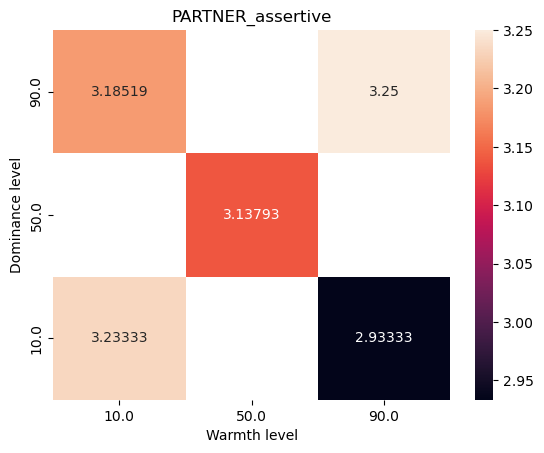

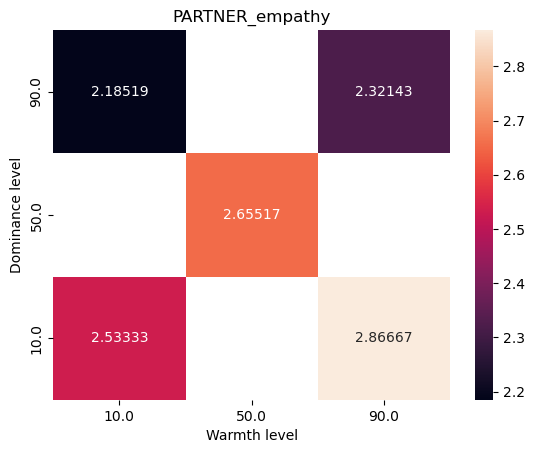

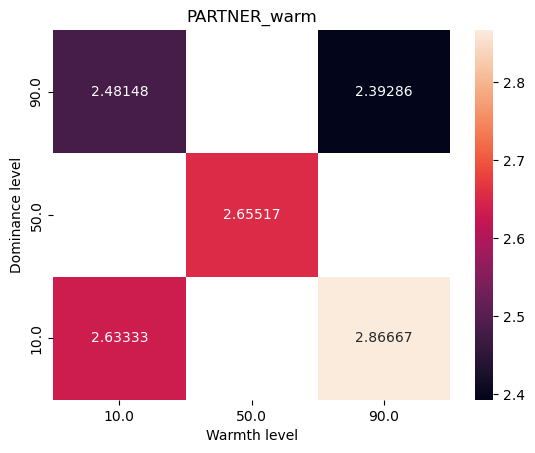

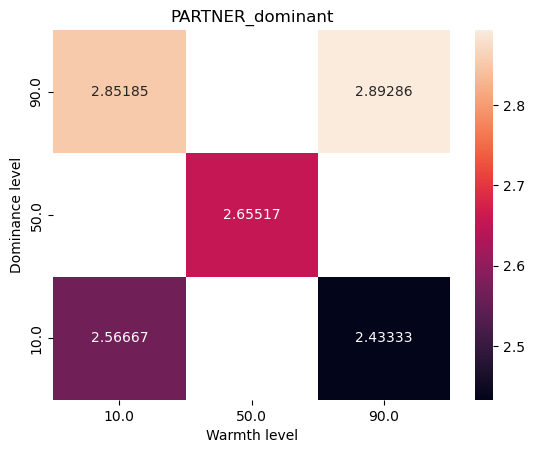

In [495]:
for partner_rating in ["PARTNER_assertive", "PARTNER_empathy","PARTNER_warm","PARTNER_dominant"]:
    ax = sns.heatmap(df_summary.pivot(columns="TREATMENT_warmth_level", index="TREATMENT_dom_level", values=partner_rating),
                annot=True, fmt='g')
    ax.invert_yaxis()

    plt.title(partner_rating)
    plt.ylabel("Dominance level")
    plt.xlabel("Warmth level")
    plt.show()

## SVI 

In [500]:
for svi_dim in ["SVI_outcome","SVI_oneself","SVI_process","SVI_relationship","SVI_global"]:
    display(smf.ols(f"{svi_dim} ~ C(symmetric_treatment_name, Treatment(reference='Control'))", data=df_games).fit().summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            SVI_outcome   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     4.396
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           0.000869
Time:                        15:52:48   Log-Likelihood:                -540.53
No. Observations:                 174   AIC:                             1093.
Df Residuals:                     168   BIC:                             1112.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================================
                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                   21.1379      1.022     20.689      0.000      19.121      23.155
C(symmetric_treatment_name, Treatment(reference='Control'))[T.10% Warmth, 10% Dominance]    -0.5713      1.433     -0.399      0.691      -3.400       2.257
C(symmetric_treatment_name, Treatment(reference='Control'))[T.10% Warmth, 90% Dominance]    -3.9594      1.458     -2.716      0.007      -6.837      -1.081
C(symmetric_treatment_name, Treatment(reference='Control'))[T.50% Warmth, 50% Dominance]     1.8621      1.445      1.289      0.199      -0.990       4.715
C(symmetric_treatment_name, Treatment(reference='Control'))[T.90% Warmth, 10% Dominance]    -0.6713      1.433     -0.468      0.640      -3.500       2.157
C(symmetric_treatment_name, Treatment(reference='Control'))[T.90% Warmth, 90% Dominance]    -3.2808      1.458     -2.251      0.026      -6.159      -0.403
==============================================================================
Omnibus:                       15.027   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.752
Skew:                          -0.757   Prob(JB):                     0.000230
Kurtosis:                       3.129   Cond. No.                         6.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            SVI_oneself   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.546
Date:                Thu, 07 Dec 2023   Prob (F-statistic):             0.0300
Time:                        15:52:48   Log-Likelihood:                -493.05
No. Observations:                 173   AIC:                             998.1
Df Residuals:                     167   BIC:                             1017.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================================
                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                   20.9655      0.791     26.518      0.000      19.405      22.526
C(symmetric_treatment_name, Treatment(reference='Control'))[T.10% Warmth, 10% Dominance]    -0.4322      1.109     -0.390      0.697      -2.621       1.757
C(symmetric_treatment_name, Treatment(reference='Control'))[T.10% Warmth, 90% Dominance]    -2.2989      1.139     -2.019      0.045      -4.547      -0.051
C(symmetric_treatment_name, Treatment(reference='Control'))[T.50% Warmth, 50% Dominance]     1.0345      1.118      0.925      0.356      -1.173       3.242
C(symmetric_treatment_name, Treatment(reference='Control'))[T.90% Warmth, 10% Dominance]    -0.3989      1.109     -0.360      0.720      -2.588       1.790
C(symmetric_treatment_name, Treatment(reference='Control'))[T.90% Warmth, 90% Dominance]    -2.1084      1.128     -1.869      0.063      -4.335       0.119
==============================================================================
Omnibus:                       23.255   Durbin-Watson:                   2.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.831
Skew:                          -0.793   Prob(JB):                     1.22e-07
Kurtosis:                       4.378   Cond. No.                         6.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            SVI_process   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     4.710
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           0.000473
Time:                        15:52:48   Log-Likelihood:                -541.28
No. Observations:                 174   AIC:                             1095.
Df Residuals:                     168   BIC:                             1114.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================================
                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                   21.2759      1.026     20.735      0.000      19.250      23.302
C(symmetric_treatment_name, Treatment(reference='Control'))[T.10% Warmth, 10% Dominance]    -1.4092      1.439     -0.979      0.329      -4.250       1.432
C(symmetric_treatment_name, Treatment(reference='Control'))[T.10% Warmth, 90% Dominance]    -5.2759      1.464     -3.604      0.000      -8.166      -2.386
C(symmetric_treatment_name, Treatment(reference='Control'))[T.50% Warmth, 50% Dominance]     0.4483      1.451      0.309      0.758      -2.416       3.313
C(symmetric_treatment_name, Treatment(reference='Control'))[T.90% Warmth, 10% Dominance]     0.1241      1.439      0.086      0.931      -2.717       2.965
C(symmetric_treatment_name, Treatment(reference='Control'))[T.90% Warmth, 90% Dominance]    -3.0259      1.464     -2.067      0.040      -5.916      -0.136
==============================================================================
Omnibus:                       13.464   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.243
Skew:                          -0.669   Prob(JB):                     0.000808
Kurtosis:                       3.416   Cond. No.                         6.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       SVI_relationship   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     4.655
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           0.000527
Time:                        15:52:48   Log-Likelihood:                -546.78
No. Observations:                 173   AIC:                             1106.
Df Residuals:                     167   BIC:                             1124.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================================
                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                   20.8276      1.079     19.310      0.000      18.698      22.957
C(symmetric_treatment_name, Treatment(reference='Control'))[T.10% Warmth, 10% Dominance]    -2.3609      1.513     -1.561      0.120      -5.347       0.625
C(symmetric_treatment_name, Treatment(reference='Control'))[T.10% Warmth, 90% Dominance]    -5.7905      1.553     -3.728      0.000      -8.857      -2.724
C(symmetric_treatment_name, Treatment(reference='Control'))[T.50% Warmth, 50% Dominance]    -0.0690      1.525     -0.045      0.964      -3.080       2.943
C(symmetric_treatment_name, Treatment(reference='Control'))[T.90% Warmth, 10% Dominance]    -0.9609      1.513     -0.635      0.526      -3.947       2.025
C(symmetric_treatment_name, Treatment(reference='Control'))[T.90% Warmth, 90% Dominance]    -4.2562      1.539     -2.766      0.006      -7.294      -1.218
==============================================================================
Omnibus:                        9.552   Durbin-Watson:                   2.250
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.756
Skew:                          -0.577   Prob(JB):                      0.00761
Kurtosis:                       3.152   Cond. No.                         6.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SVI_global   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     4.795
Date:                Thu, 07 Dec 2023   Prob (F-statistic):           0.000404
Time:                        15:52:48   Log-Likelihood:                -507.30
No. Observations:                 172   AIC:                             1027.
Df Residuals:                     166   BIC:                             1045.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================================
                                                                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                   21.0517      0.873     24.105      0.000      19.327      22.776
C(symmetric_treatment_name, Treatment(reference='Control'))[T.10% Warmth, 10% Dominance]    -1.1934      1.225     -0.974      0.331      -3.612       1.225
C(symmetric_treatment_name, Treatment(reference='Control'))[T.10% Warmth, 90% Dominance]    -4.2921      1.270     -3.379      0.001      -6.800      -1.784
C(symmetric_treatment_name, Treatment(reference='Control'))[T.50% Warmth, 50% Dominance]     0.8190      1.235      0.663      0.508      -1.620       3.258
C(symmetric_treatment_name, Treatment(reference='Control'))[T.90% Warmth, 10% Dominance]    -0.4767      1.225     -0.389      0.698      -2.895       1.941
C(symmetric_treatment_name, Treatment(reference='Control'))[T.90% Warmth, 90% Dominance]    -3.1678      1.246     -2.542      0.012      -5.628      -0.708
==============================================================================
Omnibus:                       12.316   Durbin-Watson:                   2.206
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.924
Skew:                          -0.656   Prob(JB):                      0.00156
Kurtosis:                       3.285   Cond. No.                         6.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

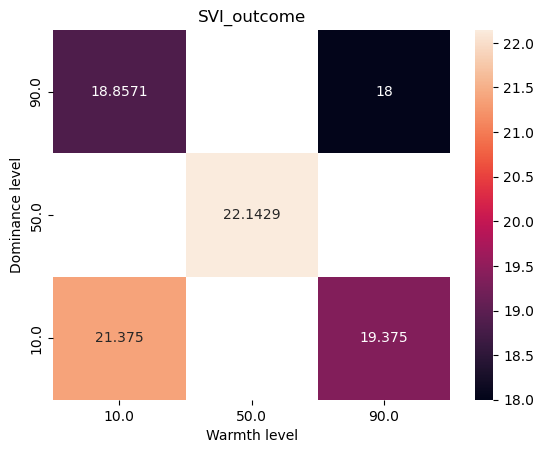

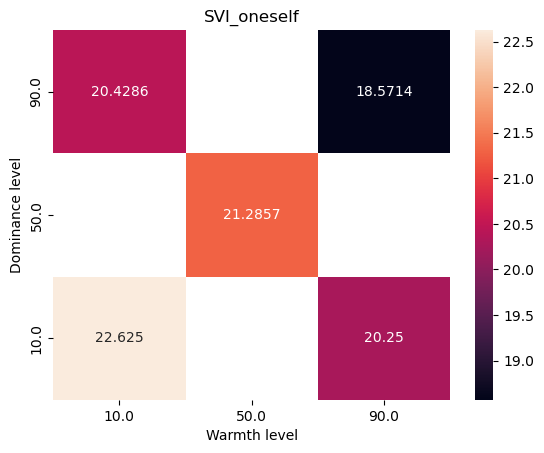

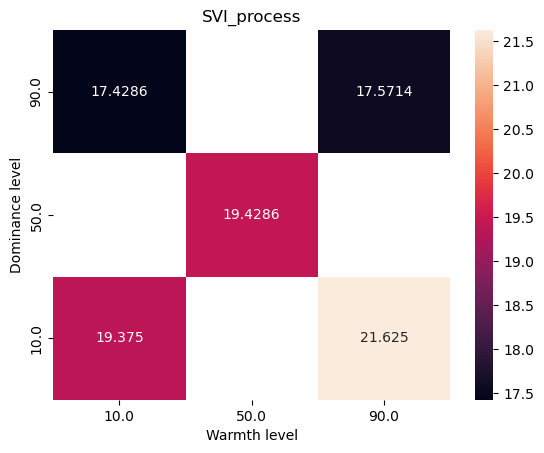

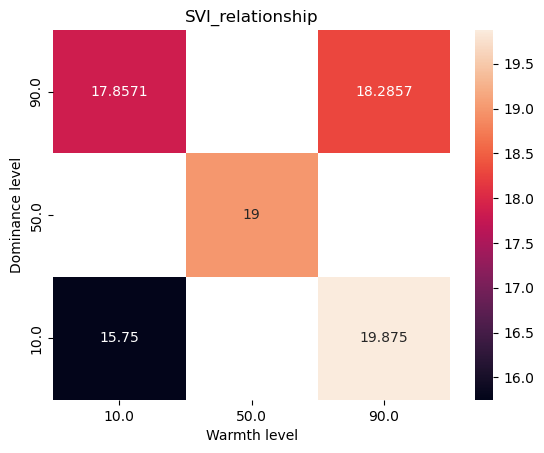

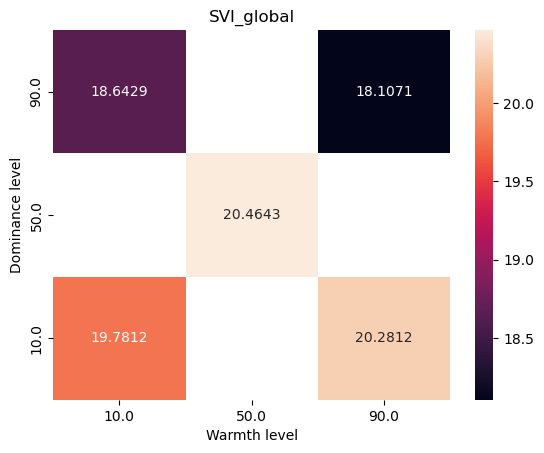

In [227]:
for svi_dim in ["SVI_outcome","SVI_oneself","SVI_process","SVI_relationship","SVI_global"]:
    ax = sns.heatmap(df_summary.pivot(columns="TREATMENT_warmth_level", index="TREATMENT_dom_level", values=svi_dim),
                annot=True, fmt='g')
    ax.invert_yaxis()

    plt.title(svi_dim)
    plt.ylabel("Dominance level")
    plt.xlabel("Warmth level")
    plt.show()

# Regressions

## Partner probit models (manipulation check)

In [778]:
list_probit_models= []
for partner_rating in ["PARTNER_assertive_cat", "PARTNER_empathy_cat","PARTNER_warm_cat","PARTNER_dominant_cat"]:
    ordered_prob_model = OrderedModel.from_formula(f"{partner_rating} ~ TREATMENT_dom_level + TREATMENT_warmth_level", 
                          data=df_games.dropna(subset=[partner_rating, "TREATMENT_dom_level", "TREATMENT_warmth_level"]),
                          distr="probit").fit()
    
    list_probit_models.append(pd.read_html(ordered_prob_model.summary().tables[1].as_html(), header=0)[0].rename(columns={"Unnamed: 0":"param"}).assign(outcome=partner_rating))

df_manip_reg = pd.concat(list_probit_models, ignore_index=True).query("param == 'TREATMENT_dom_level' or param == 'TREATMENT_warmth_level'")
df_manip_reg["param"] = df_manip_reg["param"].map({'TREATMENT_dom_level':"Dominance", 'TREATMENT_warmth_level':"Warmth"})
df_manip_reg["Perceived behavior"] = df_manip_reg["outcome"].map(dict(zip(["PARTNER_assertive_cat", "PARTNER_empathy_cat","PARTNER_warm_cat","PARTNER_dominant_cat"],
                                                                         ["Assertion", "Empathy","Warmth","Dominance"])))

Optimization terminated successfully.
         Current function value: 1.411449
         Iterations: 300
         Function evaluations: 465
Optimization terminated successfully.
         Current function value: 1.308066
         Iterations: 279
         Function evaluations: 438
Optimization terminated successfully.
         Current function value: 1.415894
         Iterations: 471
         Function evaluations: 726
Optimization terminated successfully.
         Current function value: 1.439026
         Iterations: 223
         Function evaluations: 348


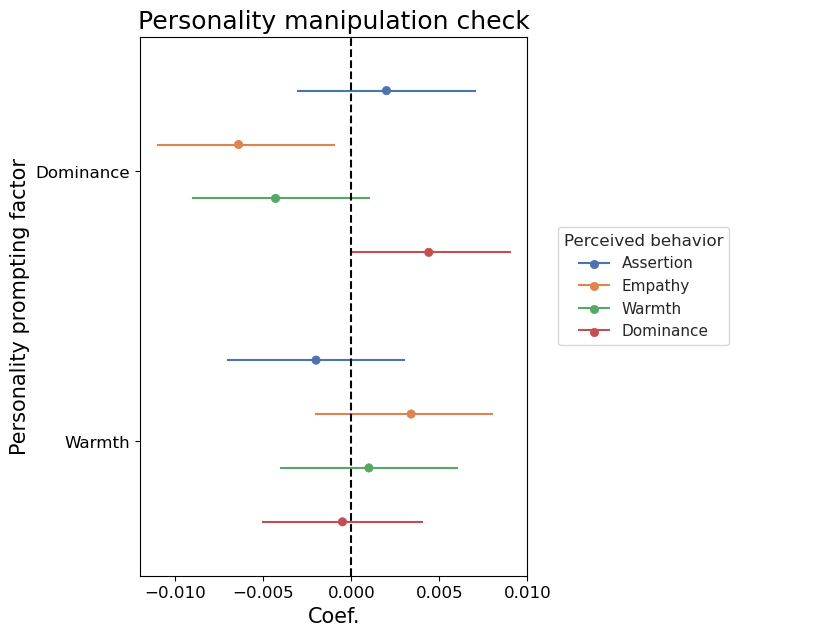

In [856]:
f,ax = plt.subplots(figsize=(5,7))


(so.Plot(x="coef", y="param", color="Perceived behavior", xmin="[0.025", xmax="0.975]", data=df_manip_reg)
 .add(so.Dot(), so.Dodge(by=["color"]))
 .add(so.Range(), so.Dodge(by=["color"]))
 .theme({"axes.facecolor": "w", "axes.edgecolor": "slategray"})
 .label(x="Coef.", y="Personality prompting factor", title="Personality manipulation check",fontdict={'fontsize': 30})
 .on(ax)
 .plot())

ax.axvline(0, color="black", linestyle="--")
ax.tick_params(labelsize=12)
ax.set_xlabel("Coef.",fontsize=15)
ax.set_ylabel("Personality prompting factor",fontsize=15)
ax.set_title("Personality manipulation check", fontsize=18)
f.legends[0].set_bbox_to_anchor((1.1, 0.5))

# # legend = list(f.legends)[0]
# legend = f.legends.pop(0)
# ax.legend = legend

In [659]:
for partner_rating in ["PARTNER_assertive_cat", "PARTNER_empathy_cat","PARTNER_warm_cat","PARTNER_dominant_cat"]:
    display(Markdown(f"# {partner_rating}"))
    display(OrderedModel.from_formula(f"{partner_rating} ~ TREATMENT_dom_level + TREATMENT_warmth_level", 
                          data=df_games.dropna(subset=[partner_rating, "TREATMENT_dom_level", "TREATMENT_warmth_level"]),
                          distr="probit").fit().summary())

# PARTNER_assertive_cat

Optimization terminated successfully.
         Current function value: 1.411449
         Iterations: 300
         Function evaluations: 465


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OrderedModel Results                              
=================================================================================
Dep. Variable:     PARTNER_assertive_cat   Log-Likelihood:                -203.25
Model:                      OrderedModel   AIC:                             418.5
Method:               Maximum Likelihood   BIC:                             436.3
Date:                   Thu, 07 Dec 2023                                         
Time:                           22:16:52                                         
No. Observations:                    144                                         
Df Residuals:                        138                                         
Df Model:                              6                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
TREATMENT_dom_level        0.0020      0.002      0.797      0.425      -0.003       0.007
TREATMENT_warmth_level    -0.0020      0.002     -0.800      0.424      -0.007       0.003
1/2                       -1.4349      0.228     -6.297      0.000      -1.881      -0.988
2/3                       -0.3500      0.192     -1.820      0.069      -0.727       0.027
3/4                        0.0252      0.115      0.219      0.827      -0.201       0.251
4/5                        0.1341      0.135      0.996      0.319      -0.130       0.398
==========================================================================================
"""

# PARTNER_empathy_cat

Optimization terminated successfully.
         Current function value: 1.308066
         Iterations: 279
         Function evaluations: 438


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                             
===============================================================================
Dep. Variable:     PARTNER_empathy_cat   Log-Likelihood:                -188.36
Model:                    OrderedModel   AIC:                             388.7
Method:             Maximum Likelihood   BIC:                             406.5
Date:                 Thu, 07 Dec 2023                                         
Time:                         22:16:52                                         
No. Observations:                  144                                         
Df Residuals:                      138                                         
Df Model:                            6                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
TREATMENT_dom_level       -0.0064      0.003     -2.548      0.011      -0.011      -0.001
TREATMENT_warmth_level     0.0034      0.002      1.354      0.176      -0.002       0.008
1/2                       -1.1746      0.219     -5.375      0.000      -1.603      -0.746
2/3                       -0.0467      0.133     -0.353      0.724      -0.306       0.213
3/4                        0.2581      0.110      2.343      0.019       0.042       0.474
4/5                       -0.3135      0.267     -1.175      0.240      -0.836       0.210
==========================================================================================
"""

# PARTNER_warm_cat

Optimization terminated successfully.
         Current function value: 1.415894
         Iterations: 471
         Function evaluations: 726


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:       PARTNER_warm_cat   Log-Likelihood:                -203.89
Model:                   OrderedModel   AIC:                             419.8
Method:            Maximum Likelihood   BIC:                             437.6
Date:                Thu, 07 Dec 2023                                         
Time:                        22:16:52                                         
No. Observations:                 144                                         
Df Residuals:                     138                                         
Df Model:                           6                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
TREATMENT_dom_level       -0.0043      0.002     -1.732      0.083      -0.009       0.001
TREATMENT_warmth_level     0.0010      0.002      0.400      0.689      -0.004       0.006
1/2                       -1.2282      0.218     -5.622      0.000      -1.656      -0.800
2/3                        0.0231      0.126      0.184      0.854      -0.224       0.270
3/4                       -0.1109      0.129     -0.862      0.389      -0.363       0.141
4/5                       -0.0274      0.193     -0.142      0.887      -0.406       0.351
==========================================================================================
"""

# PARTNER_dominant_cat

Optimization terminated successfully.
         Current function value: 1.439026
         Iterations: 223
         Function evaluations: 348


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OrderedModel Results                              
================================================================================
Dep. Variable:     PARTNER_dominant_cat   Log-Likelihood:                -207.22
Model:                     OrderedModel   AIC:                             426.4
Method:              Maximum Likelihood   BIC:                             444.3
Date:                  Thu, 07 Dec 2023                                         
Time:                          22:16:52                                         
No. Observations:                   144                                         
Df Residuals:                       138                                         
Df Model:                             6                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
TREATMENT_dom_level        0.0044      0.002      1.790      0.073      -0.000       0.009
TREATMENT_warmth_level    -0.0005      0.002     -0.222      0.825      -0.005       0.004
1/2                       -0.8837      0.208     -4.246      0.000      -1.292      -0.476
2/3                       -0.0161      0.129     -0.125      0.900      -0.269       0.237
3/4                       -0.2552      0.138     -1.851      0.064      -0.525       0.015
4/5                        0.1330      0.170      0.784      0.433      -0.200       0.466
==========================================================================================
"""

## Negotiation outcome and dealmaking 

In [911]:
# Price, LLM is buyer 
# smf.ols("price ~ TREATMENT_warmth_level + TREATMENT_dom_level", data=df_games.query("TREATMENT_llm_role == 'buyer'")).fit().summary()
smf.ols("price ~ C(TREATMENT_warmth_level_str, Treatment(reference='Control')) + C(TREATMENT_dom_level_str, Treatment(reference='Control'))", data=df_games.query("TREATMENT_llm_role == 'buyer'")).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.8896
Date:                Fri, 08 Dec 2023   Prob (F-statistic):              0.476
Time:                        00:15:35   Log-Likelihood:                -304.30
No. Observations:                  66   AIC:                             618.6
Df Residuals:                      61   BIC:                             629.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               175.3571      6.763     25.929      0.000     161.834     188.880
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.10.0]    -5.3513      5.869     -0.912      0.365     -17.086       6.384
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.50.0]     4.8214      4.873      0.989      0.326      -4.923      14.566
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.90.0]     1.5357      5.514      0.278      0.782      -9.491      12.562
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.10.0]        0.4246      5.514      0.077      0.939     -10.602      11.451
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.50.0]        4.8214      4.873      0.989      0.326      -4.923      14.566
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.90.0]       -4.2401      5.869     -0.723      0.473     -15.975       7.495
==============================================================================
Omnibus:                        3.151   Durbin-Watson:                   2.155
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                2.291
Skew:                          -0.391   Prob(JB):                        0.318
Kurtosis:                       3.472   Cond. No.                     1.09e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.22e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [910]:
# Price, LLM is seller 
# smf.ols("price ~ TREATMENT_warmth_level + TREATMENT_dom_level", data=df_games.query("TREATMENT_llm_role == 'seller'")).fit().summary()
smf.ols("price ~ C(TREATMENT_warmth_level_str, Treatment(reference='Control')) + C(TREATMENT_dom_level_str, Treatment(reference='Control'))", data=df_games.query("TREATMENT_llm_role == 'seller'")).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.055
Method:                 Least Squares   F-statistic:                   0.07178
Date:                Fri, 08 Dec 2023   Prob (F-statistic):              0.990
Time:                        00:15:31   Log-Likelihood:                -337.16
No. Observations:                  72   AIC:                             684.3
Df Residuals:                      67   BIC:                             695.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               165.3571      7.245     22.825      0.000     150.897     179.817
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.10.0]     3.1482      5.979      0.527      0.600      -8.786      15.082
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.50.0]     1.4286      5.123      0.279      0.781      -8.796      11.653
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.90.0]    -0.1062      5.715     -0.019      0.985     -11.513      11.301
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.10.0]        1.2574      5.715      0.220      0.827     -10.150      12.665
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.50.0]        1.4286      5.123      0.279      0.781      -8.796      11.653
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.90.0]        1.7846      5.979      0.298      0.766     -10.150      13.719
==============================================================================
Omnibus:                        2.603   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.272   Jarque-Bera (JB):                1.838
Skew:                           0.332   Prob(JB):                        0.399
Kurtosis:                       3.414   Cond. No.                     2.85e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.33e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [932]:
# Captured value
smf.ols("LLM_captured_value ~ TREATMENT_warmth_level + TREATMENT_dom_level", data=df_games).fit().summary()
# smf.ols("LLM_captured_value ~ C(TREATMENT_warmth_level_str, Treatment(reference='Control')) + C(TREATMENT_dom_level_str, Treatment(reference='Control'))", data=df_games).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     LLM_captured_value   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.2898
Date:                Fri, 08 Dec 2023   Prob (F-statistic):              0.749
Time:                        01:22:11   Log-Likelihood:                -559.73
No. Observations:                 110   AIC:                             1125.
Df Residuals:                     107   BIC:                             1134.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 50.0486      8.744      5.724      0.000      32.715      67.382
TREATMENT_warmth_level    -0.0718      0.110     -0.655      0.514      -0.289       0.146
TREATMENT_dom_level        0.0406      0.110      0.370      0.712      -0.177       0.258
==============================================================================
Omnibus:                        1.746   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.418   Jarque-Bera (JB):                1.590
Skew:                           0.177   Prob(JB):                        0.452
Kurtosis:                       2.529   Cond. No.                         181.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [942]:
# smf.ols("LLM_captured_value_imputed ~ TREATMENT_warmth_level + TREATMENT_dom_level", data=df_games).fit().summary()
# smf.ols("price_imputed ~ TREATMENT_warmth_level + TREATMENT_dom_level", data=df_games.query("TREATMENT_llm_role == 'buyer'")).fit().summary()
smf.ols("price_imputed ~ TREATMENT_warmth_level + TREATMENT_dom_level", data=df_games.query("TREATMENT_llm_role == 'seller'")).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          price_imputed   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.5013
Date:                Fri, 08 Dec 2023   Prob (F-statistic):              0.608
Time:                        01:35:09   Log-Likelihood:                -370.20
No. Observations:                  73   AIC:                             746.4
Df Residuals:                      70   BIC:                             753.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                150.6845     10.150     14.846      0.000     130.442     170.927
TREATMENT_warmth_level     0.1043      0.129      0.807      0.422      -0.154       0.362
TREATMENT_dom_level       -0.0767      0.129     -0.593      0.555      -0.335       0.181
==============================================================================
Omnibus:                        0.382   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.826   Jarque-Bera (JB):                0.545
Skew:                          -0.126   Prob(JB):                        0.761
Kurtosis:                       2.660   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [929]:
smf.ols("negotiation_length_mins ~ TREATMENT_warmth_level + TREATMENT_dom_level", 
        data=df_games.query("treatmentName != 'Human vs. Human'")).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     negotiation_length_mins   R-squared:                       0.006
Model:                                 OLS   Adj. R-squared:                 -0.008
Method:                      Least Squares   F-statistic:                    0.4583
Date:                     Fri, 08 Dec 2023   Prob (F-statistic):              0.633
Time:                             00:51:02   Log-Likelihood:                -284.55
No. Observations:                      146   AIC:                             575.1
Df Residuals:                          143   BIC:                             584.1
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2.2362      0.313      7.147      0.000       1.618       2.855
TREATMENT_warmth_level     0.0027      0.004      0.687      0.493      -0.005       0.011
TREATMENT_dom_level        0.0027      0.004      0.673      0.502      -0.005       0.011
==============================================================================
Omnibus:                       67.113   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.185
Skew:                           1.838   Prob(JB):                     4.59e-45
Kurtosis:                       7.478   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [928]:
smf.ols("negotiation_length_messages ~ TREATMENT_warmth_level + TREATMENT_dom_level", 
        data=df_games.query("treatmentName != 'Human vs. Human'")).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     negotiation_length_messages   R-squared:                       0.015
Model:                                     OLS   Adj. R-squared:                  0.002
Method:                          Least Squares   F-statistic:                     1.114
Date:                         Fri, 08 Dec 2023   Prob (F-statistic):              0.331
Time:                                 00:50:45   Log-Likelihood:                -334.39
No. Observations:                          146   AIC:                             674.8
Df Residuals:                              143   BIC:                             683.7
Df Model:                                    2                                         
Covariance Type:                     nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7.4478      0.440     16.920      0.000       6.578       8.318
TREATMENT_warmth_level     0.0054      0.006      0.963      0.337      -0.006       0.016
TREATMENT_dom_level       -0.0063      0.006     -1.132      0.259      -0.017       0.005
==============================================================================
Omnibus:                       71.253   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              433.599
Skew:                           1.617   Prob(JB):                     7.00e-95
Kurtosis:                      10.798   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [922]:
df_games.groupby(["TREATMENT_warmth_level_str", "TREATMENT_dom_level_str"])["deal_reached"].mean()

TREATMENT_warmth_level_str  TREATMENT_dom_level_str
10.0                        10.0                       0.666667
                            90.0                       0.586207
50.0                        50.0                       0.931034
90.0                        10.0                       0.866667
                            90.0                       0.714286
Control                     Control                    0.912281
Name: deal_reached, dtype: float64

In [923]:
display(smf.ols("deal_reached ~ C(TREATMENT_warmth_level_str, Treatment(reference='Control')) + C(TREATMENT_dom_level_str, Treatment(reference='Control'))", 
        data=df_games.query("treatmentName != 'Human vs. Human'")).fit().summary())

display(smf.logit("deal_reached ~ C(TREATMENT_warmth_level_str, Treatment(reference='Control')) + C(TREATMENT_dom_level_str, Treatment(reference='Control'))", 
        data=df_games.query("TREATMENT_warmth_level != 50 and treatmentName != 'Human vs. Human'")).fit_regularized().summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           deal_reached   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     5.661
Date:                Fri, 08 Dec 2023   Prob (F-statistic):           0.000266
Time:                        00:30:24   Log-Likelihood:                -80.625
No. Observations:                 175   AIC:                             171.2
Df Residuals:                     170   BIC:                             187.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 0.9655      0.072     13.360      0.000       0.823       1.108
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.10.0]    -0.2109      0.054     -3.908      0.000      -0.317      -0.104
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.50.0]    -0.0172      0.051     -0.337      0.736      -0.118       0.084
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.90.0]    -0.0460      0.054     -0.848      0.397      -0.153       0.061
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.10.0]       -0.0704      0.054     -1.309      0.192      -0.177       0.036
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.50.0]       -0.0172      0.051     -0.337      0.736      -0.118       0.084
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.90.0]       -0.1865      0.054     -3.429      0.001      -0.294      -0.079
==============================================================================
Omnibus:                       27.216   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.466
Skew:                          -1.118   Prob(JB):                     1.21e-08
Kurtosis:                       2.933   Cond. No.                     1.98e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.9e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.49243285994754804
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           deal_reached   No. Observations:                  146
Model:                          Logit   Df Residuals:                      141
Method:                           MLE   Df Model:                            4
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:                  0.1059
Time:                        00:30:24   Log-Likelihood:                -71.895
converged:                       True   LL-Null:                       -80.412
Covariance Type:            nonrobust   LLR p-value:                  0.001905
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 3.3322      1.018      3.274      0.001       1.338       5.327
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.10.0]    -1.5545   1.53e+07  -1.02e-07      1.000   -2.99e+07    2.99e+07
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.90.0]    -0.7215   1.53e+07  -4.73e-08      1.000   -2.99e+07    2.99e+07
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.10.0]       -0.9583   1.53e+07  -6.28e-08      1.000   -2.99e+07    2.99e+07
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.90.0]       -1.5454   1.53e+07  -1.01e-07      1.000   -2.99e+07    2.99e+07
=========================================================================================================================================
"""

In [894]:
smf.logit("deal_reached ~ TREATMENT_warmth_level + TREATMENT_dom_level", data=df_games).fit().summary()

Optimization terminated successfully.
         Current function value: 0.536095
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           deal_reached   No. Observations:                  146
Model:                          Logit   Df Residuals:                      143
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:                 0.04019
Time:                        00:10:29   Log-Likelihood:                -78.270
converged:                       True   LL-Null:                       -81.547
Covariance Type:            nonrobust   LLR p-value:                   0.03773
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.9943      0.424      2.345      0.019       0.163       1.825
TREATMENT_warmth_level     0.0116      0.006      2.069      0.039       0.001       0.023
TREATMENT_dom_level       -0.0080      0.006     -1.443      0.149      -0.019       0.003
==========================================================================================
"""

In [906]:
# smf.logit("deal_reached ~ TREATMENT_warmth_level + TREATMENT_dom_level", data=df_games).fit().summary()
smf.logit("deal_reached ~ C(TREATMENT_warmth_level_str, Treatment(reference='Control')) + C(TREATMENT_dom_level_str, Treatment(reference='Control'))", 
          data=df_games.query("TREATMENT_warmth_level != 50 and treatmentName != 'Human vs. Human'")).fit().summary()

Optimization terminated successfully.
         Current function value: 0.492433
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           deal_reached   No. Observations:                  146
Model:                          Logit   Df Residuals:                      142
Method:                           MLE   Df Model:                            3
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:                  0.1059
Time:                        00:14:29   Log-Likelihood:                -71.895
converged:                       True   LL-Null:                       -80.412
Covariance Type:            nonrobust   LLR p-value:                 0.0006959
=========================================================================================================================================
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 3.3322      1.018      3.274      0.001       1.338       5.327
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.10.0]    -1.6114        nan        nan        nan         nan         nan
C(TREATMENT_warmth_level_str, Treatment(reference='Control'))[T.90.0]    -0.7784        nan        nan        nan         nan         nan
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.10.0]       -0.9014        nan        nan        nan         nan         nan
C(TREATMENT_dom_level_str, Treatment(reference='Control'))[T.90.0]       -1.4885        nan        nan        nan         nan         nan
=========================================================================================================================================
"""

In [924]:
smf.logit("deal_reached ~ C(symmetric_treatment_name, Treatment(reference='Control'))", 
          data=df_games.query("treatmentName != 'Human vs. Human'")).fit().summary()

Optimization terminated successfully.
         Current function value: 0.450988
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           deal_reached   No. Observations:                  175
Model:                          Logit   Df Residuals:                      169
Method:                           MLE   Df Model:                            5
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:                  0.1257
Time:                        00:32:28   Log-Likelihood:                -78.923
converged:                       True   LL-Null:                       -90.273
Covariance Type:            nonrobust   LLR p-value:                 0.0003853
============================================================================================================================================================
                                                                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                    3.3322      1.018      3.274      0.001       1.338       5.327
C(symmetric_treatment_name, Treatment(reference='Control'))[T.10% Warmth, 10% Dominance]    -2.6391      1.089     -2.424      0.015      -4.773      -0.505
C(symmetric_treatment_name, Treatment(reference='Control'))[T.10% Warmth, 90% Dominance]    -2.9839      1.085     -2.749      0.006      -5.111      -0.857
C(symmetric_treatment_name, Treatment(reference='Control'))[T.50% Warmth, 50% Dominance]    -0.7295      1.254     -0.582      0.561      -3.187       1.728
C(symmetric_treatment_name, Treatment(reference='Control'))[T.90% Warmth, 10% Dominance]    -1.4604      1.151     -1.269      0.204      -3.716       0.795
C(symmetric_treatment_name, Treatment(reference='Control'))[T.90% Warmth, 90% Dominance]    -2.4159      1.100     -2.196      0.028      -4.573      -0.259
============================================================================================================================================================
"""

In [925]:
smf.logit("deal_reached ~ TREATMENT_warmth_level + TREATMENT_dom_level", 
          data=df_games.query("treatmentName != 'Human vs. Human'")).fit().summary()

Optimization terminated successfully.
         Current function value: 0.536095
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           deal_reached   No. Observations:                  146
Model:                          Logit   Df Residuals:                      143
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:                 0.04019
Time:                        00:35:43   Log-Likelihood:                -78.270
converged:                       True   LL-Null:                       -81.547
Covariance Type:            nonrobust   LLR p-value:                   0.03773
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.9943      0.424      2.345      0.019       0.163       1.825
TREATMENT_warmth_level     0.0116      0.006      2.069      0.039       0.001       0.023
TREATMENT_dom_level       -0.0080      0.006     -1.443      0.149      -0.019       0.003
==========================================================================================
"""

## SVI 

In [927]:
for svi_outcome in ["SVI_outcome","SVI_oneself","SVI_process","SVI_relationship","SVI_global"]:
    display(Markdown(f"# {svi_outcome}"))
    display(smf.ols(f"{svi_outcome} ~ TREATMENT_warmth_level + TREATMENT_dom_level", data=df_games).fit().summary())

# SVI_outcome

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            SVI_outcome   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     3.755
Date:                Fri, 08 Dec 2023   Prob (F-statistic):             0.0257
Time:                        00:41:27   Log-Likelihood:                -459.30
No. Observations:                 145   AIC:                             924.6
Df Residuals:                     142   BIC:                             933.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 21.4820      1.059     20.284      0.000      19.388      23.576
TREATMENT_warmth_level     0.0034      0.013      0.256      0.798      -0.023       0.030
TREATMENT_dom_level       -0.0368      0.013     -2.729      0.007      -0.063      -0.010
==============================================================================
Omnibus:                       12.062   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.433
Skew:                          -0.744   Prob(JB):                      0.00121
Kurtosis:                       2.892   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# SVI_oneself

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            SVI_oneself   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.546
Date:                Fri, 08 Dec 2023   Prob (F-statistic):             0.0820
Time:                        00:41:27   Log-Likelihood:                -407.78
No. Observations:                 144   AIC:                             821.6
Df Residuals:                     141   BIC:                             830.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 21.1580      0.758     27.928      0.000      19.660      22.656
TREATMENT_warmth_level     0.0012      0.010      0.129      0.898      -0.018       0.020
TREATMENT_dom_level       -0.0218      0.010     -2.254      0.026      -0.041      -0.003
==============================================================================
Omnibus:                       21.429   Durbin-Watson:                   2.244
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.926
Skew:                          -0.779   Prob(JB):                     1.17e-07
Kurtosis:                       4.701   Cond. No.                         172.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# SVI_process

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            SVI_process   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     7.150
Date:                Fri, 08 Dec 2023   Prob (F-statistic):            0.00110
Time:                        00:41:27   Log-Likelihood:                -454.45
No. Observations:                 145   AIC:                             914.9
Df Residuals:                     142   BIC:                             923.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 20.4423      1.024     19.958      0.000      18.417      22.467
TREATMENT_warmth_level     0.0235      0.013      1.802      0.074      -0.002       0.049
TREATMENT_dom_level       -0.0434      0.013     -3.325      0.001      -0.069      -0.018
==============================================================================
Omnibus:                        9.461   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.874
Skew:                          -0.639   Prob(JB):                      0.00718
Kurtosis:                       3.051   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# SVI_relationship

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       SVI_relationship   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     5.423
Date:                Fri, 08 Dec 2023   Prob (F-statistic):            0.00538
Time:                        00:41:27   Log-Likelihood:                -457.25
No. Observations:                 144   AIC:                             920.5
Df Residuals:                     141   BIC:                             929.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 19.3034      1.068     18.071      0.000      17.192      21.415
TREATMENT_warmth_level     0.0182      0.014      1.330      0.186      -0.009       0.045
TREATMENT_dom_level       -0.0413      0.014     -3.025      0.003      -0.068      -0.014
==============================================================================
Omnibus:                        6.567   Durbin-Watson:                   2.290
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                6.747
Skew:                          -0.505   Prob(JB):                       0.0343
Kurtosis:                       2.678   Cond. No.                         172.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# SVI_global

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SVI_global   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     5.440
Date:                Fri, 08 Dec 2023   Prob (F-statistic):            0.00530
Time:                        00:41:27   Log-Likelihood:                -424.53
No. Observations:                 143   AIC:                             855.1
Df Residuals:                     140   BIC:                             863.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 20.6125      0.870     23.706      0.000      18.893      22.332
TREATMENT_warmth_level     0.0111      0.011      0.994      0.322      -0.011       0.033
TREATMENT_dom_level       -0.0353      0.011     -3.163      0.002      -0.057      -0.013
==============================================================================
Omnibus:                        8.036   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.433
Skew:                          -0.592   Prob(JB):                       0.0147
Kurtosis:                       2.885   Cond. No.                         172.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [930]:
for svi_outcome in ["SVI_outcome","SVI_oneself","SVI_process","SVI_relationship","SVI_global"]:
    display(Markdown(f"# {svi_outcome}"))
    display(smf.ols(f"{svi_outcome} ~ LLM_captured_value + TREATMENT_warmth_level + TREATMENT_dom_level", data=df_games).fit().summary())

# SVI_outcome

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            SVI_outcome   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     3.626
Date:                Fri, 08 Dec 2023   Prob (F-statistic):             0.0155
Time:                        00:54:31   Log-Likelihood:                -288.15
No. Observations:                 109   AIC:                             584.3
Df Residuals:                     105   BIC:                             595.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 25.0217      0.871     28.724      0.000      23.294      26.749
LLM_captured_value        -0.0084      0.008     -0.987      0.326      -0.025       0.008
TREATMENT_warmth_level    -0.0222      0.010     -2.300      0.023      -0.041      -0.003
TREATMENT_dom_level       -0.0212      0.010     -2.203      0.030      -0.040      -0.002
==============================================================================
Omnibus:                        3.886   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                3.766
Skew:                          -0.453   Prob(JB):                        0.152
Kurtosis:                       2.911   Cond. No.                         243.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# SVI_oneself

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            SVI_oneself   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.088
Date:                Fri, 08 Dec 2023   Prob (F-statistic):              0.358
Time:                        00:54:31   Log-Likelihood:                -271.92
No. Observations:                 108   AIC:                             551.8
Df Residuals:                     104   BIC:                             562.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 22.5996      0.770     29.363      0.000      21.073      24.126
LLM_captured_value        -0.0030      0.007     -0.398      0.691      -0.018       0.012
TREATMENT_warmth_level    -0.0065      0.009     -0.760      0.449      -0.023       0.010
TREATMENT_dom_level       -0.0136      0.009     -1.588      0.115      -0.031       0.003
==============================================================================
Omnibus:                        0.349   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.840   Jarque-Bera (JB):                0.508
Skew:                           0.099   Prob(JB):                        0.776
Kurtosis:                       2.729   Cond. No.                         242.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# SVI_process

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            SVI_process   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.773
Date:                Fri, 08 Dec 2023   Prob (F-statistic):              0.157
Time:                        00:54:31   Log-Likelihood:                -313.59
No. Observations:                 109   AIC:                             635.2
Df Residuals:                     105   BIC:                             646.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 22.8507      1.100     20.771      0.000      20.669      25.032
LLM_captured_value         0.0009      0.011      0.081      0.935      -0.020       0.022
TREATMENT_warmth_level    -0.0013      0.012     -0.109      0.914      -0.025       0.023
TREATMENT_dom_level       -0.0280      0.012     -2.305      0.023      -0.052      -0.004
==============================================================================
Omnibus:                       23.011   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.835
Skew:                          -1.023   Prob(JB):                     7.41e-08
Kurtosis:                       4.746   Cond. No.                         243.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# SVI_relationship

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       SVI_relationship   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.294
Date:                Fri, 08 Dec 2023   Prob (F-statistic):              0.280
Time:                        00:54:31   Log-Likelihood:                -309.55
No. Observations:                 108   AIC:                             627.1
Df Residuals:                     104   BIC:                             637.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 21.7189      1.091     19.910      0.000      19.556      23.882
LLM_captured_value        -0.0040      0.011     -0.373      0.710      -0.025       0.017
TREATMENT_warmth_level  8.149e-05      0.012      0.007      0.995      -0.024       0.024
TREATMENT_dom_level       -0.0233      0.012     -1.925      0.057      -0.047       0.001
==============================================================================
Omnibus:                        8.794   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                8.530
Skew:                          -0.630   Prob(JB):                       0.0141
Kurtosis:                       3.554   Cond. No.                         242.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# SVI_global

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SVI_global   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2.026
Date:                Fri, 08 Dec 2023   Prob (F-statistic):              0.115
Time:                        00:54:32   Log-Likelihood:                -273.51
No. Observations:                 107   AIC:                             555.0
Df Residuals:                     103   BIC:                             565.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 23.1744      0.802     28.902      0.000      21.584      24.765
LLM_captured_value        -0.0042      0.008     -0.543      0.588      -0.020       0.011
TREATMENT_warmth_level    -0.0103      0.009     -1.144      0.255      -0.028       0.008
TREATMENT_dom_level       -0.0188      0.009     -2.095      0.039      -0.037      -0.001
==============================================================================
Omnibus:                       10.376   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.637
Skew:                          -0.585   Prob(JB):                      0.00297
Kurtosis:                       4.115   Cond. No.                         242.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# David Analyses


In [14]:
#show first row of df_games
df_games.head(1)

,index,Unnamed: 0,id,messages,messagesLastChangedAt,ended,endedLastChangedAt,lobbyTimerID,lobbyTimerIDLastChangedAt,stageID,stageIDLastChangedAt,treatment,treatmentLastChangedAt,price,priceLastChangedAt,start,startLastChangedAt,treatmentName,treatmentNameLastChangedAt,batchID,batchIDLastChangedAt,groupID,groupIDLastChangedAt,result,resultLastChangedAt,roundIndex,roundIndexLastChangedAt,currentTurnPlayerId,currentTurnPlayerIdLastChangedAt,endedReason,endedReasonLastChangedAt,status,statusLastChangedAt,TREATMENT_llm_role,TREATMENT_warmth_level,TREATMENT_dom_level,deal_reached,LLM_batna,LLM_captured_value,LLM_captured_value_imputed,price_imputed,symmetric_treatment_name,TREATMENT_warmth_level_str,TREATMENT_dom_level_str,PARTNER_assertive,PARTNER_empathy,PARTNER_warm,PARTNER_dominant,gameID_x,PARTNER_assertive_cat,PARTNER_empathy_cat,PARTNER_warm_cat,PARTNER_dominant_cat,gameID_y,SVI_outcome,SVI_oneself,SVI_process,SVI_relationship,SVI_global,gameID,negotiation_length_mins,prolific_id,negotiation_length_messages,n_proposals
0,0,0,01HGXTHAEVY04KADBQQHJ8J5YD,"[{""type"":""message"",""text"":""Hey this is an awes...",2023-12-05T20:40:21.176140722Z,True,2023-12-05T20:40:21.233007966Z,01HGXTYFB32MHF1847SKZ19BT9,2023-12-05T20:33:09.480435048Z,NaN,2023-12-05T20:40:21.233007966Z,"{""allowOutOfOrder"":true,""firstPlayerInstructio...",2023-12-05T20:25:58.491265245Z,105.0,2023-12-05T20:40:21.175461467Z,True,2023-12-05T20:33:59.106427764Z,Human vs. Human,2023-12-05T20:25:58.491265245Z,01HGXTHADP3KNBM6JQD3PWW7A8,2023-12-05T20:25:58.491265245Z,01HGXTHAFS5BQJ6C5TDQZ5M5XH,2023-12-05T20:25:58.578822274Z,deal-reached,2023-12-05T20:40:21.174966625Z,0.0,2023-12-05T20:33:59.127971836Z,01HGXTYCVMM6PE3EA1AACBD5V4,2023-12-05T20:40:20.060080752Z,end of game,2023-12-05T20:40:21.245934605Z,ended,2023-12-05T20:40:21.245934605Z,None,NaN,NaN,1,NaN,NaN,0.0,105.0,None,Control,Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01HGXTHAEVY04KADBQQHJ8J5YD,5.454088,"{5a8d8079190420000156435d, 5ea1119c737ba611c77...",12,3


In [15]:
#show all price of treatment name human vs human
df_games.query("treatmentName == 'Human vs. Human'").price

0       105.0
1       150.0
23      140.0
24      120.0
37      155.0
39      240.0
51        NaN
53      175.0
64      210.0
68      150.0
79      200.0
83      125.0
93        NaN
97      170.0
109     110.0
110       NaN
123    1205.0
124     185.0
137       NaN
146     150.0
150     175.0
153     167.0
168     139.0
169     225.0
175     250.0
177     180.0
196     180.0
201     250.0
Name: price, dtype: float64

In [32]:
#show value counts for treatment name
df_games.treatmentName.value_counts()

Human vs. Human                           28
LLM Seller (90% Warmth, 10% Dominance)    15
LLM Seller (10% Warmth, 10% Dominance)    15
LLM Buyer (Control)                       15
LLM Buyer (10% Warmth, 90% Dominance)     15
LLM Buyer (10% Warmth, 10% Dominance)     15
LLM Seller (50% Warmth, 50% Dominance)    15
LLM Buyer (90% Warmth, 10% Dominance)     15
LLM Seller (10% Warmth, 90% Dominance)    14
LLM Buyer (90% Warmth, 90% Dominance)     14
LLM Seller (90% Warmth, 90% Dominance)    14
LLM Seller (Control)                      14
LLM Buyer (50% Warmth, 50% Dominance)     14
Name: treatmentName, dtype: int64

In [22]:
#show all treatment value for first orw
df_games.iloc[0]

index                                                                               0
Unnamed: 0                                                                          0
id                                                         01HGXTHAEVY04KADBQQHJ8J5YD
messages                            [{"type":"message","text":"Hey this is an awes...
messagesLastChangedAt                                  2023-12-05T20:40:21.176140722Z
ended                                                                            True
endedLastChangedAt                                     2023-12-05T20:40:21.233007966Z
lobbyTimerID                                               01HGXTYFB32MHF1847SKZ19BT9
lobbyTimerIDLastChangedAt                              2023-12-05T20:33:09.480435048Z
stageID                                                                           NaN
stageIDLastChangedAt                                   2023-12-05T20:40:21.233007966Z
treatment                           {"allowOutOfOrder"

In [25]:
#show treatment column for first row
df_games.iloc[0].messages

'[{"type":"message","text":"Hey this is an awesome table in new condition","playerId":"01HGXTYCVMM6PE3EA1AACBD5V4","gamePhase":"Round undefined - undefined","id":"dde2676","timestamp":1701808520991,"agentType":"user"},{"type":"message","text":"The ad said it\'s been used, I can give you $50 for it","playerId":"01HGXTWNS6W1P1Y1EC1SNEW9JJ","gamePhase":"Round undefined - undefined","id":"1281427","timestamp":1701808559518,"agentType":"user"},{"type":"message","text":"The store I bought it from has already offered me $150 for it. I’d like to help someone else out before giving it to the store that is just going to resell it for more","playerId":"01HGXTYCVMM6PE3EA1AACBD5V4","gamePhase":"Round undefined - undefined","id":"a4675548","timestamp":1701808628745,"agentType":"user"},{"type":"message","text":"I can do $150, exactly what they offered me","playerId":"01HGXTYCVMM6PE3EA1AACBD5V4","gamePhase":"Round undefined - undefined","id":"7262b078","timestamp":1701808653262,"agentType":"user"},{"t

In [27]:
#create a new df with price for unique groupIDs for the human vs human treatment
pd.DataFrame(df_games.query("treatmentName == 'Human vs. Human'").groupby("groupID")["price"].mean())

,price
groupID,
01HGXTHAFS5BQJ6C5TDQZ5M5XH,105.0
01HGXTHAM44MAG3N4KNEF9D5WH,150.0
01HH02SRZZ2FV2WHCWPGNRVDPF,140.0
01HH02SS2PW5N0SSJ1KCSKF575,120.0
01HH02ST8JDWF3DSQHEHJM6QBV,155.0
01HH02STC2FESGBT1FP7A17PN2,240.0
01HH0EK1NDH7PVJ9FW88RCA3SD,NaN
01HH0EK1SMXHTCN3C3YKCFRPFZ,175.0
01HH0EK2VFM4NW80HBW4WREYY8,210.0


In [31]:
#SHOW ALL price for human vs human treatment
df_games.query("treatmentName == 'Human vs. Human'").price


#show count values for each price for human vs human treatment
df_games.query("treatmentName == 'Human vs. Human'").price.value_counts()

150.0     3
180.0     2
175.0     2
250.0     2
240.0     1
140.0     1
225.0     1
139.0     1
105.0     1
1205.0    1
155.0     1
210.0     1
167.0     1
185.0     1
110.0     1
170.0     1
200.0     1
125.0     1
120.0     1
Name: price, dtype: int64

In [38]:
#show mean prices for all treatment names, discounting all price values over 300
df_games.query("price < 250").groupby("treatmentName")["price"].mean()

treatmentName
Human vs. Human                           164.333333
LLM Buyer (10% Warmth, 10% Dominance)     177.222222
LLM Buyer (10% Warmth, 90% Dominance)     158.125000
LLM Buyer (50% Warmth, 50% Dominance)     185.000000
LLM Buyer (90% Warmth, 10% Dominance)     172.615385
LLM Buyer (90% Warmth, 90% Dominance)     179.444444
LLM Buyer (Control)                       175.357143
LLM Seller (10% Warmth, 10% Dominance)    161.500000
LLM Seller (10% Warmth, 90% Dominance)    170.555556
LLM Seller (50% Warmth, 50% Dominance)    168.214286
LLM Seller (90% Warmth, 10% Dominance)    166.692308
LLM Seller (90% Warmth, 90% Dominance)    166.818182
LLM Seller (Control)                      165.357143
Name: price, dtype: float64

In [40]:
#show deal raeched for all treatment names, order this by mean value
df_games.groupby("treatmentName")["deal_reached"].mean().sort_values()

treatmentName
LLM Buyer (10% Warmth, 90% Dominance)     0.533333
LLM Buyer (10% Warmth, 10% Dominance)     0.600000
LLM Buyer (90% Warmth, 90% Dominance)     0.642857
LLM Seller (10% Warmth, 90% Dominance)    0.642857
LLM Seller (10% Warmth, 10% Dominance)    0.733333
LLM Seller (90% Warmth, 90% Dominance)    0.785714
Human vs. Human                           0.857143
LLM Buyer (90% Warmth, 10% Dominance)     0.866667
LLM Seller (90% Warmth, 10% Dominance)    0.866667
LLM Buyer (50% Warmth, 50% Dominance)     0.928571
LLM Buyer (Control)                       0.933333
LLM Seller (50% Warmth, 50% Dominance)    0.933333
LLM Seller (Control)                      1.000000
Name: deal_reached, dtype: float64

In [41]:
#run an ols regression comparing price to treatment name with human vs human as the reference group, discounting all price values over 300
smf.ols("price ~ C(treatmentName, Treatment(reference='Human vs. Human'))", data=df_games.query("price < 250")).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.8955
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.553
Time:                        18:32:45   Log-Likelihood:                -737.96
No. Observations:                 158   AIC:                             1502.
Df Residuals:                     145   BIC:                             1542.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================================================
                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            164.3333      5.885     27.925      0.000     152.702     175.964
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (10% Warmth, 10% Dominance)]     12.8889     10.744      1.200      0.232      -8.347      34.124
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (10% Warmth, 90% Dominance)]     -6.2083     11.204     -0.554      0.580     -28.353      15.937
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (50% Warmth, 50% Dominance)]     20.6667      9.517      2.172      0.032       1.857      39.477
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (90% Warmth, 10% Dominance)]      8.2821      9.517      0.870      0.386     -10.528      27.092
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (90% Warmth, 90% Dominance)]     15.1111     10.744      1.406      0.162      -6.124      36.347
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (Control)]                       11.0238      9.305      1.185      0.238      -7.367      29.414
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (10% Warmth, 10% Dominance)]    -2.8333     10.361     -0.273      0.785     -23.312      17.645
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (10% Warmth, 90% Dominance)]     6.2222     10.744      0.579      0.563     -15.013      27.458
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (50% Warmth, 50% Dominance)]     3.8810      9.305      0.417      0.677     -14.509      22.271
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (90% Warmth, 10% Dominance)]     2.3590      9.517      0.248      0.805     -16.451      21.169
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (90% Warmth, 90% Dominance)]     2.4848     10.037      0.248      0.805     -17.353      22.323
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (Control)]                       1.0238      9.305      0.110      0.913     -17.367      19.414
==============================================================================
Omnibus:                        1.020   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.601   Jarque-Bera (JB):                0.638
Skew:                          -0.034   Prob(JB):                        0.727
Kurtosis:                       3.304   Cond. No.                         10.9
================

In [42]:
#show logit regression comparing deal reached to treatment name with human vs human as the reference group
smf.logit("deal_reached ~ C(treatmentName, Treatment(reference='Human vs. Human'))", data=df_games).fit().summary()

         Current function value: 0.437906
         Iterations: 35


/Users/davidfang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           deal_reached   No. Observations:                  203
Model:                          Logit   Df Residuals:                      190
Method:                           MLE   Df Model:                           12
Date:                Fri, 22 Dec 2023   Pseudo R-squ.:                  0.1296
Time:                        18:33:40   Log-Likelihood:                -88.895
converged:                      False   LL-Null:                       -102.13
Covariance Type:            nonrobust   LLR p-value:                  0.009181
======================================================================================================================================================================
                                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                              1.7918      0.540      3.318      0.001       0.733       2.850
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (10% Warmth, 10% Dominance)]     -1.3863      0.755     -1.837      0.066      -2.865       0.093
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (10% Warmth, 90% Dominance)]     -1.6582      0.748     -2.217      0.027      -3.124      -0.192
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (50% Warmth, 50% Dominance)]      0.7732      1.170      0.661      0.509      -1.520       3.066
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (90% Warmth, 10% Dominance)]      0.0800      0.932      0.086      0.932      -1.747       1.907
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (90% Warmth, 90% Dominance)]     -1.2040      0.776     -1.551      0.121      -2.726       0.318
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (Control)]                        0.8473      1.168      0.726      0.468      -1.441       3.136
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (10% Warmth, 10% Dominance)]    -0.7802      0.795     -0.981      0.327      -2.339       0.779
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (10% Warmth, 90% Dominance)]    -1.2040      0.776     -1.551      0.121      -2.726       0.318
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (50% Warmth, 50% Dominance)]     0.8473      1.168      0.726      0.468      -1.441       3.136
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (90% Warmth, 10% Dominance)]     0.0800      0.932      0.086      0.932      -1.747       1.907
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (90% Warmth, 90% Dominance)]    -0.4925      0.846     -0.582      0.561      -2.151       1.166
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (Control)]                      22.6507   5.43e+04      0.000      1.000   -1.06e+05    1.06e+05
======================================================================================================================================================================
"""

In [48]:
#compare svi global to treatment name with human vs human as the reference group
smf.ols("SVI_global ~ C(treatmentName, Treatment(reference='Human vs. Human'))", data=df_games).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SVI_global   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     2.520
Date:                Fri, 22 Dec 2023   Prob (F-statistic):            0.00592
Time:                        18:39:07   Log-Likelihood:                -505.16
No. Observations:                 172   AIC:                             1034.
Df Residuals:                     160   BIC:                             1072.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================================================
                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                             18.1582      0.333     54.451      0.000      17.500      18.817
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (10% Warmth, 10% Dominance)]      1.0252      1.172      0.875      0.383      -1.290       3.340
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (10% Warmth, 90% Dominance)]     -2.2928      1.252     -1.831      0.069      -4.766       0.180
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (50% Warmth, 50% Dominance)]      3.5026      1.210      2.895      0.004       1.113       5.892
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (90% Warmth, 10% Dominance)]      2.7418      1.172      2.339      0.021       0.427       5.057
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (90% Warmth, 90% Dominance)]     -1.1224      1.210     -0.928      0.355      -3.512       1.267
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (Control)]                        1.8918      1.172      1.614      0.109      -0.423       4.207
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (10% Warmth, 10% Dominance)]     2.3752      1.172      2.026      0.044       0.060       4.690
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (10% Warmth, 90% Dominance)]    -0.5043      1.252     -0.403      0.688      -2.977       1.969
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (50% Warmth, 50% Dominance)]     3.9085      1.172      3.334      0.001       1.594       6.223
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (90% Warmth, 10% Dominance)]     2.0918      1.172      1.785      0.076      -0.223       4.407
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (90% Warmth, 90% Dominance)]     0.5740      1.210      0.474      0.636      -1.816       2.964
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (Control)]                       3.9668      1.210      3.278      0.001       1.577       6.357
==============================================================================
Omnibus:                       12.789   Durbin-Watson:                   2.240
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.507
Skew:                          -0.670   Prob(JB):                      0.00117
Kurtosis:                       3.296   Cond. No.                     1.84e+16
================

In [45]:
df_games.head(1)

,index,Unnamed: 0,id,messages,messagesLastChangedAt,ended,endedLastChangedAt,lobbyTimerID,lobbyTimerIDLastChangedAt,stageID,stageIDLastChangedAt,treatment,treatmentLastChangedAt,price,priceLastChangedAt,start,startLastChangedAt,treatmentName,treatmentNameLastChangedAt,batchID,batchIDLastChangedAt,groupID,groupIDLastChangedAt,result,resultLastChangedAt,roundIndex,roundIndexLastChangedAt,currentTurnPlayerId,currentTurnPlayerIdLastChangedAt,endedReason,endedReasonLastChangedAt,status,statusLastChangedAt,TREATMENT_llm_role,TREATMENT_warmth_level,TREATMENT_dom_level,deal_reached,LLM_batna,LLM_captured_value,LLM_captured_value_imputed,price_imputed,symmetric_treatment_name,TREATMENT_warmth_level_str,TREATMENT_dom_level_str,PARTNER_assertive,PARTNER_empathy,PARTNER_warm,PARTNER_dominant,gameID_x,PARTNER_assertive_cat,PARTNER_empathy_cat,PARTNER_warm_cat,PARTNER_dominant_cat,gameID_y,SVI_outcome,SVI_oneself,SVI_process,SVI_relationship,SVI_global,gameID,negotiation_length_mins,prolific_id,negotiation_length_messages,n_proposals
0,0,0,01HGXTHAEVY04KADBQQHJ8J5YD,"[{""type"":""message"",""text"":""Hey this is an awes...",2023-12-05T20:40:21.176140722Z,True,2023-12-05T20:40:21.233007966Z,01HGXTYFB32MHF1847SKZ19BT9,2023-12-05T20:33:09.480435048Z,NaN,2023-12-05T20:40:21.233007966Z,"{""allowOutOfOrder"":true,""firstPlayerInstructio...",2023-12-05T20:25:58.491265245Z,105.0,2023-12-05T20:40:21.175461467Z,True,2023-12-05T20:33:59.106427764Z,Human vs. Human,2023-12-05T20:25:58.491265245Z,01HGXTHADP3KNBM6JQD3PWW7A8,2023-12-05T20:25:58.491265245Z,01HGXTHAFS5BQJ6C5TDQZ5M5XH,2023-12-05T20:25:58.578822274Z,deal-reached,2023-12-05T20:40:21.174966625Z,0.0,2023-12-05T20:33:59.127971836Z,01HGXTYCVMM6PE3EA1AACBD5V4,2023-12-05T20:40:20.060080752Z,end of game,2023-12-05T20:40:21.245934605Z,ended,2023-12-05T20:40:21.245934605Z,None,NaN,NaN,1,NaN,NaN,0.0,105.0,None,Control,Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01HGXTHAEVY04KADBQQHJ8J5YD,5.454088,"{5a8d8079190420000156435d, 5ea1119c737ba611c77...",12,3


In [49]:
#create a dummy variable named llm that is 1 if the treatment name is not human vs human
df_games["llm"] = np.where(df_games["treatmentName"] != "Human vs. Human", 1, 0)

In [50]:
#run svi_global on llm dummy variable
smf.ols("SVI_global ~ llm", data=df_games).fit().summary()

/Users/davidfang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SVI_global   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 22 Dec 2023   Prob (F-statistic):                nan
Time:                        18:50:18   Log-Likelihood:                -518.90
No. Observations:                 172   AIC:                             1040.
Df Residuals:                     171   BIC:                             1043.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8670      0.189     52.209      0.000       9.494      10.240
llm            9.8670      0.189     52.209      0.000       9.494      10.240
==============================================================================
Omnibus:                       14.749   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.549
Skew:                          -0.759   Prob(JB):                     0.000255
Kurtosis:                       3.058   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [54]:
#run regression comparing price for treatment_llm_role with none as the reference group and discounting all price values over 300
smf.ols("price ~ C(TREATMENT_llm_role, Treatment(reference='none'))", data=df_games.query("price < 250")).fit().summary()

PatsyError: specified level 'none' not found

In [56]:
df_games.head(5)

,index,Unnamed: 0,id,messages,messagesLastChangedAt,ended,endedLastChangedAt,lobbyTimerID,lobbyTimerIDLastChangedAt,stageID,stageIDLastChangedAt,treatment,treatmentLastChangedAt,price,priceLastChangedAt,start,startLastChangedAt,treatmentName,treatmentNameLastChangedAt,batchID,batchIDLastChangedAt,groupID,groupIDLastChangedAt,result,resultLastChangedAt,roundIndex,roundIndexLastChangedAt,currentTurnPlayerId,currentTurnPlayerIdLastChangedAt,endedReason,endedReasonLastChangedAt,status,statusLastChangedAt,TREATMENT_llm_role,TREATMENT_warmth_level,TREATMENT_dom_level,deal_reached,LLM_batna,LLM_captured_value,LLM_captured_value_imputed,price_imputed,symmetric_treatment_name,TREATMENT_warmth_level_str,TREATMENT_dom_level_str,PARTNER_assertive,PARTNER_empathy,PARTNER_warm,PARTNER_dominant,gameID_x,PARTNER_assertive_cat,PARTNER_empathy_cat,PARTNER_warm_cat,PARTNER_dominant_cat,gameID_y,SVI_outcome,SVI_oneself,SVI_process,SVI_relationship,SVI_global,gameID,negotiation_length_mins,prolific_id,negotiation_length_messages,n_proposals,llm
0,0,0,01HGXTHAEVY04KADBQQHJ8J5YD,"[{""type"":""message"",""text"":""Hey this is an awes...",2023-12-05T20:40:21.176140722Z,True,2023-12-05T20:40:21.233007966Z,01HGXTYFB32MHF1847SKZ19BT9,2023-12-05T20:33:09.480435048Z,NaN,2023-12-05T20:40:21.233007966Z,"{""allowOutOfOrder"":true,""firstPlayerInstructio...",2023-12-05T20:25:58.491265245Z,105.0,2023-12-05T20:40:21.175461467Z,True,2023-12-05T20:33:59.106427764Z,Human vs. Human,2023-12-05T20:25:58.491265245Z,01HGXTHADP3KNBM6JQD3PWW7A8,2023-12-05T20:25:58.491265245Z,01HGXTHAFS5BQJ6C5TDQZ5M5XH,2023-12-05T20:25:58.578822274Z,deal-reached,2023-12-05T20:40:21.174966625Z,0.0,2023-12-05T20:33:59.127971836Z,01HGXTYCVMM6PE3EA1AACBD5V4,2023-12-05T20:40:20.060080752Z,end of game,2023-12-05T20:40:21.245934605Z,ended,2023-12-05T20:40:21.245934605Z,None,NaN,NaN,1,NaN,NaN,0.0,105.0,None,Control,Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01HGXTHAEVY04KADBQQHJ8J5YD,5.454088,"{5a8d8079190420000156435d, 5ea1119c737ba611c77...",12,3,0
1,1,1,01HGXTHAEVY04KADBQQWWFP6VK,"[{""type"":""message"",""text"":""hello"",""playerId"":""...",2023-12-05T20:38:40.95941148Z,True,2023-12-05T20:38:41.181490904Z,01HGXTVJ1X2TT8AWMXN5P22XQA,2023-12-05T20:31:33.952508134Z,NaN,2023-12-05T20:38:41.181490904Z,"{""allowOutOfOrder"":true,""firstPlayerInstructio...",2023-12-05T20:25:58.491641751Z,150.0,2023-12-05T20:38:40.961332196Z,True,2023-12-05T20:33:33.40521626Z,Human vs. Human,2023-12-05T20:25:58.491641751Z,01HGXTHADP3KNBM6JQD3PWW7A8,2023-12-05T20:25:58.491641751Z,01HGXTHAM44MAG3N4KNEF9D5WH,2023-12-05T20:25:58.689127358Z,deal-reached,2023-12-05T20:38:40.960097829Z,0.0,2023-12-05T20:33:33.42294048Z,01HGXTXXHERWWD661BCTYAF242,2023-12-05T20:38:38.807931538Z,end of game,2023-12-05T20:38:41.188877248Z,ended,2023-12-05T20:38:41.188877248Z,None,NaN,NaN,1,NaN,NaN,0.0,150.0,None,Control,Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01HGXTHAEVY04KADBQQWWFP6VK,4.472714,"{5c8ba607c5366c0001d022cb, 5baa21188a01680001f...",17,1,0
2,2,2,01HGXTHAEW56B1Z3XBTT8GP8R1,"[{""text"":""I've had a chance to look at the tab...",2023-12-05T20:34:06.570699963Z,True,2023-12-05T20:34:06.59374928Z,01HGXTV4TDXFVXKKZRKDKV1C5H,2023-12-05T20:31:20.407578173Z,NaN,2023-12-05T20:34:06.59374928Z,"{""allowOutOfOrder"":true,""firstPlayerInstructio...",2023-12-05T20:25:58.49207054Z,185.0,2023-12-05T20:34:06.572550555Z,True,2023-12-05T20:31:20.392986103Z,"LLM Buyer (10% Warmth, 10% Dominance)",2023-12-05T20:25:58.49207054Z,01HGXTHADP3KNBM6JQD3PWW7A8,2023-12-05T20:25:58.49207054Z,01HGXTHAN2AVRCZERTT0HKGX1S,2023-12-05T20:25:58.692748637Z,deal-reached,2023-12-05T20:34:06.571436026Z,0.0,2023-12-05T20:31:20.407578173Z,01HGXTS3EMAAHA5PPSWFMX5DDQ,2023-12-05T20:34:03.564066057Z,end of game,2023-12-05T20:34:06.600927429Z,ended,2023-12-05T20:34:06.600927429Z,buyer,10.0,10.0,1,190.0,5.0,5.0,185.0,"10% Warmth, 10% Dominance",10.0,10.0,3.0,2.0,3.0,2.0,01HGXTHAEW56B1Z3XBTT8GP8R1,3,2,3,2,01HGXTHAEW56B1Z3XBTT8GP8R1

In [58]:
#create a column named treatment that is treatment_llm_role where None values are replaced with human
df_games["treatment"] = df_games["TREATMENT_llm_role"].fillna("human")

In [61]:
#run regression comparing price for treatment with human as the reference group and discounting all price values over 300
smf.ols("price ~ C(treatment, Treatment(reference='human'))", data=df_games.query("price < 300")).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.266
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.285
Time:                        18:58:56   Log-Likelihood:                -767.34
No. Observations:                 161   AIC:                             1541.
Df Residuals:                     158   BIC:                             1550.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                              171.7826      5.982     28.715      0.000     159.967     183.598
C(treatment, Treatment(reference='human'))[T.buyer]      3.6568      6.947      0.526      0.599     -10.064      17.377
C(treatment, Treatment(reference='human'))[T.seller]    -4.1159      6.872     -0.599      0.550     -17.688       9.456
==============================================================================
Omnibus:                        3.442   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                3.181
Skew:                           0.212   Prob(JB):                        0.204
Kurtosis:                       3.542   Cond. No.                         5.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
#show price values for treatment name human vs human
df_games.query("treatmentName == 'Human vs. Human'").price


0       105.0
1       150.0
23      140.0
24      120.0
37      155.0
39      240.0
51        NaN
53      175.0
64      210.0
68      150.0
79      200.0
83      125.0
93        NaN
97      170.0
109     110.0
110       NaN
123    1205.0
124     185.0
137       NaN
146     150.0
150     175.0
153     167.0
168     139.0
169     225.0
175     250.0
177     180.0
196     180.0
201     250.0
Name: price, dtype: float64

In [66]:
df_games['treatment']

0       human
1       human
2       buyer
3       buyer
4       buyer
5       buyer
6       buyer
7       buyer
8      seller
9      seller
10     seller
11     seller
12     seller
13     seller
14      buyer
15      buyer
16      buyer
17      buyer
18     seller
19     seller
20     seller
21     seller
22     seller
23      human
24      human
25      buyer
26      buyer
27      buyer
28      buyer
29      buyer
30      buyer
31     seller
32     seller
33     seller
34     seller
35     seller
36     seller
37      human
38      buyer
39      human
40      buyer
41      buyer
42      buyer
43      buyer
44      buyer
45     seller
46     seller
47     seller
48     seller
49     seller
50     seller
51      human
52      buyer
53      human
54      buyer
55      buyer
56     seller
57      buyer
58      buyer
59      buyer
60     seller
61     seller
62     seller
63     seller
64      human
65      buyer
66      buyer
67     seller
68      human
69      buyer
70      buyer
71    

In [68]:
#show value of a logit regression comparing deal reached to treatment with human as the reference group
smf.logit("deal_reached ~ C(treatment, Treatment(reference='human'))", data=df_games).fit().summary()

Optimization terminated successfully.
         Current function value: 0.497350
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           deal_reached   No. Observations:                  203
Model:                          Logit   Df Residuals:                      200
Method:                           MLE   Df Model:                            2
Date:                Fri, 22 Dec 2023   Pseudo R-squ.:                 0.01147
Time:                        19:48:53   Log-Likelihood:                -100.96
converged:                       True   LL-Null:                       -102.13
Covariance Type:            nonrobust   LLR p-value:                    0.3098
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                1.7918      0.540      3.318      0.001       0.733       2.850
C(treatment, Treatment(reference='human'))[T.buyer]     -0.6931      0.594     -1.168      0.243      -1.856       0.470
C(treatment, Treatment(reference='human'))[T.seller]    -0.2231      0.610     -0.366      0.715      -1.419       0.973
========================================================================================================================
"""

In [74]:
#show logit regression with treatmentName, add ereference group human vs human
smf.logit("deal_reached ~ C(treatmentName, Treatment(reference='Human vs. Human'))", data=df_games).fit().summary()


         Current function value: 0.437906
         Iterations: 35


/Users/davidfang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           deal_reached   No. Observations:                  203
Model:                          Logit   Df Residuals:                      190
Method:                           MLE   Df Model:                           12
Date:                Fri, 22 Dec 2023   Pseudo R-squ.:                  0.1296
Time:                        19:51:51   Log-Likelihood:                -88.895
converged:                      False   LL-Null:                       -102.13
Covariance Type:            nonrobust   LLR p-value:                  0.009181
======================================================================================================================================================================
                                                                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                              1.7918      0.540      3.318      0.001       0.733       2.850
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (10% Warmth, 10% Dominance)]     -1.3863      0.755     -1.837      0.066      -2.865       0.093
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (10% Warmth, 90% Dominance)]     -1.6582      0.748     -2.217      0.027      -3.124      -0.192
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (50% Warmth, 50% Dominance)]      0.7732      1.170      0.661      0.509      -1.520       3.066
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (90% Warmth, 10% Dominance)]      0.0800      0.932      0.086      0.932      -1.747       1.907
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (90% Warmth, 90% Dominance)]     -1.2040      0.776     -1.551      0.121      -2.726       0.318
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (Control)]                        0.8473      1.168      0.726      0.468      -1.441       3.136
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (10% Warmth, 10% Dominance)]    -0.7802      0.795     -0.981      0.327      -2.339       0.779
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (10% Warmth, 90% Dominance)]    -1.2040      0.776     -1.551      0.121      -2.726       0.318
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (50% Warmth, 50% Dominance)]     0.8473      1.168      0.726      0.468      -1.441       3.136
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (90% Warmth, 10% Dominance)]     0.0800      0.932      0.086      0.932      -1.747       1.907
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (90% Warmth, 90% Dominance)]    -0.4925      0.846     -0.582      0.561      -2.151       1.166
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (Control)]                      22.6507   5.43e+04      0.000      1.000   -1.06e+05    1.06e+05
======================================================================================================================================================================
"""

In [78]:
#show svi global with treatment as IV
smf.ols("SVI_global ~ C(treatment, Treatment(reference='human'))", data=df_games).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SVI_global   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.115
Date:                Fri, 22 Dec 2023   Prob (F-statistic):              0.148
Time:                        20:06:08   Log-Likelihood:                -517.84
No. Observations:                 172   AIC:                             1040.
Df Residuals:                     170   BIC:                             1046.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               13.1560      0.251     52.379      0.000      12.660      13.652
C(treatment, Treatment(reference='human'))[T.buyer]      6.0300      0.397     15.184      0.000       5.246       6.814
C(treatment, Treatment(reference='human'))[T.seller]     7.1260      0.397     17.943      0.000       6.342       7.910
==============================================================================
Omnibus:                       14.960   Durbin-Watson:                   2.251
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.846
Skew:                          -0.766   Prob(JB):                     0.000220
Kurtosis:                       3.055   Cond. No.                     1.31e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.5e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [87]:
df_games.head(1)

,index,Unnamed: 0,id,messages,messagesLastChangedAt,ended,endedLastChangedAt,lobbyTimerID,lobbyTimerIDLastChangedAt,stageID,stageIDLastChangedAt,treatment,treatmentLastChangedAt,price,priceLastChangedAt,start,startLastChangedAt,treatmentName,treatmentNameLastChangedAt,batchID,batchIDLastChangedAt,groupID,groupIDLastChangedAt,result,resultLastChangedAt,roundIndex,roundIndexLastChangedAt,currentTurnPlayerId,currentTurnPlayerIdLastChangedAt,endedReason,endedReasonLastChangedAt,status,statusLastChangedAt,TREATMENT_llm_role,TREATMENT_warmth_level,TREATMENT_dom_level,deal_reached,LLM_batna,LLM_captured_value,LLM_captured_value_imputed,price_imputed,symmetric_treatment_name,TREATMENT_warmth_level_str,TREATMENT_dom_level_str,PARTNER_assertive,PARTNER_empathy,PARTNER_warm,PARTNER_dominant,gameID_x,PARTNER_assertive_cat,PARTNER_empathy_cat,PARTNER_warm_cat,PARTNER_dominant_cat,gameID_y,SVI_outcome,SVI_oneself,SVI_process,SVI_relationship,SVI_global,gameID,negotiation_length_mins,prolific_id,negotiation_length_messages,n_proposals,llm
0,0,0,01HGXTHAEVY04KADBQQHJ8J5YD,"[{""type"":""message"",""text"":""Hey this is an awes...",2023-12-05T20:40:21.176140722Z,True,2023-12-05T20:40:21.233007966Z,01HGXTYFB32MHF1847SKZ19BT9,2023-12-05T20:33:09.480435048Z,NaN,2023-12-05T20:40:21.233007966Z,human,2023-12-05T20:25:58.491265245Z,105.0,2023-12-05T20:40:21.175461467Z,True,2023-12-05T20:33:59.106427764Z,Human vs. Human,2023-12-05T20:25:58.491265245Z,01HGXTHADP3KNBM6JQD3PWW7A8,2023-12-05T20:25:58.491265245Z,01HGXTHAFS5BQJ6C5TDQZ5M5XH,2023-12-05T20:25:58.578822274Z,deal-reached,2023-12-05T20:40:21.174966625Z,0.0,2023-12-05T20:33:59.127971836Z,01HGXTYCVMM6PE3EA1AACBD5V4,2023-12-05T20:40:20.060080752Z,end of game,2023-12-05T20:40:21.245934605Z,ended,2023-12-05T20:40:21.245934605Z,None,NaN,NaN,1,NaN,NaN,0.0,105.0,None,Control,Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01HGXTHAEVY04KADBQQHJ8J5YD,5.454088,"{5a8d8079190420000156435d, 5ea1119c737ba611c77...",12,3,0


In [287]:
#Separate SVI values for human vs human treatments for buyers and sellers

#Create a new column with the role (i.e., buyer or seller) of the player
# Function to determine the role
def determine_role(instruction):
    if pd.isna(instruction):
        return 'none'
    elif instruction.startswith('You are interested in buying a used table that you recently saw advertised by an individual.'):
        return 'buyer'
    elif instruction.startswith('You are moving and would like to sell a table that you no longer need'):
        return 'seller'
    else:
        return 'none'

# Applying the function to create a new column
df_players['role'] = df_players['instructions'].apply(determine_role)


#Create a new role column in df_players that appends the role column to gameID if treatment name is human vs human

# Function to append 'role' to 'gameID' for specific treatment
def append_role_to_gameID(row):
    if row['treatmentName'] == 'Human vs. Human':
        return f"{row['gameID']}{row['role']}"
    else:
        return row['gameID']

# Apply the function and create a new column
df_players['new_gameID'] = df_players.apply(append_role_to_gameID, axis=1)

#import df_games_withrole as df_gamesnew
df_gamesnew = pd.read_csv("df_games_withrole.csv")

#create new SVI
set_llm_gameIDs = set(df_gamesnew["id"])
df_svi = (pd.DataFrame([ast.literal_eval(x) for x in df_players.dropna(subset=["subjectiveValueSurvey"])["subjectiveValueSurvey"].tolist()])
.assign(new_gameID = df_players.dropna(subset=["subjectiveValueSurvey"])["new_gameID"].values)).query("new_gameID in @set_llm_gameIDs")

df_svi[df_svi.filter(like="sv-q").columns] = df_svi.filter(like="sv-q").astype(float)


In [288]:
#generate new df_partner column

df_partner = (pd.DataFrame([ast.literal_eval(x) for x in df_players.dropna(subset=["partnerRatingSurvey"])["partnerRatingSurvey"].tolist()])
.assign(new_gameID = df_players.dropna(subset=["partnerRatingSurvey"])["new_gameID"].values)).rename(columns={"pr-q1":"PARTNER_assertive",
                                                                                                      "pr-q2":"PARTNER_empathy",
                                                                                                      "pr-q3":"PARTNER_warm",
                                                                                                      "pr-q4":"PARTNER_dominant"}).query("new_gameID in @set_llm_gameIDs")

partner_cat_type = pd.CategoricalDtype(categories=["1", "2", "3", "4", "5"], ordered=True)
df_partner[["PARTNER_assertive_cat", "PARTNER_empathy_cat","PARTNER_warm_cat","PARTNER_dominant_cat"]] = df_partner.filter(like="PARTNER").astype(partner_cat_type)

df_svi["SVI_outcome"] = df_svi["sv-q1"] + df_svi["sv-q2"] + (8-df_svi["sv-q3"]) + df_svi["sv-q4"]
df_svi["SVI_oneself"] = (8-df_svi["sv-q5"]) + df_svi["sv-q6"] + df_svi["sv-q7"] + df_svi["sv-q8"]
df_svi["SVI_process"] = df_svi["sv-q9"] + df_svi["sv-q10"] + df_svi["sv-q11"] + df_svi["sv-q12"]
df_svi["SVI_relationship"] = df_svi["sv-q13"] + df_svi["sv-q14"] + df_svi["sv-q15"] + df_svi["sv-q16"]
df_svi["SVI_global"] = (df_svi["SVI_outcome"] + df_svi["SVI_oneself"] + df_svi["SVI_process"] + df_svi["SVI_relationship"]) / 4


#drop Partner columns and SVI columns for df_gamesnew
df_gamesnew = df_gamesnew.drop(columns=['PARTNER_assertive', 'PARTNER_empathy', 'PARTNER_warm', 'PARTNER_dominant', 'PARTNER_assertive_cat', 'PARTNER_empathy_cat', 'PARTNER_warm_cat', 'PARTNER_dominant_cat', 'SVI_outcome', 'SVI_oneself', 'SVI_process', 'SVI_relationship', 'SVI_global'])

# Merge df_gamesnew with df_svi and df_partner
df_gamesnew = df_gamesnew.merge(df_partner, left_on="id", right_on="new_gameID", how="left").merge(df_svi.filter(regex="ID|SVI"), left_on="id", right_on="new_gameID", how="left")
df_gamesnew[["PARTNER_assertive", "PARTNER_empathy","PARTNER_warm","PARTNER_dominant"]] = df_gamesnew[["PARTNER_assertive", "PARTNER_empathy","PARTNER_warm","PARTNER_dominant"]].astype(float)

#drop unnamed columns
df_gamesnew = df_gamesnew.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

#create a new dataframe from df_players that is df_role with just role and new_gameID
df_role = df_players[['role', 'new_gameID']]

#merge df_gamesnew with df_role on the column new_gameID
df_gamesnew = df_gamesnew.merge(df_role, left_on="id", right_on="new_gameID", how="left")

#remove all new_gameID columns
df_gamesnew = df_gamesnew.drop(columns=['new_gameID_x', 'new_gameID_y'])

#remove new_gameID column from df_gamesnew
df_gamesnew = df_gamesnew.drop(columns=['new_gameID'])

In [295]:
#compare svi global to treatment name with human vs human as the reference group
smf.ols("SVI_global ~ C(treatmentName, Treatment(reference='Human vs. Human'))", data=df_gamesnew).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SVI_global   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     2.526
Date:                Sat, 23 Dec 2023   Prob (F-statistic):            0.00395
Time:                        13:33:50   Log-Likelihood:                -663.27
No. Observations:                 226   AIC:                             1353.
Df Residuals:                     213   BIC:                             1397.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================================================
                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                             18.6713      0.638     29.253      0.000      17.413      19.929
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (10% Warmth, 10% Dominance)]      0.5120      1.369      0.374      0.709      -2.186       3.210
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (10% Warmth, 90% Dominance)]     -2.8059      1.449     -1.936      0.054      -5.662       0.050
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (50% Warmth, 50% Dominance)]      2.9894      1.407      2.125      0.035       0.217       5.762
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (90% Warmth, 10% Dominance)]      2.2287      1.369      1.628      0.105      -0.470       4.927
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (90% Warmth, 90% Dominance)]     -1.6356      1.407     -1.163      0.246      -4.408       1.137
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (Control)]                        1.3787      1.369      1.007      0.315      -1.320       4.077
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (10% Warmth, 10% Dominance)]     1.8620      1.369      1.360      0.175      -0.836       4.560
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (10% Warmth, 90% Dominance)]    -1.0175      1.449     -0.702      0.483      -3.874       1.839
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (50% Warmth, 50% Dominance)]     3.3954      1.369      2.480      0.014       0.697       6.094
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (90% Warmth, 10% Dominance)]     1.5787      1.369      1.153      0.250      -1.120       4.277
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (90% Warmth, 90% Dominance)]     0.0608      1.407      0.043      0.966      -2.712       2.834
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (Control)]                       3.4537      1.407      2.455      0.015       0.681       6.227
==============================================================================
Omnibus:                       13.313   Durbin-Watson:                   2.241
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.998
Skew:                          -0.595   Prob(JB):                     0.000913
Kurtosis:                       3.266   Cond. No.                         8.53
================

In [296]:
#compare svi_global with llm as the IV add price as a covariate, add deal_reached as a covariate, control for role
smf.ols("SVI_global ~ llm + price + deal_reached + role", data=df_gamesnew).fit().summary()

/Users/davidfang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SVI_global   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     6.532
Date:                Sat, 23 Dec 2023   Prob (F-statistic):           0.000324
Time:                        13:33:53   Log-Likelihood:                -492.55
No. Observations:                 182   AIC:                             993.1
Df Residuals:                     178   BIC:                             1006.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.4681      0.400     26.176      0.000       9.679      11.257
role[T.seller]    -0.0961      0.544     -0.177      0.860      -1.169       0.977
llm                1.8332      0.631      2.907      0.004       0.589       3.078
price             -0.0068      0.002     -2.759      0.006      -0.012      -0.002
deal_reached      10.4681      0.400     26.176      0.000       9.679      11.257
==============================================================================
Omnibus:                       10.059   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.809
Skew:                          -0.466   Prob(JB):                      0.00450
Kurtosis:                       3.746   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [299]:
#calculate price for only deal reached equal 1 for all treatmentname, and only count price values under 300
df_gamesnew.query("deal_reached == 1 and price < 300").groupby("treatmentName")["price"].mean()

treatmentName
Human vs. Human                           171.782609
LLM Buyer (10% Warmth, 10% Dominance)     177.222222
LLM Buyer (10% Warmth, 90% Dominance)     158.125000
LLM Buyer (50% Warmth, 50% Dominance)     185.000000
LLM Buyer (90% Warmth, 10% Dominance)     172.615385
LLM Buyer (90% Warmth, 90% Dominance)     179.444444
LLM Buyer (Control)                       175.357143
LLM Seller (10% Warmth, 10% Dominance)    169.545455
LLM Seller (10% Warmth, 90% Dominance)    170.555556
LLM Seller (50% Warmth, 50% Dominance)    168.214286
LLM Seller (90% Warmth, 10% Dominance)    166.692308
LLM Seller (90% Warmth, 90% Dominance)    166.818182
LLM Seller (Control)                      165.357143
Name: price, dtype: float64

In [300]:
# if deal reached == 0, then change price to 90 if role = seller and 190 if role = buyer
df_gamesnew.loc[(df_gamesnew['deal_reached'] == 0) & (df_gamesnew['role'] == 'seller'), 'price'] = 90
df_gamesnew.loc[(df_gamesnew['deal_reached'] == 0) & (df_gamesnew['role'] == 'buyer'), 'price'] = 190


In [302]:
#show mean price for all treatment names, discounting all price values over 300
df_gamesnew.query("price < 300").groupby("treatmentName")["price"].mean()

treatmentName
Human vs. Human                           167.074074
LLM Buyer (10% Warmth, 10% Dominance)     142.333333
LLM Buyer (10% Warmth, 90% Dominance)     126.333333
LLM Buyer (50% Warmth, 50% Dominance)     178.214286
LLM Buyer (90% Warmth, 10% Dominance)     161.600000
LLM Buyer (90% Warmth, 90% Dominance)     147.500000
LLM Buyer (Control)                       169.666667
LLM Seller (10% Warmth, 10% Dominance)    175.000000
LLM Seller (10% Warmth, 90% Dominance)    177.500000
LLM Seller (50% Warmth, 50% Dominance)    169.666667
LLM Seller (90% Warmth, 10% Dominance)    169.800000
LLM Seller (90% Warmth, 90% Dominance)    171.785714
LLM Seller (Control)                      165.357143
Name: price, dtype: float64

In [303]:
#run regression comparing price for treatment name with human vs human as the reference group, discounting all price values over 300
smf.ols("price ~ C(treatmentName, Treatment(reference='Human vs. Human'))", data=df_gamesnew.query("price < 300")).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     2.581
Date:                Sat, 23 Dec 2023   Prob (F-statistic):            0.00320
Time:                        13:59:57   Log-Likelihood:                -1144.7
No. Observations:                 229   AIC:                             2315.
Df Residuals:                     216   BIC:                             2360.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================================================
                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            167.0741      5.026     33.241      0.000     157.167     176.981
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (10% Warmth, 10% Dominance)]    -24.7407     10.780     -2.295      0.023     -45.988      -3.493
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (10% Warmth, 90% Dominance)]    -40.7407     10.780     -3.779      0.000     -61.988     -19.493
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (50% Warmth, 50% Dominance)]     11.1402     11.077      1.006      0.316     -10.693      32.973
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (90% Warmth, 10% Dominance)]     -5.4741     10.780     -0.508      0.612     -26.722      15.773
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (90% Warmth, 90% Dominance)]    -19.5741     11.077     -1.767      0.079     -41.407       2.259
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Buyer (Control)]                        2.5926     10.780      0.241      0.810     -18.655      23.840
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (10% Warmth, 10% Dominance)]     7.9259     10.780      0.735      0.463     -13.322      29.173
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (10% Warmth, 90% Dominance)]    10.4259     11.077      0.941      0.348     -11.407      32.259
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (50% Warmth, 50% Dominance)]     2.5926     10.780      0.241      0.810     -18.655      23.840
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (90% Warmth, 10% Dominance)]     2.7259     10.780      0.253      0.801     -18.522      23.973
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (90% Warmth, 90% Dominance)]     4.7116     11.077      0.425      0.671     -17.122      26.545
C(treatmentName, Treatment(reference='Human vs. Human'))[T.LLM Seller (Control)]                      -1.7169     11.077     -0.155      0.877     -23.550      20.116
==============================================================================
Omnibus:                        1.880   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.391   Jarque-Bera (JB):                1.856
Skew:                          -0.154   Prob(JB):                        0.395
Kurtosis:                       2.684   Cond. No.                         8.56
================

<AxesSubplot:xlabel='treatmentName', ylabel='price'>

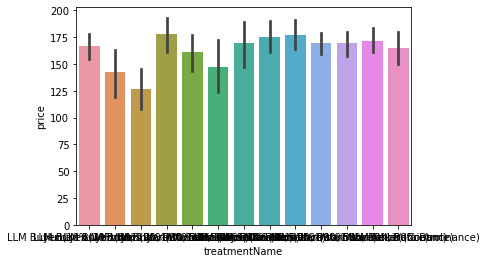

In [305]:
#show a bargraph of price for treatment name with human vs human as the reference group, discounting all price values over 300
sns.barplot(x="treatmentName", y="price", data=df_gamesnew.query("price < 300"))

In [312]:
#compute a new column called postbatna_value_capture that is price minus 90 if role is seller and price minus 190 if role is buyer
df_gamesnew['postbatna_value_capture'] = np.where(df_gamesnew['role'] == 'seller', df_gamesnew['price'] - 90, df_gamesnew['price'] - 190)


In [313]:
#show mean postbatna_value_capture for all treatment names, discounting all price values over 300
df_gamesnew.query("price < 300").groupby("treatmentName")["postbatna_value_capture"].mean()

treatmentName
Human vs. Human                           27.074074
LLM Buyer (10% Warmth, 10% Dominance)     52.333333
LLM Buyer (10% Warmth, 90% Dominance)     36.333333
LLM Buyer (50% Warmth, 50% Dominance)     88.214286
LLM Buyer (90% Warmth, 10% Dominance)     71.600000
LLM Buyer (90% Warmth, 90% Dominance)     57.500000
LLM Buyer (Control)                       79.666667
LLM Seller (10% Warmth, 10% Dominance)   -15.000000
LLM Seller (10% Warmth, 90% Dominance)   -12.500000
LLM Seller (50% Warmth, 50% Dominance)   -20.333333
LLM Seller (90% Warmth, 10% Dominance)   -20.200000
LLM Seller (90% Warmth, 90% Dominance)   -18.214286
LLM Seller (Control)                     -24.642857
Name: postbatna_value_capture, dtype: float64

In [317]:
#create a new column called human_treatmentname that is the treatmentname column but if value is human vs human appends the role column
df_gamesnew['human_treatmentname'] = np.where(df_gamesnew['treatmentName'] == 'Human vs. Human', df_gamesnew['treatmentName'] + df_gamesnew['role'], df_gamesnew['treatmentName'])

In [321]:
#show mean price for human_treatmentname, discounting all price values over 300
df_gamesnew.query("price < 300").groupby("human_treatmentname")["price"].mean()

human_treatmentname
Human vs. Humanbuyer                      174.481481
Human vs. Humanseller                     159.666667
LLM Buyer (10% Warmth, 10% Dominance)     142.333333
LLM Buyer (10% Warmth, 90% Dominance)     126.333333
LLM Buyer (50% Warmth, 50% Dominance)     178.214286
LLM Buyer (90% Warmth, 10% Dominance)     161.600000
LLM Buyer (90% Warmth, 90% Dominance)     147.500000
LLM Buyer (Control)                       169.666667
LLM Seller (10% Warmth, 10% Dominance)    175.000000
LLM Seller (10% Warmth, 90% Dominance)    177.500000
LLM Seller (50% Warmth, 50% Dominance)    169.666667
LLM Seller (90% Warmth, 10% Dominance)    169.800000
LLM Seller (90% Warmth, 90% Dominance)    171.785714
LLM Seller (Control)                      165.357143
Name: price, dtype: float64

df_gamesnew.info()

In [325]:
#show mean price for all deal_reached values equal to 1, discounting all price values over 300
df_gamesnew.query("deal_reached == 1 and price < 300").groupby("human_treatmentname")["price"].mean()

human_treatmentname
Human vs. Humanbuyer                      171.782609
Human vs. Humanseller                     171.782609
LLM Buyer (10% Warmth, 10% Dominance)     177.222222
LLM Buyer (10% Warmth, 90% Dominance)     158.125000
LLM Buyer (50% Warmth, 50% Dominance)     185.000000
LLM Buyer (90% Warmth, 10% Dominance)     172.615385
LLM Buyer (90% Warmth, 90% Dominance)     179.444444
LLM Buyer (Control)                       175.357143
LLM Seller (10% Warmth, 10% Dominance)    169.545455
LLM Seller (10% Warmth, 90% Dominance)    170.555556
LLM Seller (50% Warmth, 50% Dominance)    168.214286
LLM Seller (90% Warmth, 10% Dominance)    166.692308
LLM Seller (90% Warmth, 90% Dominance)    166.818182
LLM Seller (Control)                      165.357143
Name: price, dtype: float64

In [327]:
#show price mean for each human_treatmentname, discounting all price values over 300
df_gamesnew.query("price < 300").groupby("human_treatmentname")["price"].mean()

human_treatmentname
Human vs. Humanbuyer                      174.481481
Human vs. Humanseller                     159.666667
LLM Buyer (10% Warmth, 10% Dominance)     142.333333
LLM Buyer (10% Warmth, 90% Dominance)     126.333333
LLM Buyer (50% Warmth, 50% Dominance)     178.214286
LLM Buyer (90% Warmth, 10% Dominance)     161.600000
LLM Buyer (90% Warmth, 90% Dominance)     147.500000
LLM Buyer (Control)                       169.666667
LLM Seller (10% Warmth, 10% Dominance)    175.000000
LLM Seller (10% Warmth, 90% Dominance)    177.500000
LLM Seller (50% Warmth, 50% Dominance)    169.666667
LLM Seller (90% Warmth, 10% Dominance)    169.800000
LLM Seller (90% Warmth, 90% Dominance)    171.785714
LLM Seller (Control)                      165.357143
Name: price, dtype: float64

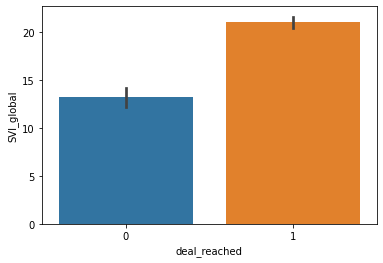

In [266]:
#show svi global for deal reached in a bar graph
ax = sns.barplot(x="deal_reached", y="SVI_global", data=df_gamesnew)

In [331]:
#show mean values for each svi variable for human_treatmentname, show 1 decimal places, order by SVI_global
df_gamesnew.groupby("human_treatmentname")[["SVI_outcome","SVI_oneself","SVI_process","SVI_relationship","SVI_global"]].mean().round(1).sort_values(by="SVI_global")

,SVI_outcome,SVI_oneself,SVI_process,SVI_relationship,SVI_global
human_treatmentname,,,,,
"LLM Buyer (10% Warmth, 90% Dominance)",16.5,17.9,14.5,14.6,15.9
"LLM Buyer (90% Warmth, 90% Dominance)",16.6,18.4,17.0,16.1,17.0
"LLM Seller (10% Warmth, 90% Dominance)",17.9,19.5,17.7,15.5,17.7
Human vs. Humanbuyer,18.7,19.7,19.3,17.3,18.6
"LLM Seller (90% Warmth, 90% Dominance)",19.1,19.3,19.5,17.0,18.7
Human vs. Humanseller,19.6,19.1,18.8,17.5,18.8
"LLM Buyer (10% Warmth, 10% Dominance)",19.1,19.5,19.3,18.7,19.2
LLM Buyer (Control),20.0,20.7,19.7,19.8,20.0
"LLM Seller (90% Warmth, 10% Dominance)",19.9,20.1,21.5,19.5,20.2


In [332]:
#show mean values for each svi variable for human_treatmentname, show 1 decimal places, order by SVI_global only for those with deal reached
df_gamesnew.query("deal_reached == 1").groupby("human_treatmentname")[["SVI_outcome","SVI_oneself","SVI_process","SVI_relationship","SVI_global"]].mean().round(1).sort_values(by="SVI_global")

,SVI_outcome,SVI_oneself,SVI_process,SVI_relationship,SVI_global
human_treatmentname,,,,,
Human vs. Humanbuyer,19.5,19.8,19.5,18.2,19.0
"LLM Seller (90% Warmth, 90% Dominance)",20.2,20.5,20.0,18.1,19.7
Human vs. Humanseller,20.9,19.3,20.0,18.9,19.8
"LLM Buyer (10% Warmth, 90% Dominance)",21.4,20.3,17.0,17.7,19.9
"LLM Buyer (90% Warmth, 90% Dominance)",20.1,20.1,19.8,20.0,20.0
LLM Buyer (Control),20.7,21.4,20.9,20.9,21.0
"LLM Seller (90% Warmth, 10% Dominance)",21.7,21.5,22.3,20.8,21.6
"LLM Seller (10% Warmth, 90% Dominance)",22.8,21.1,23.0,20.2,21.8
"LLM Buyer (10% Warmth, 10% Dominance)",23.0,22.0,21.8,20.8,21.9


In [333]:
#run svi_global on llm dummy variable
smf.ols("SVI_global ~ llm", data=df_gamesnew).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SVI_global   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.959
Date:                Sun, 24 Dec 2023   Prob (F-statistic):              0.163
Time:                        01:35:45   Log-Likelihood:                -677.32
No. Observations:                 226   AIC:                             1359.
Df Residuals:                     224   BIC:                             1365.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.6713      0.662     28.190      0.000      17.366      19.977
llm            1.0627      0.759      1.400      0.163      -0.433       2.559
==============================================================================
Omnibus:                       15.861   Durbin-Watson:                   2.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.548
Skew:                          -0.681   Prob(JB):                     0.000155
Kurtosis:                       3.094   Cond. No.                         3.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [334]:
#run svi_global on llm dummy variable only for those with deal reached
smf.ols("SVI_global ~ llm", data=df_gamesnew.query("deal_reached == 1")).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SVI_global   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     11.56
Date:                Sun, 24 Dec 2023   Prob (F-statistic):           0.000831
Time:                        01:36:58   Log-Likelihood:                -496.39
No. Observations:                 182   AIC:                             996.8
Df Residuals:                     180   BIC:                             1003.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.4149      0.543     35.770      0.000      18.344      20.486
llm            2.1425      0.630      3.400      0.001       0.899       3.386
==============================================================================
Omnibus:                       24.878   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.670
Skew:                          -0.762   Prob(JB):                     6.61e-09
Kurtosis:                       4.626   Cond. No.                         3.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [362]:
#run svi_global on llm dummy variable adding price, deal_reached, n_proposals, negotiation_length_mins, and role as covariates only for those with deal reached
smf.ols("SVI_global ~ llm + price + role", data=df_gamesnew.query("deal_reached == 1")).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SVI_global   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     6.532
Date:                Sun, 24 Dec 2023   Prob (F-statistic):           0.000324
Time:                        02:30:56   Log-Likelihood:                -492.55
No. Observations:                 182   AIC:                             993.1
Df Residuals:                     178   BIC:                             1006.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         20.9361      0.800     26.176      0.000      19.358      22.514
role[T.seller]    -0.0961      0.544     -0.177      0.860      -1.169       0.977
llm                1.8332      0.631      2.907      0.004       0.589       3.078
price             -0.0068      0.002     -2.759      0.006      -0.012      -0.002
==============================================================================
Omnibus:                       10.059   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.809
Skew:                          -0.466   Prob(JB):                      0.00450
Kurtosis:                       3.746   Cond. No.                         755.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [344]:
#compare svi_global with human_treatname as the IV and for the reference group human vs human
smf.ols("SVI_global ~ C(human_treatmentname, Treatment(reference='Human vs. Humanseller'))", data=df_gamesnew).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             SVI_global   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     2.323
Date:                Sun, 24 Dec 2023   Prob (F-statistic):            0.00666
Time:                        01:47:56   Log-Likelihood:                -663.26
No. Observations:                 226   AIC:                             1355.
Df Residuals:                     212   BIC:                             1402.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================================
                                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                         18.7589      0.888     21.114      0.000      17.008      20.510
C(human_treatmentname, Treatment(reference='Human vs. Humanseller'))[T.Human vs. Humanbuyer]                      -0.1820      1.280     -0.142      0.887      -2.706       2.342
C(human_treatmentname, Treatment(reference='Human vs. Humanseller'))[T.LLM Buyer (10% Warmth, 10% Dominance)]      0.4244      1.504      0.282      0.778      -2.541       3.390
C(human_treatmentname, Treatment(reference='Human vs. Humanseller'))[T.LLM Buyer (10% Warmth, 90% Dominance)]     -2.8935      1.578     -1.834      0.068      -6.004       0.217
C(human_treatmentname, Treatment(reference='Human vs. Humanseller'))[T.LLM Buyer (50% Warmth, 50% Dominance)]      2.9018      1.539      1.886      0.061      -0.132       5.935
C(human_treatmentname, Treatment(reference='Human vs. Humanseller'))[T.LLM Buyer (90% Warmth, 10% Dominance)]      2.1411      1.504      1.423      0.156      -0.824       5.106
C(human_treatmentname, Treatment(reference='Human vs. Humanseller'))[T.LLM Buyer (90% Warmth, 90% Dominance)]     -1.7232      1.539     -1.120      0.264      -4.757       1.310
C(human_treatmentname, Treatment(reference='Human vs. Humanseller'))[T.LLM Buyer (Control)]                        1.2911      1.504      0.858      0.392      -1.674       4.256
C(human_treatmentname, Treatment(reference='Human vs. Humanseller'))[T.LLM Seller (10% Warmth, 10% Dominance)]     1.7744      1.504      1.180      0.239      -1.191       4.740
C(human_treatmentname, Treatment(reference='Human vs. Humanseller'))[T.LLM Seller (10% Warmth, 90% Dominance)]    -1.1051      1.578     -0.700      0.484      -4.215       2.005
C(human_treatmentname, Treatment(reference='Human vs. Humanseller'))[T.LLM Seller (50% Warmth, 50% Dominance)]     3.3077      1.504      2.199      0.029       0.343       6.273
C(human_treatmentname, Treatment(reference='Human vs. Humanseller'))[T.LLM Seller (90% Warmth, 10% Dominance)]     1.4911      1.504      0.991      0.323      -1.474       4.456
C(human_treatmentname, Treatment(reference='Human vs. Humanseller'))[T.LLM Seller (90% Warmth, 90% Dominance)]    -0.0268      1.539     -0.017      0.986      -3.060       3.007
C(human_treatmentname, Treatment(reference='Human vs. Humanseller'))[T.LLM Seller (Control)]                       3.3661      1.539      2.187      0.030       0.333       6.399
========================================

In [342]:
#show human_treatmentname value counts
df_gamesnew.human_treatmentname.value_counts()

Human vs. Humanbuyer                      28
Human vs. Humanseller                     28
LLM Seller (90% Warmth, 10% Dominance)    15
LLM Seller (10% Warmth, 10% Dominance)    15
LLM Buyer (Control)                       15
LLM Buyer (10% Warmth, 90% Dominance)     15
LLM Buyer (10% Warmth, 10% Dominance)     15
LLM Seller (50% Warmth, 50% Dominance)    15
LLM Buyer (90% Warmth, 10% Dominance)     15
LLM Seller (10% Warmth, 90% Dominance)    14
LLM Buyer (90% Warmth, 90% Dominance)     14
LLM Seller (90% Warmth, 90% Dominance)    14
LLM Seller (Control)                      14
LLM Buyer (50% Warmth, 50% Dominance)     14
Name: human_treatmentname, dtype: int64

In [335]:
df_gamesnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231 entries, 0 to 230
Data columns (total 66 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   index                             231 non-null    int64   
 1   id                                231 non-null    object  
 2   messages                          231 non-null    object  
 3   messagesLastChangedAt             231 non-null    object  
 4   ended                             231 non-null    bool    
 5   endedLastChangedAt                231 non-null    object  
 6   lobbyTimerID                      231 non-null    object  
 7   lobbyTimerIDLastChangedAt         231 non-null    object  
 8   stageID                           0 non-null      float64 
 9   stageIDLastChangedAt              231 non-null    object  
 10  treatment                         231 non-null    object  
 11  treatmentLastChangedAt            231 non-null    object  

In [348]:
#create a variable called new_value_capture that is price minus 90 if role is seller and price minus 190 if role is buyer
df_gamesnew['new_value_capture'] = np.where(df_gamesnew['role'] == 'seller', df_gamesnew['price'] - 90, 190- df_gamesnew['price'])

In [355]:
#show mean new_value_capture for all human treatmentname, discounting all price values over 300 and deal_reached equal to 1
df_gamesnew.query("price < 300 and deal_reached == 1").groupby("human_treatmentname")["new_value_capture"].mean()

human_treatmentname
Human vs. Humanbuyer                      18.217391
Human vs. Humanseller                     81.782609
LLM Buyer (10% Warmth, 10% Dominance)     87.222222
LLM Buyer (10% Warmth, 90% Dominance)     68.125000
LLM Buyer (50% Warmth, 50% Dominance)     95.000000
LLM Buyer (90% Warmth, 10% Dominance)     82.615385
LLM Buyer (90% Warmth, 90% Dominance)     89.444444
LLM Buyer (Control)                       85.357143
LLM Seller (10% Warmth, 10% Dominance)    20.454545
LLM Seller (10% Warmth, 90% Dominance)    19.444444
LLM Seller (50% Warmth, 50% Dominance)    21.785714
LLM Seller (90% Warmth, 10% Dominance)    23.307692
LLM Seller (90% Warmth, 90% Dominance)    23.181818
LLM Seller (Control)                      24.642857
Name: new_value_capture, dtype: float64

In [361]:
#compare new_value_capture only querying role == buyer and discounting price over 300, use llm as the IV 
smf.ols("new_value_capture ~ llm", data=df_gamesnew.query("role == 'buyer' and price < 300")).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      new_value_capture   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.2112
Date:                Sun, 24 Dec 2023   Prob (F-statistic):              0.647
Time:                        02:28:58   Log-Likelihood:                -545.73
No. Observations:                 114   AIC:                             1095.
Df Residuals:                     112   BIC:                             1101.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.5185      5.635      2.754      0.007       4.353      26.684
llm            2.9642      6.451      0.460      0.647      -9.817      15.746
==============================================================================
Omnibus:                        1.480   Durbin-Watson:                   1.501
Prob(Omnibus):                  0.477   Jarque-Bera (JB):                0.985
Skew:                          -0.113   Prob(JB):                        0.611
Kurtosis:                       3.396   Cond. No.                         3.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [360]:
#compare deal_reached with llm as the IV
smf.logit("deal_reached ~ llm", data=df_gamesnew).fit().summary()

Optimization terminated successfully.
         Current function value: 0.490213
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           deal_reached   No. Observations:                  231
Model:                          Logit   Df Residuals:                      229
Method:                           MLE   Df Model:                            1
Date:                Sun, 24 Dec 2023   Pseudo R-squ.:                0.005888
Time:                        02:16:10   Log-Likelihood:                -113.24
converged:                       True   LL-Null:                       -113.91
Covariance Type:            nonrobust   LLR p-value:                    0.2468
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7918      0.382      4.692      0.000       1.043       2.540
llm           -0.4754      0.424     -1.120      0.263      -1.307       0.356
==============================================================================
"""

In [357]:
#show all mean values for treatmentname only querying role == buyer
df_gamesnew.query("role == 'buyer'").groupby("treatmentName")["new_value_capture"].mean()

treatmentName
Human vs. Human                          -21.285714
LLM Seller (10% Warmth, 10% Dominance)    15.000000
LLM Seller (10% Warmth, 90% Dominance)    12.500000
LLM Seller (50% Warmth, 50% Dominance)    20.333333
LLM Seller (90% Warmth, 10% Dominance)    20.200000
LLM Seller (90% Warmth, 90% Dominance)    18.214286
LLM Seller (Control)                      24.642857
Name: new_value_capture, dtype: float64

In [347]:
df_gamesnew.head(10)

,index,id,messages,messagesLastChangedAt,ended,endedLastChangedAt,lobbyTimerID,lobbyTimerIDLastChangedAt,stageID,stageIDLastChangedAt,treatment,treatmentLastChangedAt,price,priceLastChangedAt,start,startLastChangedAt,treatmentName,treatmentNameLastChangedAt,batchID,batchIDLastChangedAt,groupID,groupIDLastChangedAt,result,resultLastChangedAt,roundIndex,roundIndexLastChangedAt,currentTurnPlayerId,currentTurnPlayerIdLastChangedAt,endedReason,endedReasonLastChangedAt,status,statusLastChangedAt,TREATMENT_llm_role,TREATMENT_warmth_level,TREATMENT_dom_level,deal_reached,LLM_batna,LLM_captured_value,LLM_captured_value_imputed,price_imputed,symmetric_treatment_name,TREATMENT_warmth_level_str,TREATMENT_dom_level_str,gameID_x,gameID_y,gameID,negotiation_length_mins,prolific_id,negotiation_length_messages,n_proposals,llm,PARTNER_assertive,PARTNER_empathy,PARTNER_warm,PARTNER_dominant,PARTNER_assertive_cat,PARTNER_empathy_cat,PARTNER_warm_cat,PARTNER_dominant_cat,SVI_outcome,SVI_oneself,SVI_process,SVI_relationship,SVI_global,role,human_treatmentname,new_value_capture
0,0,01HGXTHAEVY04KADBQQHJ8J5YDbuyer,"[{""type"":""message"",""text"":""Hey this is an awes...",2023-12-05T20:40:21.176140722Z,True,2023-12-05T20:40:21.233007966Z,01HGXTYFB32MHF1847SKZ19BT9,2023-12-05T20:33:09.480435048Z,NaN,2023-12-05T20:40:21.233007966Z,human,2023-12-05T20:25:58.491265245Z,105.0,2023-12-05T20:40:21.175461467Z,True,2023-12-05T20:33:59.106427764Z,Human vs. Human,2023-12-05T20:25:58.491265245Z,01HGXTHADP3KNBM6JQD3PWW7A8,2023-12-05T20:25:58.491265245Z,01HGXTHAFS5BQJ6C5TDQZ5M5XH,2023-12-05T20:25:58.578822274Z,deal-reached,2023-12-05T20:40:21.174966625Z,0,2023-12-05T20:33:59.127971836Z,01HGXTYCVMM6PE3EA1AACBD5V4,2023-12-05T20:40:20.060080752Z,end of game,2023-12-05T20:40:21.245934605Z,ended,2023-12-05T20:40:21.245934605Z,NaN,NaN,NaN,1,NaN,NaN,0,105.0,NaN,Control,Control,NaN,NaN,01HGXTHAEVY04KADBQQHJ8J5YD,5.454088,"{'5a8d8079190420000156435d', '5ea1119c737ba611...",12,3,0,2.0,2.0,2.0,2.0,2,2,2,2,18.0,18.0,21.0,18.0,18.75,buyer,Human vs. Humanbuyer,-85.0
1,0,01HGXTHAEVY04KADBQQHJ8J5YDseller,"[{""type"":""message"",""text"":""Hey this is an awes...",2023-12-05T20:40:21.176140722Z,True,2023-12-05T20:40:21.233007966Z,01HGXTYFB32MHF1847SKZ19BT9,2023-12-05T20:33:09.480435048Z,NaN,2023-12-05T20:40:21.233007966Z,human,2023-12-05T20:25:58.491265245Z,105.0,2023-12-05T20:40:21.175461467Z,True,2023-12-05T20:33:59.106427764Z,Human vs. Human,2023-12-05T20:25:58.491265245Z,01HGXTHADP3KNBM6JQD3PWW7A8,2023-12-05T20:25:58.491265245Z,01HGXTHAFS5BQJ6C5TDQZ5M5XH,2023-12-05T20:25:58.578822274Z,deal-reached,2023-12-05T20:40:21.174966625Z,0,2023-12-05T20:33:59.127971836Z,01HGXTYCVMM6PE3EA1AACBD5V4,2023-12-05T20:40:20.060080752Z,end of game,2023-12-05T20:40:21.245934605Z,ended,2023-12-05T20:40:21.245934605Z,NaN,NaN,NaN,1,NaN,NaN,0,105.0,NaN,Control,Control,NaN,NaN,01HGXTHAEVY04KADBQQHJ8J5YD,5.454088,"{'5a8d8079190420000156435d', '5ea1119c737ba611...",12,3,0,2.0,2.0,2.0,2.0,2,2,2,2,16.0,12.0,20.0,18.0,16.50,seller,Human vs. Humanseller,15.0
2,2,01HGXTHAEW56B1Z3XBTT8GP8R1,"[{""text"":""I've had a chance to look at the tab...",2023-12-05T20:34:06.570699963Z,True,2023-12-05T20:34:06.59374928Z,01HGXTV4TDXFVXKKZRKDKV1C5H,2023-12-05T20:31:20.407578173Z,NaN,2023-12-05T20:34:06.59374928Z,buyer,2023-12-05T20:25:58.49207054Z,185.0,2023-12-05T20:34:06.572550555Z,True,2023-12-05T20:31:20.392986103Z,"LLM Buyer (10% Warmth, 10% Dominance)",2023-12-05T20:25:58.49207054Z,01HGXTHADP3KNBM6JQD3PWW7A8,2023-12-05T20:25:58.49207054Z,01HGXTHAN2AVRCZERTT0HKGX1S,2023-12-05T20:25:58.692748637Z,deal-reached,2023-12-05T20:34:06.571436026Z,0,2023-12-05T20:31:20.407578173Z,01HGXTS3EMAAHA5PPSWFMX5DDQ,2023-12-05T20:34:03.564066057Z,end of game,2023-12-05T20:34:06.600927429Z,ended,2023-12-05T20:34:06.600927429Z,buyer,10.0,10.0,1,190.0,5.0,5,185.0,"10% Warmth, 10% Dominance",10.0,10.0,01HGXTHAEW56B1Z3XBTT8GP8R1,01HGXTHAEW56B1Z3XBTT8GP8R1,01HGXTHAEW56B1Z3XBTT8GP8R1,2.304030,{'612517df29cd32c6632b4a44'},9,1,1,3.0,2.0,3.0,2.0,